### To do:
* add counts for each value for a given row (number of 0s, 0.5s, 1.0s etc)
* look at mutual information
* Integrate sharpe calculator for optimizing
* Add DMatrix conversion for xgboost
* Add neutralization
* Attempt some ensemble methods
  - Try blending multiple XGBoost models
  - Try blending XGBoost with NN (once re-optimized)
* Add features
  - Kmeans
  - TSNE
* Reoptimize the NN

- Chunk up the XGBoost by saving and loading model on subsets of data


## Install dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install dependencies
!pip install numerapi numpy MulticoreTSNE xgboost
# import dependencies
!pip install --upgrade pandas
import pandas as pd
import numpy as np
import numerapi
from matplotlib import pylab as plt
import gc
!pip install --upgrade tables
from MulticoreTSNE import MulticoreTSNE as TSNE
from xgboost import XGBRegressor
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def era_boost_train(X, y, era_col, proportion=0.5, trees_per_step=10, num_iters=200):
    model = XGBRegressor(max_depth=3,
                         learning_rate=0.005,
                         n_estimators=trees_per_step,
                         n_jobs=-1,
                         colsample_bytree=0.1,
                         min_child_weight=5,
                         max_features='sqrt',
                         subsample=0.5,
                         warm_start=(num_iters>1))
    features = X.columns
    %time model.fit(X, y)
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    for i in range(num_iters-1):
        print(f'###############')
        print(f"Iteration {i}")
        print(f'###############')
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
        model.n_estimators += trees_per_step
        booster = model.get_booster()
        print("fitting on worst eras")
        %time model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
    return model

def reduce_training_data(df,sample_size):
  # Take a random subsample to reduce RAM useage and prevent from crashing
  feature_names = df.columns[df.columns.str.startswith('feature')]
  reduced_training_data = df.sample(n=sample_size)
  X_train = reduced_training_data[feature_names]
  y_train = reduced_training_data['target']

  return [X_train, y_train]

def score_on_eras(df,preds):
    proportion = 0.5
    new_df = df.copy()
    new_df["target"] = df.target
    new_df["era"] = df.era
    new_df["pred"] = preds
    era_scores = pd.Series(index=new_df["era"].unique())
    print("getting per era scores")
    for era in new_df["era"].unique():
        era_df = new_df[new_df["era"] == era]
        era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
    era_scores.sort_values(inplace=True)
    worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
    print(list(worst_eras))
    worst_df = new_df[new_df["era"].isin(worst_eras)]
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.show()
    print("autocorrelation")
    print(ar1(era_scores))
    print("mean correlation")
    print(np.mean(era_scores))
    print("sharpe")
    print(np.mean(era_scores)/np.std(era_scores))
    print("smart sharpe")
    print(smart_sharpe(era_scores))

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.3.0)
     |████████████████████████████████| 4.3MB 13.5MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


## Download the datasets

### Datasets 
*   `training_data` is used to train your model
*   `tournament_data` is used to evaluate your model

### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance

### Use `reduce_mem_usage` from kaggle forums to reduce dataset size



In [ ]:
# Download dataset to Google Drive
napi = numerapi.NumerAPI(verbosity="info")
napi.download_current_dataset(dest_path='./drive/MyDrive/numerai/', dest_filename=None, unzip=True, tournament=8)

2021-07-11 19:53:38,546 INFO numerapi.utils: starting download
./drive/MyDrive/numerai/numerai_dataset_272.zip: 100%|█████████▉| 411M/412M [00:11<00:00, 39.2MB/s]2021-07-11 19:53:50,262 INFO numerapi.base_api: unzipping file...
./drive/MyDrive/numerai/numerai_dataset_272.zip: 412MB [00:29, 39.2MB/s]                           

'./drive/MyDrive/numerai/numerai_dataset_272.zip'

In [ ]:
# Compress dataset

CURRENT_DATASET = 272
training_file = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_training_data.csv'
tournament_file = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_tournament_data.csv'
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                    print("8bit")
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

training_data = reduce_mem_usage(pd.read_csv(training_file).drop(['id','data_type'],axis=1))
feature_names = training_data.columns[training_data.columns.str.startswith('feature')]
tournament_data = reduce_mem_usage(pd.read_csv(tournament_file))

training_data.to_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_training_data_reduced.h5', key='stage',mode='w')
tournament_data.to_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_tournament_data_reduced.h5', key='stage',mode='w')

#training_data.to_csv('./drive/MyDrive/numerai/numerai_dataset_254/numerai_training_data_reduced.csv')
#tournament_data.to_csv('./drive/MyDrive/numerai/numerai_dataset_254/numerai_tournament_data_reduced.csv')

Memory usage after optimization is: 301.49 MB
Decreased by 74.8%
Memory usage after optimization is: 1086.37 MB
Decreased by 74.3%


In [ ]:
tournament_data = reduce_mem_usage(pd.read_csv(tournament_file))

Memory usage after optimization is: 1033.00 MB
Decreased by 74.3%


# Add additional features to dataset

## Mean, STD, Skew, Mean Interaction

In [ ]:
CURRENT_DATASET = 272
%time training_data = pd.read_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_training_data_reduced.h5', key='stage',mode='r')
%time tournament_data = pd.read_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_tournament_data_reduced.h5', key='stage',mode='r')


CPU times: user 2.91 s, sys: 345 ms, total: 3.25 s
Wall time: 3.98 s
CPU times: user 10.1 s, sys: 1.67 s, total: 11.8 s
Wall time: 13.2 s


In [ ]:
# Add group mean, std, skew
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
        for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
            cols = [col for col in df.columns if group in col]
            df[f"feature_{group}_mean"] = df[cols].mean(axis=1)
            df[f"feature_{group}_std"] = df[cols].std(axis=1)
            df[f"feature_{group}_skew"] = df[cols].skew(axis=1)
        return df

def get_interactions(df):          
    a = df.values
    r,c = np.triu_indices(a.shape[1],1)
    cols = df.columns
    nm = [cols[i]+"_"+cols[j] for i,j in zip(r,c)]
    return pd.DataFrame(a[:,r] - a[:,c], columns=nm)

training_data = get_group_stats(training_data)
# Add differences between group means
cols = [col for col in training_data.columns if 'mean' in col]
df = training_data[cols]
training_data = pd.concat([training_data,get_interactions(df)],axis=1)

live_data = get_group_stats(tournament_data)
df = live_data[cols]
live_data = pd.concat([live_data,get_interactions(df)],axis=1)

validation_data = live_data[live_data['data_type']=='validation']

training_data.to_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_training_data_reduced.h5', key='stage',mode='w')
validation_data.to_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_validation_data_reduced.h5', key='stage',mode='w')
live_data.to_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_live_data_reduced.h5', key='stage',mode='w')

In [ ]:
# Add totals for each target value, maybe broken down by category. Need to normalize.

for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
    cols = [col for col in df.columns if group in col]

    for rows in df.index()
      counts = df[cols][rows].value_counts
    df[f"feature_{group}_mean"] = df[cols].mean(axis=1)
    df[f"feature_{group}_std"] = df[cols].std(axis=1)
    df[f"feature_{group}_skew"] = df[cols].skew(axis=1)

# Load Processed Dataset

In [ ]:
#Load compressed dataset if already downloaded and processed in Google Drive
CURRENT_DATASET = 272
%time training_data = pd.read_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_training_data_reduced.h5', key='stage',mode='r')
%time validation_data = pd.read_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_validation_data_reduced.h5', key='stage',mode='r')
%time live_data = pd.read_hdf(f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/numerai_live_data_reduced.h5', key='stage',mode='r')
feature_names = training_data.columns[training_data.columns.str.startswith('feature')]

CPU times: user 1.2 s, sys: 318 ms, total: 1.52 s
Wall time: 6.21 s
CPU times: user 156 ms, sys: 51.5 ms, total: 207 ms
Wall time: 2.78 s
CPU times: user 4.47 s, sys: 1.48 s, total: 5.95 s
Wall time: 22.3 s


#Data Exploration

## TSNE

In [ ]:
# Try tSNE on subset of features
def reduce_training_data(df,sample_size):
  # Take a random subsample to reduce RAM useage and prevent from crashing
  reduced_training_data = df.sample(n=sample_size)
  X_train = reduced_training_data[feature_names]
  y_train = reduced_training_data['target']

  return [X_train, y_train]

[X,y] = reduce_training_data(training_data,1000)
tsne = TSNE(n_jobs=-1)
%time Y = tsne.fit_transform(X)




CPU times: user 11.8 s, sys: 29.1 ms, total: 11.8 s
Wall time: 6.03 s


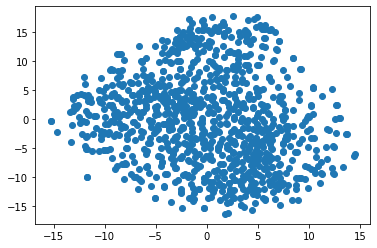

In [ ]:
x,y=zip(*Y)
plt.scatter(x,y)

# Train model using NN

In [ ]:
# Build NN model

feature_names = training_data.columns[training_data.columns.str.startswith('feature')]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

def build_model(layer_size,learning_rate=0.01, momentum=0):
    """Build Keras model"""
    model = keras.Sequential([
      layers.Dense(layer_size, activation='relu',
                   input_shape=[len(feature_names)]),
      layers.Dense(layer_size, activation='relu', kernel_regularizer='l2'),
      layers.Dense(1, activation='sigmoid')
    ])
    optimizer = SGD(lr=learning_rate, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model
  
# Later called by:
lr = 1e-4
layer_size = 5
nn_model = KerasClassifier(build_model,epochs=10, batch_size=10, layer_size=layer_size)

In [ ]:
# Train NN model
from keras.utils import np_utils

#train_features = pd.DataFrame()
#train_target = pd.DataFrame()
#eras = ['era3', 'era75', 'era119']
#for era in eras:
#  era_split_training_data = training_data[training_data.era==era]
#  era_split_train_target = training_data[training_data.era==era].target
#  train_features = pd.concat([train_features,era_split_training_data[feature_names]])
#  train_target = pd.concat([train_target,era_split_train_target])

def train_model(model, feature, label, epochs, batch_size):
    """Train Keras Model"""
    history = model.fit(x=feature,
                        y=label,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mse"]
    return epochs, mse

def score(df):
    """Ranks Predictions and returns correlation"""
    pct_ranks = df['prediction'].rank(pct=True, method="first")
    targets = df['target']
    return np.corrcoef(targets, pct_ranks)[0, 1]

epochs = 30
batch_size = 300  
# epochs, rmse = train_model(regressor_model, train_features, train_target, epochs, batch_size)


NameError: ignored

In [ ]:
# Use k-fold cross validation on model
from sklearn.model_selection import KFold
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(train_features,train_target):
  nn_model = build_model(lr, layer_size)
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  epochs = 10
  batch_size = 10 
  X = train_features.iloc[train,:]
  y = train_target.iloc[train]
  history = train_model(nn_model, X, y, epochs, batch_size)
  fold_no += 1
  prediction = nn_model.predict(train_features.iloc[test,:])
  d = {'prediction': pd.Series(prediction.flatten()), 'target': pd.Series(train_target.iloc[test].values.ravel())}
  df = pd.DataFrame(data=d)
  print(f"Corr Rank: {score(df)}")

------------------------------------------------------------------------
Training for fold 1 ...
Corr Rank: -0.03127840780174545
------------------------------------------------------------------------
Training for fold 2 ...
Corr Rank: -0.008537162725422473
------------------------------------------------------------------------
Training for fold 3 ...
Corr Rank: -0.001435015433665007
------------------------------------------------------------------------
Training for fold 4 ...
Corr Rank: 0.04436655653317113
------------------------------------------------------------------------
Training for fold 5 ...
Corr Rank: 0.013221759767209573
------------------------------------------------------------------------
Training for fold 6 ...
Corr Rank: 0.04015672484879702
------------------------------------------------------------------------
Training for fold 7 ...
Corr Rank: -0.03106210231775733
------------------------------------------------------------------------
Training for fold 8 ...


In [ ]:
# Use grid search to find optimal epochs, batch_size
from sklearn.model_selection import GridSearchCV
batch_size = [10,50,200,500,1000]
epochs = [10, 100, 500]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=nn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_results = grid.fit(X,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.110620 using {'batch_size': 10, 'epochs': 10}
-0.110620 (0.010142) with: {'batch_size': 10, 'epochs': 10}
-0.110620 (0.010142) with: {'batch_size': 10, 'epochs': 100}
-0.110620 (0.010142) with: {'batch_size': 10, 'epochs': 500}
-0.110620 (0.010142) with: {'batch_size': 50, 'epochs': 10}
-0.110620 (0.010142) with: {'batch_size': 50, 'epochs': 100}
-0.110620 (0.010142) with: {'batch_size': 50, 'epochs': 500}
-0.111816 (0.011548) with: {'batch_size': 200, 'epochs': 10}
-0.110620 (0.010142) with: {'batch_size': 200, 'epochs': 100}
-0.110620 (0.010142) with: {'batch_size': 200, 'epochs': 500}
-0.182617 (0.098451) with: {'batch_size': 500, 'epochs': 10}
-0.110620 (0.010142) with: {'batch_size': 500, 'epochs': 100}
-0.110620 (0.010142) with: {'batch_size': 500, 'epochs': 500}
-0.145349 (0.062551) with: {'batch_size': 1000, 'epochs': 10}
-0.110620 (0.010142) with: {'batch_size': 1000, 'epochs': 100}
-0.110706 (0.010230) with: {'batch_size': 1000, 'epochs': 500}


In [ ]:
# Use grid search to find optimal optimizer type
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=nn_model, param_grid=param_grid,scoring='neg_mean_squared_error', cv=5)
grid_result = grid.fit(X,y)
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.112048 using {'optimizer': 'SGD'}
-0.112048 (0.008623) with: {'optimizer': 'SGD'}
-0.112048 (0.008623) with: {'optimizer': 'RMSprop'}
-0.112500 (0.009306) with: {'optimizer': 'Adagrad'}
-0.123730 (0.014007) with: {'optimizer': 'Adadelta'}
-0.112048 (0.008623) with: {'optimizer': 'Adam'}
-0.112048 (0.008623) with: {'optimizer': 'Adamax'}
-0.112048 (0.008623) with: {'optimizer': 'Nadam'}


In [ ]:
# Use grid search to find optimial learning rate and momentum
learning_rate = [1e-5,5e-5,1e-5]
momentum = [0]
param_grid = dict(learning_rate=learning_rate, momentum=momentum)
grid = GridSearchCV(estimator=nn_model, param_grid=param_grid,scoring='neg_mean_squared_error', cv=5)
grid_result = grid.fit(X,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9589 - mae: 1.5096 - mse: 2.9019
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9509 - mae: 1.4964 - mse: 2.8939
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 2.8402 - mae: 1.4678 - mse: 2.7832
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 2.6282 - mae: 1.3982 - mse: 2.5712
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 2.4762 - mae: 1.3381 - mse: 2.4191
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 2.2861 - mae: 1.2780 - mse: 2.2290
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 2.1959 - mae: 1.2443 - mse: 2.1388
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 2.0926 - mae: 1.2034 - mse: 2.0354
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 2.0283 - mae: 1.1783 - mse: 1.9711
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 2.8249 - mae: 1.4621 - mse: 2.7680
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 2.8001 - mae: 1.4551 - mse: 2.7432
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 2.7794 - mae: 1.4519 - mse: 2.7225
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 2.6369 - mae: 1.4030 - mse: 2.5799
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 2.5776 - mae: 1.3855 - mse: 2.5207
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 2.4923 - mae: 1.3546 - mse: 2.4352
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 2.4244 - mae: 1.3229 - mse: 2.3673
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 2.3413 - mae: 1.2949 - mse: 2.2842
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 2.2813 - mae: 1.2728 - mse: 2.2241
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 4.1931 - mae: 1.8480 - mse: 4.1443
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 4.0601 - mae: 1.8102 - mse: 4.0114
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 3.9663 - mae: 1.7907 - mse: 3.9178
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 3.7687 - mae: 1.7361 - mse: 3.7202
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 3.5315 - mae: 1.6770 - mse: 3.4832
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3879 - mae: 1.6318 - mse: 3.3396
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3112 - mae: 1.6126 - mse: 3.2630
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3389 - mae: 1.6141 - mse: 3.2908
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 3.1769 - mae: 1.5673 - mse: 3.1288
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0631 - mae: 1.5434 - mse: 3.0135
Epoch 2/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1410 - mae: 1.5601 - mse: 3.0915
Epoch 3/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1594 - mae: 1.5659 - mse: 3.1099
Epoch 4/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0603 - mae: 1.5359 - mse: 3.0108
Epoch 5/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1294 - mae: 1.5602 - mse: 3.0799
Epoch 6/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0765 - mae: 1.5456 - mse: 3.0270
Epoch 7/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0668 - mae: 1.5387 - mse: 3.0173
Epoch 8/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0045 - mae: 1.5241 - mse: 2.9551
Epoch 9/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0436 - mae: 1.5327 - mse: 2.9941
Epoch 10/10
772/772

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
772/772 [==============================] - 1s 1ms/step - loss: 3.6537 - mae: 1.7071 - mse: 3.6013
Epoch 2/10
772/772 [==============================] - 1s 1ms/step - loss: 3.5526 - mae: 1.6757 - mse: 3.5003
Epoch 3/10
772/772 [==============================] - 1s 1ms/step - loss: 3.3959 - mae: 1.6322 - mse: 3.3436
Epoch 4/10
772/772 [==============================] - 1s 1ms/step - loss: 3.3079 - mae: 1.6113 - mse: 3.2557
Epoch 5/10
772/772 [==============================] - 1s 1ms/step - loss: 3.2468 - mae: 1.5954 - mse: 3.1947
Epoch 6/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1926 - mae: 1.5813 - mse: 3.1405
Epoch 7/10
772/772 [==============================] - 1s 1ms/step - loss: 3.2445 - mae: 1.5895 - mse: 3.1925
Epoch 8/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1013 - mae: 1.5524 - mse: 3.0493
Epoch 9/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1010 - mae: 1.5522 - mse: 3.0490
Epoch 10/10
772/772

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3645 - mae: 1.6314 - mse: 3.3246
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2248 - mae: 1.5902 - mse: 3.1852
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 3.1207 - mae: 1.5641 - mse: 3.0812
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 3.0592 - mae: 1.5453 - mse: 3.0198
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 3.0108 - mae: 1.5255 - mse: 2.9716
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 3.0308 - mae: 1.5336 - mse: 2.9916
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9573 - mae: 1.5100 - mse: 2.9183
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9403 - mae: 1.5048 - mse: 2.9014
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 2.8940 - mae: 1.4916 - mse: 2.8551
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 2.8976 - mae: 1.4888 - mse: 2.8411
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 2.6289 - mae: 1.3997 - mse: 2.5723
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 2.4552 - mae: 1.3324 - mse: 2.3983
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 2.2820 - mae: 1.2690 - mse: 2.2249
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 2.1702 - mae: 1.2244 - mse: 2.1128
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 2.0288 - mae: 1.1818 - mse: 1.9712
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 1.9873 - mae: 1.1613 - mse: 1.9296
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 1.9260 - mae: 1.1365 - mse: 1.8680
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 1.9173 - mae: 1.1330 - mse: 1.8592
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2680 - mae: 1.5919 - mse: 3.2128
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 3.0807 - mae: 1.5357 - mse: 3.0256
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9743 - mae: 1.5046 - mse: 2.9192
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9023 - mae: 1.4869 - mse: 2.8473
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 2.7161 - mae: 1.4273 - mse: 2.6610
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 2.6740 - mae: 1.4119 - mse: 2.6188
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 2.4802 - mae: 1.3456 - mse: 2.4247
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 2.3327 - mae: 1.2918 - mse: 2.2770
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 2.2356 - mae: 1.2583 - mse: 2.1796
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
772/772 [==============================] - 1s 1ms/step - loss: 2.9383 - mae: 1.4969 - mse: 2.8788
Epoch 2/10
772/772 [==============================] - 1s 1ms/step - loss: 2.8026 - mae: 1.4564 - mse: 2.7430
Epoch 3/10
772/772 [==============================] - 1s 1ms/step - loss: 2.5586 - mae: 1.3703 - mse: 2.4989
Epoch 4/10
772/772 [==============================] - 1s 1ms/step - loss: 2.3516 - mae: 1.2996 - mse: 2.2917
Epoch 5/10
772/772 [==============================] - 1s 1ms/step - loss: 2.1760 - mae: 1.2333 - mse: 2.1158
Epoch 6/10
772/772 [==============================] - 1s 1ms/step - loss: 2.1359 - mae: 1.2114 - mse: 2.0755
Epoch 7/10
772/772 [==============================] - 1s 1ms/step - loss: 2.0107 - mae: 1.1681 - mse: 1.9501
Epoch 8/10
772/772 [==============================] - 1s 1ms/step - loss: 1.9783 - mae: 1.1587 - mse: 1.9175
Epoch 9/10
772/772 [==============================] - 1s 1ms/step - loss: 1.9332 - mae: 1.1367 - mse: 1.8723
Epoch 10/10
772/772

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
772/772 [==============================] - 1s 1ms/step - loss: 2.7774 - mae: 1.4511 - mse: 2.7363
Epoch 2/10
772/772 [==============================] - 1s 1ms/step - loss: 2.4551 - mae: 1.3434 - mse: 2.4138
Epoch 3/10
772/772 [==============================] - 1s 1ms/step - loss: 2.2329 - mae: 1.2625 - mse: 2.1914
Epoch 4/10
772/772 [==============================] - 1s 1ms/step - loss: 2.1128 - mae: 1.2114 - mse: 2.0710
Epoch 5/10
772/772 [==============================] - 1s 1ms/step - loss: 2.0048 - mae: 1.1686 - mse: 1.9628
Epoch 6/10
772/772 [==============================] - 1s 1ms/step - loss: 1.9474 - mae: 1.1501 - mse: 1.9052
Epoch 7/10
772/772 [==============================] - 1s 1ms/step - loss: 1.9208 - mae: 1.1373 - mse: 1.8784
Epoch 8/10
772/772 [==============================] - 1s 1ms/step - loss: 1.9076 - mae: 1.1300 - mse: 1.8651
Epoch 9/10
772/772 [==============================] - 1s 1ms/step - loss: 1.8666 - mae: 1.1136 - mse: 1.8240
Epoch 10/10
772/772

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3320 - mae: 1.6181 - mse: 3.2855
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3205 - mae: 1.6198 - mse: 3.2741
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2651 - mae: 1.6012 - mse: 3.2187
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2236 - mae: 1.5873 - mse: 3.1773
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 3.1729 - mae: 1.5765 - mse: 3.1266
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 3.1384 - mae: 1.5643 - mse: 3.0921
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 3.1308 - mae: 1.5592 - mse: 3.0846
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 3.1251 - mae: 1.5530 - mse: 3.0789
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 3.0804 - mae: 1.5508 - mse: 3.0342
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 3.4741 - mae: 1.6523 - mse: 3.4077
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3590 - mae: 1.6212 - mse: 3.2927
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3978 - mae: 1.6314 - mse: 3.3316
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 3.3269 - mae: 1.6065 - mse: 3.2606
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2793 - mae: 1.6022 - mse: 3.2131
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2204 - mae: 1.5839 - mse: 3.1543
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2079 - mae: 1.5762 - mse: 3.1418
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 3.2164 - mae: 1.5794 - mse: 3.1504
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 3.1498 - mae: 1.5591 - mse: 3.0839
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9705 - mae: 1.5114 - mse: 2.9165
Epoch 2/10
771/771 [==============================] - 1s 1ms/step - loss: 3.0079 - mae: 1.5201 - mse: 2.9538
Epoch 3/10
771/771 [==============================] - 1s 1ms/step - loss: 2.9105 - mae: 1.4929 - mse: 2.8565
Epoch 4/10
771/771 [==============================] - 1s 1ms/step - loss: 2.8748 - mae: 1.4793 - mse: 2.8207
Epoch 5/10
771/771 [==============================] - 1s 1ms/step - loss: 2.7803 - mae: 1.4476 - mse: 2.7262
Epoch 6/10
771/771 [==============================] - 1s 1ms/step - loss: 2.7838 - mae: 1.4408 - mse: 2.7297
Epoch 7/10
771/771 [==============================] - 1s 1ms/step - loss: 2.7080 - mae: 1.4209 - mse: 2.6538
Epoch 8/10
771/771 [==============================] - 1s 1ms/step - loss: 2.6001 - mae: 1.3856 - mse: 2.5459
Epoch 9/10
771/771 [==============================] - 1s 1ms/step - loss: 2.5776 - mae: 1.3760 - mse: 2.5234
Epoch 10/10
771/771

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1281 - mae: 1.5631 - mse: 3.0851
Epoch 2/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1955 - mae: 1.5756 - mse: 3.1526
Epoch 3/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1211 - mae: 1.5581 - mse: 3.0782
Epoch 4/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1433 - mae: 1.5611 - mse: 3.1004
Epoch 5/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0031 - mae: 1.5234 - mse: 2.9602
Epoch 6/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1164 - mae: 1.5569 - mse: 3.0736
Epoch 7/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0134 - mae: 1.5271 - mse: 2.9705
Epoch 8/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0527 - mae: 1.5369 - mse: 3.0098
Epoch 9/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0085 - mae: 1.5281 - mse: 2.9657
Epoch 10/10
772/772

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0970 - mae: 1.5534 - mse: 3.0439
Epoch 2/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1107 - mae: 1.5529 - mse: 3.0575
Epoch 3/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1348 - mae: 1.5600 - mse: 3.0817
Epoch 4/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1853 - mae: 1.5678 - mse: 3.1322
Epoch 5/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1560 - mae: 1.5591 - mse: 3.1029
Epoch 6/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1322 - mae: 1.5564 - mse: 3.0792
Epoch 7/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0756 - mae: 1.5448 - mse: 3.0226
Epoch 8/10
772/772 [==============================] - 1s 1ms/step - loss: 3.1149 - mae: 1.5500 - mse: 3.0620
Epoch 9/10
772/772 [==============================] - 1s 1ms/step - loss: 3.0944 - mae: 1.5496 - mse: 3.0414
Epoch 10/10
772/772

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
964/964 [==============================] - 2s 1ms/step - loss: 3.1981 - mae: 1.5787 - mse: 3.1521
Epoch 2/10
964/964 [==============================] - 1s 1ms/step - loss: 3.0254 - mae: 1.5274 - mse: 2.9795
Epoch 3/10
964/964 [==============================] - 1s 1ms/step - loss: 2.9740 - mae: 1.5167 - mse: 2.9282
Epoch 4/10
964/964 [==============================] - 1s 1ms/step - loss: 2.9061 - mae: 1.4936 - mse: 2.8603
Epoch 5/10
964/964 [==============================] - 1s 1ms/step - loss: 2.8680 - mae: 1.4803 - mse: 2.8222
Epoch 6/10
964/964 [==============================] - 1s 1ms/step - loss: 2.7647 - mae: 1.4442 - mse: 2.7188
Epoch 7/10
964/964 [==============================] - 1s 1ms/step - loss: 2.6344 - mae: 1.4007 - mse: 2.5884
Epoch 8/10
964/964 [==============================] - 1s 1ms/step - loss: 2.5255 - mae: 1.3638 - mse: 2.4794
Epoch 9/10
964/964 [==============================] - 1s 1ms/step - loss: 2.3872 - mae: 1.3156 - mse: 2.3408
Epoch 10/10
964/964

In [ ]:
def RankCorrelationScore(Y_True, Y_Pred):
    """
    Inputs: Y_True (array-like) True targets
            Y_Pred (DataFrame) Predicted targets (should have an era column)
    """
    # Rank-correlation by era
    ranked_pred = Y_Pred.groupby('era').apply(lambda x: x['Prediction'].rank(pct=True, method="first")).values
    return np.corrcoef(np.ravel(Y_True.values), ranked_pred)[0,1]

# Convert predictions to DataFrame and add era column
train_prediction_df = pd.DataFrame(train_predict, index=train.index, columns=['Prediction'])
train_prediction_df['era'] = train['era']
train_score = RankCorrelationScore(train_Y, train_prediction_df)
print(f'Rank-Correlation Score on Training Set: {train_score}')

test_prediction_df = pd.DataFrame(test_predict, index=test.index, columns=['Prediction'])
test_prediction_df['era'] = test['era']
test_score = RankCorrelationScore(test_Y, test_prediction_df)
print(f'Rank-Correlation Score on Test Set: {test_score}')

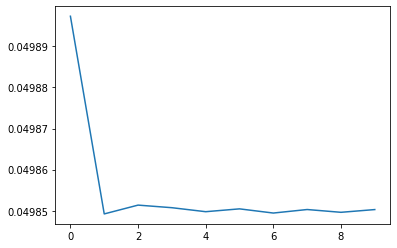

In [ ]:
from matplotlib import pylab as plt
plt.plot(epochs,rmse)

In [ ]:
tournament_data['data_type'].unique()

array(['validation', 'test', 'live'], dtype=object)

In [ ]:
# Predict using tournament datant
predict_data = tournament_data[feature_names]
predictions = regressor_model.predict(predict_data[tournament_data.data_type=='live'])
#df = tournament_data["prediction_kazutsugi"]
#df.columns = ["id", "prediction_kazutsugi"]

In [ ]:
predict_data[tournament_data.data_type=='live']

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,...,feature_wisdom7,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46
1644415,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.50,0.50,0.00,0.25,0.25,0.75,0.00,0.75,0.50,0.50,1.00,0.50,0.75,0.50,0.25,0.50,0.75,0.50,0.50,0.50,0.75,0.25,0.25,0.25,0.50,0.50,0.75,0.75,0.50,0.25,0.75,0.50,...,1.0,1.00,1.00,1.00,0.50,1.00,0.75,0.50,1.00,0.25,0.00,0.50,1.00,0.50,1.00,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.00,0.25,0.75,1.00,0.75,0.50,0.50,0.75,1.00,0.75,0.75,0.75,0.75,0.75,1.00,1.00,0.25,1.00
1644416,0.25,0.75,0.75,0.50,0.50,0.50,0.75,0.75,0.75,0.75,0.75,0.50,0.25,0.50,0.50,0.50,0.00,0.75,0.50,0.50,0.75,0.75,0.25,0.25,0.25,0.50,0.50,0.50,0.50,0.00,0.50,0.50,1.00,1.00,0.50,0.50,0.75,0.25,0.00,1.00,...,1.0,0.25,0.75,0.00,0.50,0.75,0.75,0.50,0.50,0.50,0.00,0.75,0.00,0.50,0.75,0.75,0.75,0.50,0.75,0.50,0.50,0.75,0.00,0.50,0.75,0.75,0.50,0.75,0.50,0.50,0.75,0.75,0.75,0.00,0.00,0.75,0.75,0.00,0.50,0.75
1644417,0.00,0.50,0.75,0.50,1.00,0.50,0.50,0.50,0.25,0.50,0.50,0.75,0.25,0.50,0.75,0.00,0.75,0.75,0.50,0.25,1.00,0.50,1.00,0.50,0.00,0.75,0.25,0.50,0.00,0.75,0.25,0.75,0.75,0.25,0.00,0.50,0.25,0.75,0.25,0.75,...,0.5,0.50,0.00,0.25,0.75,0.50,0.75,0.50,0.50,0.75,0.50,1.00,0.25,0.50,1.00,0.00,0.25,0.50,0.75,0.75,0.50,0.75,0.50,0.75,0.25,0.50,0.25,0.25,0.50,0.50,0.50,0.50,0.25,0.75,0.75,0.25,0.25,0.50,0.75,0.50
1644418,0.00,0.00,0.00,0.25,1.00,0.75,0.75,0.25,0.25,0.50,0.25,1.00,0.00,1.00,0.75,0.50,0.25,0.25,0.50,0.50,0.25,0.75,1.00,0.75,0.50,0.75,0.50,0.50,0.50,0.00,0.00,0.75,0.25,0.25,0.00,0.75,1.00,0.00,1.00,0.75,...,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.75,0.75,0.50,1.00,1.00,1.00,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00
1644419,0.50,0.25,0.25,0.00,0.25,0.50,0.50,0.00,0.75,0.75,0.25,0.25,0.75,0.50,0.50,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.50,0.75,0.25,0.25,0.50,0.50,0.25,0.50,0.50,0.00,0.25,0.50,0.25,0.25,0.75,0.75,0.50,0.25,...,0.5,0.25,0.50,0.25,0.25,0.50,0.50,0.50,0.50,0.75,0.00,0.25,0.00,0.50,0.25,0.25,0.50,0.25,0.50,0.00,0.50,0.50,0.00,0.75,0.25,0.25,0.00,0.50,0.50,0.50,0.25,0.50,0.25,0.25,0.25,0.25,0.25,0.25,0.75,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649770,1.00,1.00,1.00,0.75,1.00,0.50,0.50,1.00,0.75,0.75,0.50,1.00,1.00,0.50,1.00,0.50,0.75,0.50,0.50,0.50,0.00,0.25,0.50,1.00,0.50,1.00,0.50,0.

# Train NN on full dataset (3 random eras) with optimal parameters

## Build model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

# Define model with optimized parameters

def build_model(layer_size,learning_rate, momentum=0):
    """Build Keras model"""
    model = keras.Sequential([
      layers.Dense(layer_size, activation='relu',
                   input_shape=[len(feature_names)]),
      layers.Dense(layer_size, activation='relu', kernel_regularizer='l2'),
      layers.Dense(1, activation='sigmoid')
    ])
    optimizer = SGD(lr=learning_rate, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model
    
def train_model(model, feature, label, epochs, batch_size):
    """Train Keras Model"""
    history = model.fit(x=feature,
                        y=label,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mse"]
    return epochs, mse

def score(df):
    """Ranks Predictions and returns correlation"""
    pct_ranks = df['prediction'].rank(pct=True, method="first")
    targets = df['target']
    return np.corrcoef(targets, pct_ranks)[0, 1]

# Paramters optimized in a past grid search (should be redone eventually)
lr = 5e-5
layer_size = 5
epochs = 10
batch_size = 10
nn_model = KerasClassifier(build_model,epochs=epochs, batch_size=batch_size,learning_rate=lr, layer_size=layer_size)


## Train on subset (to conserve memory/computation time)

In [ ]:
# Train nn_model on subset to conserve memory

import random
feature_names = training_data.columns[training_data.columns.str.startswith('feature')]

reduced_training_data = training_data.sample(n=100000)

X_train = reduced_training_data[feature_names]
y_train = reduced_training_data['target']
X_test = validation_data[feature_names]
y_test = validation_data['target']

epochs, rmse = train_model(nn_model, X_train, y_train,epochs=10,batch_size=10)

## Evaluate model on tournament test data

In [ ]:
# Evaluate model
def RankCorrelationScore(Y_True, Y_Pred):
    """
    Inputs: Y_True (array-like) True targets
            Y_Pred (DataFrame) Predicted targets (should have an era column)
    """
    # Rank-correlation by era
    #ranked_pred = Y_Pred.groupby('era').apply(lambda x: x['Prediction'].rank(pct=True, method="first")).values
    ranked_pred = Y_Pred['Prediction'].rank(pct=True, method="first",ascending=False)
    print(ranked_pred)
    return np.corrcoef(np.ravel(Y_True), ranked_pred)[0,1]

results = nn_model.predict(X_test)

results = pd.DataFrame(results,columns=['Prediction'])
results['era'] = validation_data['era']

corr = np.corrcoef(y_test,results.Prediction)[0][1]
print(corr)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
np.mean(results.Prediction)

0.2499

In [ ]:
y_test.shape

(137779,)

In [ ]:
y_test.head()

0    0.25
1    0.50
2    1.00
3    0.50
4    0.75
Name: target, dtype: float16

In [ ]:
live_data = tournament_data
feature_cols = tournament_data.columns[tournament_data.columns.str.startswith('feature')]
live_features = live_data[feature_cols]
feature_mean = np.mean(live_features.values,axis=1)
feature_std = np.std(live_features.values,axis=1)
feature_median = np.median(live_features.values,axis=1)

new_cols = {'feature_mean': feature_mean,
            'feature_std': feature_std,
            'feature_median': feature_median}
df = pd.DataFrame(new_cols)
live_features = pd.concat([live_features,df],axis=1)

X = live_features
predictions = nn_model.predict(X)
predictions_df = tournament_data.id.to_frame()
predictions_df["prediction_kazutsugi"] = predictions

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ValueError: ignored

In [ ]:
predictions_df = tournament_data.id.to_frame()
predictions_df["prediction_kazutsugi"] = predictions

# Build model with XGBoost

In [ ]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings('ignore')

def reduce_training_data(df,sample_size):
  # Take a random subsample to reduce RAM useage and prevent from crashing
  feature_names = df.columns[df.columns.str.startswith('feature')]
  reduced_training_data = df.sample(n=sample_size)
  X_train = reduced_training_data[feature_names]
  y_train = reduced_training_data['target']

  return [X_train, y_train]



In [ ]:
# Parameter optimization
[X_train, y_train] = reduce_training_data(training_data,1000)
model = XGBClassifier(verbosity=0)
# Use grid search
from sklearn.model_selection import GridSearchCV
learning_rate = [0.005]
n_estimators = [300]
max_depth = [5]
min_child_weight = [5]
colsample_bytree = [0.1]
subsample = [.7]
objective = ['reg:squarederror']
param_grid = dict(max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,
                  min_child_weight=min_child_weight,
                  colsample_bytree=colsample_bytree,
                  objective=objective,
                  subsample=subsample)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=3,
                    verbose=2,
                    n_jobs=-1)
[X_train, y_train] = reduce_training_data(training_data,10000)
%time grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.hist()

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.5s finished


CPU times: user 34.1 s, sys: 125 ms, total: 34.2 s
Wall time: 1min 28s
Best: 0.497700 using {'colsample_bytree': 0.1, 'learning_rate': 0.005, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.7}
0.497700 (0.000070) with: {'colsample_bytree': 0.1, 'learning_rate': 0.005, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.7}


## Train on random subsamples

In [ ]:
 import pickle

params={'max_depth':3,
        'learning_rate':0.005,
        'n_estimators':1000,
        'n_jobs':-1,
        'colsample_bytree':0.1,
        'verbosity':0,
        'subsample':0.7,
        'min_child_weight':5}
model_1 = XGBRegressor(**params)
[X_train, y_train] = reduce_training_data(training_data,100000)

print(f'Training model 1')
%time model_1.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_1_orig.pkl'
pickle.dump(model_1, open(fn, 'wb'))

print(f'--------------------')
model_2 = XGBRegressor(**params)
[X_train, y_train] = reduce_training_data(training_data,100000)
print(f'Training model 2')
%time model_2.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_2_orig.pkl'
pickle.dump(model_2, open(fn, 'wb'))

print(f'--------------------')
model_3 = XGBRegressor(**params)
[X_train, y_train] = reduce_training_data(training_data,100000)
print(f'Training model 3')
%time model_3.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_3_orig.pkl'
pickle.dump(model_3, open(fn, 'wb'))

print(f'--------------------')
model_4 = XGBRegressor(**params)
[X_train, y_train] = reduce_training_data(training_data,100000)
print(f'Training model 4')
%time model_4.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_4_orig.pkl'
pickle.dump(model_4, open(fn, 'wb'))

print(f'--------------------')
model_5 = XGBRegressor(**params)
[X_train, y_train] = reduce_training_data(training_data,100000)
print(f'Training model 5')
%time model_5.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_5_orig.pkl'
pickle.dump(model_5, open(fn, 'wb'))

print(f'--------------------')

feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]

X_test = validation_data[feature_names]
y_test = validation_data['target']
y_pred = model_1.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_2.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_3.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_4.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_5.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])


Training model 1
CPU times: user 5min 9s, sys: 179 ms, total: 5min 9s
Wall time: 2min 37s
--------------------
Training model 2
CPU times: user 5min 10s, sys: 334 ms, total: 5min 10s
Wall time: 2min 37s
--------------------
Training model 3
CPU times: user 5min 13s, sys: 373 ms, total: 5min 13s
Wall time: 2min 39s
--------------------
Training model 4
CPU times: user 5min 14s, sys: 342 ms, total: 5min 14s
Wall time: 2min 40s
--------------------
Training model 5
CPU times: user 5min 11s, sys: 327 ms, total: 5min 12s
Wall time: 2min 38s
--------------------
0.018522246586528672
0.015522633600232899
0.01564066260540059
0.014307732503491887
0.014219013698661149


In [ ]:

validation_data = live_data[live_data['data_type']=='validation']
feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]

X_test = validation_data[feature_names]
y_test = validation_data['target']
y_pred = model_1.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_2.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_3.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_4.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_5.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

0.012833057257615946
0.018714077506072336
0.015561898734488298
0.013439109020416005
0.016754362803006764


## Train on blocks of eras

In [ ]:
CURRENT_DATASET

272

In [ ]:
# Sample based on eras
import pickle

def select_eras(df,chunk):
  # Pull data from a range of eras
  feature_names = df.columns[df.columns.str.startswith('feature')]
  era_list = df.era.unique()
  if chunk==1:
    reduced_training_data = df[df.era.isin(era_list[0:23])]
  if chunk==2:
    reduced_training_data = df[df.era.isin(era_list[24:47])]
  if chunk==3:
    reduced_training_data = df[df.era.isin(era_list[48:71])]
  if chunk==4:
    reduced_training_data = df[df.era.isin(era_list[72:95])]
  if chunk==5:
    reduced_training_data = df[df.era.isin(era_list[96:120])]
  X_train = reduced_training_data[feature_names]
  y_train = reduced_training_data['target']

  return [X_train, y_train]

params={'max_depth':5,
        'learning_rate':0.005,
        'n_estimators':1000,
        'n_jobs':-1,
        'colsample_bytree':0.1,
        'verbosity':0,
        'subsample':0.7,
        'min_child_weight':5}
model_1 = XGBRegressor(**params)
[X_train, y_train] = select_eras(training_data,1)

print(f'Training model 1')
%time model_1.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_1_era_batch.pkl'
pickle.dump(model_1, open(fn, 'wb'))

print(f'--------------------')
model_2 = XGBRegressor(**params)
[X_train, y_train] = select_eras(training_data,2)
print(f'Training model 2')
%time model_2.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_2_era_batch.pkl'
pickle.dump(model_2, open(fn, 'wb'))

print(f'--------------------')
model_3 = XGBRegressor(**params)
[X_train, y_train] = select_eras(training_data,3)
print(f'Training model 3')
%time model_3.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_3_era_batch.pkl'
pickle.dump(model_3, open(fn, 'wb'))

print(f'--------------------')
model_4 = XGBRegressor(**params)
[X_train, y_train] = select_eras(training_data,4)
print(f'Training model 4')
%time model_4.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_4_era_batch.pkl'
pickle.dump(model_4, open(fn, 'wb'))

print(f'--------------------')
model_5 = XGBRegressor(**params)
[X_train, y_train] = select_eras(training_data,5)
print(f'Training model 5')
%time model_5.fit(X_train, y_train)
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/model_5_era_batch.pkl'
pickle.dump(model_5, open(fn, 'wb'))

print(f'--------------------')

feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]
X_test = validation_data[feature_names]
y_test = validation_data['target']
y_pred = model_1.predict(X_test)
import datetime
target = y_test
print(f"Correlation: {np.corrcoef(target,y_pred)[0][1]:.4f}")

y_pred = model_2.predict(X_test)
import datetime
target = y_test
print(f"Correlation: {np.corrcoef(target,y_pred)[0][1]:.4f}")

y_pred = model_3.predict(X_test)
import datetime
target = y_test
print(f"Correlation: {np.corrcoef(target,y_pred)[0][1]:.4f}")

y_pred = model_4.predict(X_test)
import datetime
target = y_test
print(f"Correlation: {np.corrcoef(target,y_pred)[0][1]:.4f}")

y_pred = model_5.predict(X_test)
import datetime
target = y_test
print(f"Correlation: {np.corrcoef(target,y_pred)[0][1]:.4f}")


Training model 1
CPU times: user 4min 17s, sys: 333 ms, total: 4min 18s
Wall time: 2min 10s
--------------------
Training model 2
CPU times: user 5min 34s, sys: 450 ms, total: 5min 34s
Wall time: 2min 50s
--------------------
Training model 3
CPU times: user 6min 17s, sys: 434 ms, total: 6min 18s
Wall time: 3min 11s
--------------------
Training model 4
CPU times: user 5min 52s, sys: 404 ms, total: 5min 52s
Wall time: 2min 58s
--------------------
Training model 5
CPU times: user 6min 24s, sys: 374 ms, total: 6min 24s
Wall time: 3min 14s
--------------------
Correlation: 0.0205
Correlation: 0.0184
Correlation: 0.0042
Correlation: 0.0220
Correlation: 0.0110


## Save model

Training model 1
CPU times: user 15.6 s, sys: 60.6 ms, total: 15.7 s
Wall time: 15.7 s


(array([3.89000e+02, 0.00000e+00, 6.63400e+03, 0.00000e+00, 0.00000e+00,
        1.28765e+05, 0.00000e+00, 1.98900e+03, 0.00000e+00, 2.00000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ],
       dtype=float16),
 <a list of 10 Patch objects>)

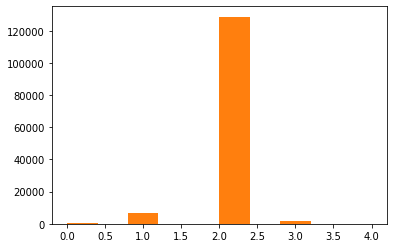

In [ ]:
params={'max_depth':5,
        'learning_rate':0.005,
        'n_estimators':1000,
        'n_jobs':-1,
        'colsample_bytree':0.1,
        'verbosity':0,
        'subsample':0.7,
        'min_child_weight':5}
model_1 = XGBClassifier(**params)
[X_train, y_train] = reduce_training_data(training_data,1000)

print(f'Training model 1')
%time model_1.fit(X_train, y_train)
pred = model_1.predict(X_test)

plt.hist(y_test)
plt.hist(pred)


(array([3.89000e+02, 0.00000e+00, 6.63400e+03, 0.00000e+00, 0.00000e+00,
        1.28765e+05, 0.00000e+00, 1.98900e+03, 0.00000e+00, 2.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float16),
 <a list of 10 Patch objects>)

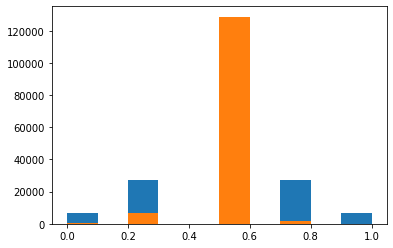

In [ ]:
plt.hist(y_test)
plt.hist(pred/4)

## Load model

In [ ]:
import pickle
CURRENT_DATASET = 268
fn=f'./drive/MyDrive/numerai/model_1_era_batch.pkl'
model_1 = pickle.load(open(fn, 'rb'))
fn=f'./drive/MyDrive/numerai/model_2_era_batch.pkl'
model_2 = pickle.load(open(fn, 'rb'))
fn=f'./drive/MyDrive/numerai/model_3_era_batch.pkl'
model_3 = pickle.load(open(fn, 'rb'))
fn=f'./drive/MyDrive/numerai/model_4_era_batch.pkl'
model_4 = pickle.load(open(fn, 'rb'))
fn=f'./drive/MyDrive/numerai/model_5_era_batch.pkl'
model_5 = pickle.load(open(fn, 'rb'))

[17:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
validation_data[]

(137779, 347)

In [ ]:
feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]
X_test = validation_data[feature_names]
y_test = validation_data['target']
y_pred = model_1.predict(X_test)
import datetime
target = y_test
#df = pd.DataFrame({'target': target,'y_pred':y_pred})
##file = f"prediction_validate_{datetime.datetime.now()}.csv"
#from google.colab import files
#df.to_csv(file) 
#files.download(file)
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_2.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_3.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_4.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_5.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

0.020526848480334217
0.018367907874089057
0.004168574522025299
0.02200116279858303
0.011019814989107915


In [ ]:
feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]
X_test = validation_data[feature_names]
y_test = validation_data['target']
y_pred = model_1.predict(X_test)
import datetime
target = y_test
#df = pd.DataFrame({'target': target,'y_pred':y_pred})
##file = f"prediction_validate_{datetime.datetime.now()}.csv"
#from google.colab import files
#df.to_csv(file) 
#files.download(file)
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_2.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_3.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_4.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

y_pred = model_5.predict(X_test)
import datetime
target = y_test
print(np.corrcoef(target,y_pred)[0][1])

0.020526848480334217
0.018367907874089057
0.004168574522025299
0.02200116279858303
0.011019814989107915


In [ ]:
#Shuffle feature columns to see how each impacts the predictive power of the dataset using given model

corr_feature_shuffle = pd.DataFrame({'feature': [], 'corr': []})
for col in X_test.columns:
  df_test = X_test
  df_test[col] = df_test[col].sample(frac=1).values
  y_pred = model_1.predict(df_test)
  target = y_test
  print(f"{col}: {np.corrcoef(target,y_pred)[0][1]}")

feature_intelligence1: 0.020739568445902738
feature_intelligence2: 0.020650802434577613
feature_intelligence3: 0.02064352481925145
feature_intelligence4: 0.020610435433604777
feature_intelligence5: 0.020830986391496383
feature_intelligence6: 0.02084608566270915
feature_intelligence7: 0.021093004133304904
feature_intelligence8: 0.021197149900119516
feature_intelligence9: 0.02112065578921669
feature_intelligence10: 0.020950099169972813
feature_intelligence11: 0.02067814271478097
feature_intelligence12: 0.020717359195872594
feature_charisma1: 0.020431017028741474
feature_charisma2: 0.020400734387295352
feature_charisma3: 0.020316896209629634
feature_charisma4: 0.02026011658939774
feature_charisma5: 0.020308788844099562
feature_charisma6: 0.02031165861048536
feature_charisma7: 0.0201719531933862
feature_charisma8: 0.02026019127394991
feature_charisma9: 0.020606698582627647
feature_charisma10: 0.020542576603101128
feature_charisma11: 0.020504974264230882
feature_charisma12: 0.02035223973346

In [ ]:
np.shape(X_test.columns)

(343,)

# Era Boosting Model

## Define functions

In [ ]:
from xgboost import XGBRegressor
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def era_boost_train(X, y, era_col, val_data, proportion=0.8, trees_per_step=10, num_iters=200):
    model = XGBRegressor(max_depth=3,
                         learning_rate=0.005,
                         n_estimators=trees_per_step,
                         n_jobs=-1,
                         colsample_bytree=0.1,
                         min_child_weight=5,
                         max_features='sqrt',
                         subsample=0.7,
                         warm_start=(num_iters>1))
    features = X.columns
    %time model.fit(X, y)
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    
    corr_time = np.array([])
    s_sharpe_time = np.array([])

    for i in range(num_iters-1):
        print(f'###############')
        print(f"Iteration {i}")
        print(f'###############')
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
        
        # Update model
        model.n_estimators += trees_per_step
        booster = model.get_booster()
        #print("fitting on worst eras")
        %time model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        import pickle
        fn = f'./drive/MyDrive/numerai/era_boosted_model_iterative.pkl'
        pickle.dump(model, open(fn, 'wb'))
    return [model, corr, s_sharpe]

def reduce_training_data(df,sample_size):
  # Take a random subsample to reduce RAM useage and prevent from crashing
  feature_names = df.columns[df.columns.str.startswith('feature')]
  reduced_training_data = df.sample(n=sample_size)
  X_train = reduced_training_data[feature_names]
  y_train = reduced_training_data['target']

  return [X_train, y_train]



## Run training

%%%%%%%%%%%%%%%
Training Model 1
%%%%%%%%%%%%%%%
[01:45:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7.37 s, sys: 11.9 ms, total: 7.38 s
Wall time: 4.1 s
###############
Iteration 0
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era91', 'era2', 'era32', 'era1', 'era93', 'era100', 'era103', 'era113', 'era68', 'era71', 'era104', 'era57', 'era6', 'era70', 'era46', 'era49', 'era74', 'era98', 'era34', 'era85', 'era62', 'era31', 'era64', 'era33', 'era41', 'era54', 'era20', 'era58', 'era101', 'era29', 'era25', 'era112', 'era67', 'era27', 'era75', 'era102', 'era106', 'era89', 'era82', 'era42', 'era73', 'era119', 'era17', 'era78', 'era87', 'era114', 'era55', 'era65', 'era28', 'era36', 'era61', 'era15', 'era50', 'era40', 'era107', 'era37', 'era99', 'era66', 'era14', 'era81', 'era80', 'era18', 'era45', 'era10', 'era22', 'era110', 'era11', 'era97', 'era8', 'era79', 'era35', 'era72', 'era111', 'era43', 'era116', 'era44', 'era94', 'era117', 'era60', 'era84', 'era30', 'era115', 'era56', 'era90', 'era4', 'era59', 'era118', 'era13', 'era26', 'era86', 'era3', 'era83', 'era52', 'era120', 'era21']
performance over time


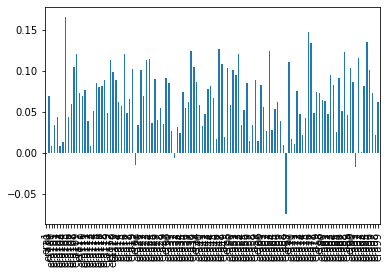

autocorrelation
-0.008120061140588141
mean correlation
0.06355924513851564
sharpe
1.6036450585679287
smart sharpe
1.6098606903099424
[01:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 8.68 s, sys: 22.9 ms, total: 8.7 s
Wall time: 4.75 s
###############
Iteration 1
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era2', 'era74', 'era20', 'era113', 'era29', 'era6', 'era33', 'era102', 'era49', 'era68', 'era32', 'era34', 'era93', 'era64', 'era1', 'era25', 'era100', 'era103', 'era106', 'era24', 'era91', 'era71', 'era98', 'era54', 'era72', 'era82', 'era58', 'era66', 'era112', 'era22', 'era119', 'era67', 'era85', 'era41', 'era70', 'era36', 'era108', 'era18', 'era27', 'era101', 'era8', 'era107', 'era15', 'era62', 'era5', 'era65', 'era12', 'era75', 'era19', 'era37', 'era87', 'era28', 'era104', 'era57', 'era45', 'era50', 'era31', 'era40', 'era97', 'era14', 'era46', 'era114', 'era61', 'era9', 'era89', 'era17', 'era95', 'era42', 'era11', 'era80', 'era53', 'era55', 'era35', 'era109', 'era78', 'era118', 'era99', 'era96', 'era30', 'era79', 'era51', 'era81', 'era23', 'era39', 'era48', 'era111', 'era110', 'era44', 'era77', 'era116', 'era26', 'era94', 'era10', 'era60', 'era43']
performance over time


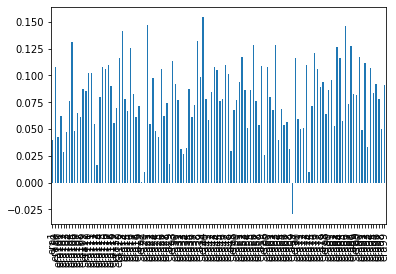

autocorrelation
-0.007593566276694203
mean correlation
0.07804119636929045
sharpe
2.301279400179967
smart sharpe
2.308993088923327
[01:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 11.4 s, sys: 19.9 ms, total: 11.4 s
Wall time: 6.1 s
###############
Iteration 2
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era20', 'era68', 'era69', 'era29', 'era91', 'era113', 'era32', 'era74', 'era93', 'era49', 'era3', 'era103', 'era119', 'era100', 'era106', 'era27', 'era34', 'era6', 'era112', 'era72', 'era102', 'era22', 'era85', 'era107', 'era117', 'era1', 'era33', 'era70', 'era58', 'era71', 'era73', 'era64', 'era19', 'era25', 'era41', 'era82', 'era17', 'era62', 'era118', 'era2', 'era18', 'era59', 'era101', 'era98', 'era12', 'era36', 'era67', 'era120', 'era75', 'era31', 'era7', 'era115', 'era90', 'era66', 'era104', 'era42', 'era60', 'era83', 'era89', 'era28', 'era54', 'era46', 'era5', 'era57', 'era8', 'era52', 'era94', 'era15', 'era37', 'era63', 'era84', 'era92', 'era40', 'era108', 'era80', 'era16', 'era116', 'era88', 'era14', 'era45', 'era114', 'era11', 'era24', 'era26', 'era47', 'era61', 'era109', 'era111', 'era79', 'era44', 'era99', 'era35', 'era38', 'era87', 'era65', 'era81']
performance over time


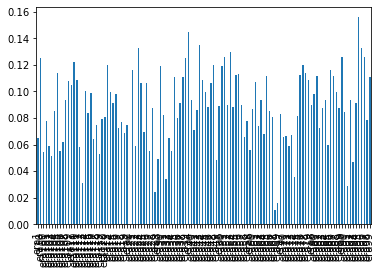

autocorrelation
0.2204637352431563
mean correlation
0.086615447365514
sharpe
2.990706188116364
smart sharpe
2.384803495171917
[01:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 14.2 s, sys: 8.88 ms, total: 14.2 s
Wall time: 7.52 s
###############
Iteration 3
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era68', 'era91', 'era20', 'era2', 'era29', 'era74', 'era32', 'era49', 'era71', 'era117', 'era107', 'era27', 'era103', 'era106', 'era34', 'era93', 'era70', 'era72', 'era113', 'era50', 'era100', 'era58', 'era25', 'era119', 'era101', 'era54', 'era62', 'era98', 'era18', 'era1', 'era82', 'era21', 'era85', 'era42', 'era104', 'era15', 'era17', 'era41', 'era33', 'era66', 'era102', 'era55', 'era78', 'era112', 'era10', 'era12', 'era59', 'era6', 'era14', 'era67', 'era73', 'era36', 'era31', 'era64', 'era48', 'era22', 'era114', 'era9', 'era60', 'era8', 'era75', 'era56', 'era99', 'era39', 'era57', 'era46', 'era97', 'era110', 'era28', 'era86', 'era51', 'era118', 'era24', 'era89', 'era87', 'era30', 'era111', 'era84', 'era76', 'era90', 'era5', 'era37', 'era26', 'era40', 'era43', 'era45', 'era108', 'era23', 'era19', 'era96', 'era61', 'era81', 'era120', 'era115', 'era11']
performance over time


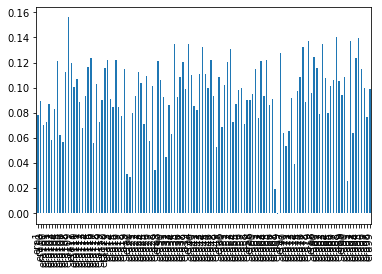

autocorrelation
0.07147548935062667
mean correlation
0.09381947202003053
sharpe
3.3227068225599785
smart sharpe
3.082056594792716
[01:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 17 s, sys: 28.8 ms, total: 17.1 s
Wall time: 9.03 s
###############
Iteration 4
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era91', 'era68', 'era20', 'era103', 'era2', 'era32', 'era29', 'era71', 'era27', 'era74', 'era49', 'era117', 'era113', 'era34', 'era107', 'era93', 'era62', 'era100', 'era98', 'era85', 'era80', 'era14', 'era101', 'era1', 'era12', 'era106', 'era104', 'era18', 'era72', 'era119', 'era58', 'era31', 'era70', 'era33', 'era118', 'era54', 'era8', 'era82', 'era50', 'era94', 'era42', 'era75', 'era25', 'era116', 'era66', 'era112', 'era97', 'era55', 'era64', 'era114', 'era41', 'era21', 'era16', 'era46', 'era36', 'era22', 'era17', 'era89', 'era65', 'era59', 'era67', 'era83', 'era52', 'era28', 'era3', 'era102', 'era73', 'era77', 'era10', 'era15', 'era5', 'era13', 'era60', 'era78', 'era57', 'era111', 'era105', 'era44', 'era9', 'era47', 'era92', 'era35', 'era63', 'era26', 'era43', 'era84', 'era110', 'era38', 'era19', 'era56', 'era99', 'era79', 'era30', 'era88', 'era90']
performance over time


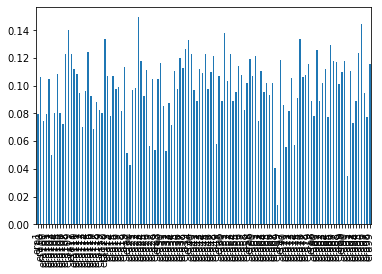

autocorrelation
0.10668004105275616
mean correlation
0.09760715835955709
sharpe
4.036301139107799
smart sharpe
3.614512925219739
[01:46:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 20 s, sys: 20.6 ms, total: 20 s
Wall time: 10.5 s
###############
Iteration 5
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era91', 'era20', 'era71', 'era68', 'era27', 'era49', 'era74', 'era34', 'era103', 'era29', 'era32', 'era2', 'era93', 'era107', 'era62', 'era106', 'era113', 'era14', 'era70', 'era119', 'era101', 'era85', 'era100', 'era1', 'era31', 'era87', 'era72', 'era118', 'era58', 'era112', 'era33', 'era117', 'era98', 'era114', 'era104', 'era11', 'era8', 'era42', 'era54', 'era40', 'era18', 'era75', 'era50', 'era94', 'era73', 'era116', 'era66', 'era45', 'era25', 'era61', 'era57', 'era80', 'era67', 'era82', 'era102', 'era37', 'era36', 'era46', 'era97', 'era64', 'era12', 'era108', 'era10', 'era48', 'era22', 'era24', 'era5', 'era6', 'era17', 'era81', 'era111', 'era41', 'era26', 'era78', 'era60', 'era65', 'era95', 'era59', 'era110', 'era7', 'era89', 'era55', 'era28', 'era115', 'era39', 'era19', 'era3', 'era21', 'era15', 'era9', 'era76', 'era99', 'era53', 'era83', 'era96']
performance over time


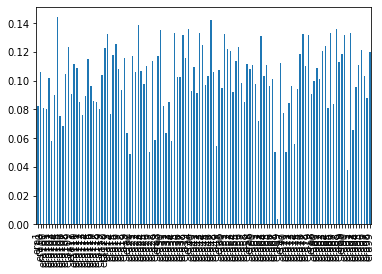

autocorrelation
0.023704801340734587
mean correlation
0.10038965951707063
sharpe
3.994411603055023
smart sharpe
3.88530157954617
[01:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 22.8 s, sys: 27.7 ms, total: 22.8 s
Wall time: 11.9 s
###############
Iteration 6
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era91', 'era68', 'era27', 'era34', 'era29', 'era71', 'era20', 'era74', 'era49', 'era62', 'era103', 'era2', 'era93', 'era113', 'era32', 'era85', 'era106', 'era107', 'era72', 'era100', 'era33', 'era1', 'era119', 'era14', 'era70', 'era31', 'era54', 'era112', 'era98', 'era117', 'era58', 'era101', 'era118', 'era114', 'era42', 'era75', 'era12', 'era50', 'era25', 'era40', 'era5', 'era8', 'era73', 'era87', 'era52', 'era104', 'era80', 'era94', 'era18', 'era36', 'era66', 'era84', 'era46', 'era90', 'era45', 'era57', 'era120', 'era37', 'era44', 'era102', 'era22', 'era82', 'era35', 'era78', 'era13', 'era11', 'era43', 'era55', 'era64', 'era116', 'era19', 'era67', 'era111', 'era15', 'era79', 'era59', 'era97', 'era41', 'era6', 'era17', 'era10', 'era30', 'era47', 'era3', 'era92', 'era60', 'era24', 'era89', 'era26', 'era99', 'era7', 'era88', 'era28', 'era77', 'era108']
performance over time


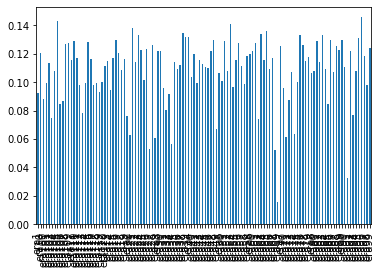

autocorrelation
0.05258558558601743
mean correlation
0.10779066496375861
sharpe
4.659995695822894
smart sharpe
4.404540252121214
[01:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 25.8 s, sys: 34.6 ms, total: 25.8 s
Wall time: 13.4 s
###############
Iteration 7
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era91', 'era68', 'era27', 'era29', 'era34', 'era20', 'era71', 'era49', 'era2', 'era93', 'era32', 'era74', 'era1', 'era113', 'era103', 'era62', 'era107', 'era85', 'era72', 'era33', 'era31', 'era100', 'era106', 'era101', 'era25', 'era54', 'era87', 'era70', 'era58', 'era9', 'era42', 'era119', 'era50', 'era18', 'era98', 'era117', 'era12', 'era114', 'era46', 'era14', 'era112', 'era66', 'era65', 'era81', 'era116', 'era61', 'era57', 'era26', 'era104', 'era75', 'era39', 'era82', 'era16', 'era118', 'era94', 'era56', 'era36', 'era110', 'era5', 'era45', 'era48', 'era80', 'era40', 'era115', 'era64', 'era102', 'era8', 'era111', 'era59', 'era22', 'era17', 'era41', 'era67', 'era4', 'era63', 'era83', 'era89', 'era13', 'era120', 'era6', 'era51', 'era109', 'era21', 'era73', 'era28', 'era76', 'era15', 'era10', 'era86', 'era43', 'era44', 'era19', 'era55', 'era60', 'era38']
performance over time


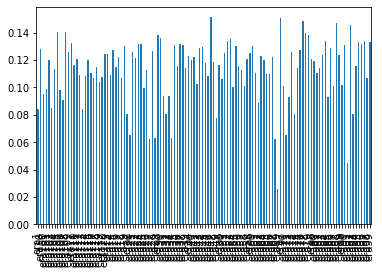

autocorrelation
-0.037569499589430004
mean correlation
0.11288859277461388
sharpe
5.0397115274734094
smart sharpe
5.209263516507185
[01:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 29.2 s, sys: 39.5 ms, total: 29.2 s
Wall time: 15.2 s
###############
Iteration 8
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era91', 'era68', 'era34', 'era20', 'era29', 'era27', 'era49', 'era74', 'era2', 'era71', 'era113', 'era103', 'era32', 'era93', 'era33', 'era119', 'era1', 'era85', 'era31', 'era107', 'era62', 'era90', 'era25', 'era42', 'era117', 'era97', 'era35', 'era100', 'era87', 'era79', 'era12', 'era58', 'era116', 'era84', 'era22', 'era24', 'era78', 'era99', 'era66', 'era72', 'era8', 'era98', 'era80', 'era54', 'era50', 'era70', 'era101', 'era75', 'era9', 'era18', 'era108', 'era106', 'era11', 'era112', 'era95', 'era46', 'era14', 'era81', 'era104', 'era102', 'era36', 'era114', 'era40', 'era64', 'era61', 'era45', 'era89', 'era67', 'era37', 'era52', 'era28', 'era111', 'era118', 'era23', 'era26', 'era39', 'era30', 'era82', 'era5', 'era59', 'era17', 'era41', 'era21', 'era110', 'era88', 'era7', 'era94', 'era96', 'era57', 'era3', 'era44', 'era55', 'era73', 'era105', 'era53']
performance over time


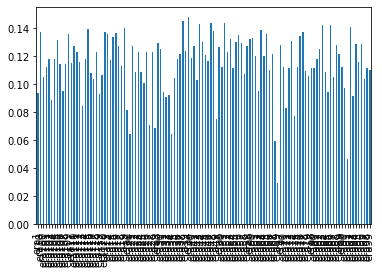

autocorrelation
0.055513621387133776
mean correlation
0.11458687705704415
sharpe
5.345349808739823
smart sharpe
5.037633201313827
[01:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 32.4 s, sys: 44.5 ms, total: 32.5 s
Wall time: 16.9 s
###############
Iteration 9
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era91', 'era68', 'era34', 'era27', 'era71', 'era74', 'era29', 'era20', 'era49', 'era113', 'era2', 'era33', 'era32', 'era107', 'era31', 'era85', 'era1', 'era93', 'era103', 'era62', 'era54', 'era119', 'era35', 'era42', 'era72', 'era25', 'era117', 'era58', 'era12', 'era9', 'era15', 'era97', 'era65', 'era46', 'era87', 'era60', 'era36', 'era100', 'era101', 'era19', 'era18', 'era106', 'era90', 'era98', 'era50', 'era16', 'era8', 'era75', 'era45', 'era84', 'era24', 'era66', 'era67', 'era56', 'era80', 'era99', 'era17', 'era70', 'era115', 'era59', 'era102', 'era118', 'era112', 'era89', 'era82', 'era104', 'era116', 'era43', 'era114', 'era78', 'era77', 'era26', 'era79', 'era81', 'era22', 'era6', 'era5', 'era76', 'era48', 'era64', 'era30', 'era37', 'era21', 'era108', 'era41', 'era120', 'era11', 'era28', 'era14', 'era40', 'era109', 'era10', 'era57', 'era63', 'era83']
performance over time


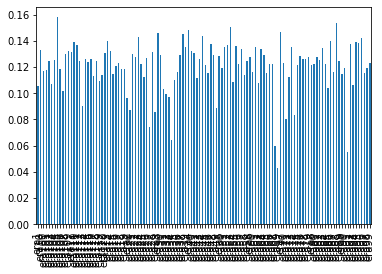

autocorrelation
0.08304254721864399
mean correlation
0.12047650236182049
sharpe
6.21794948678118
smart sharpe
5.701442116768755
[01:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 35.4 s, sys: 34.5 ms, total: 35.4 s
Wall time: 18.3 s
###############
Iteration 10
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era68', 'era91', 'era34', 'era29', 'era71', 'era27', 'era20', 'era49', 'era74', 'era113', 'era2', 'era33', 'era1', 'era85', 'era107', 'era62', 'era31', 'era93', 'era119', 'era32', 'era25', 'era42', 'era100', 'era54', 'era35', 'era117', 'era103', 'era9', 'era15', 'era72', 'era58', 'era36', 'era98', 'era73', 'era97', 'era39', 'era50', 'era60', 'era101', 'era111', 'era106', 'era8', 'era70', 'era7', 'era75', 'era87', 'era59', 'era80', 'era46', 'era61', 'era22', 'era19', 'era90', 'era67', 'era51', 'era110', 'era28', 'era96', 'era94', 'era52', 'era55', 'era77', 'era24', 'era44', 'era17', 'era18', 'era66', 'era12', 'era118', 'era112', 'era89', 'era99', 'era45', 'era116', 'era14', 'era47', 'era82', 'era23', 'era104', 'era102', 'era84', 'era92', 'era65', 'era108', 'era114', 'era40', 'era5', 'era6', 'era13', 'era64', 'era76', 'era115', 'era81', 'era26', 'era41']
performance over time


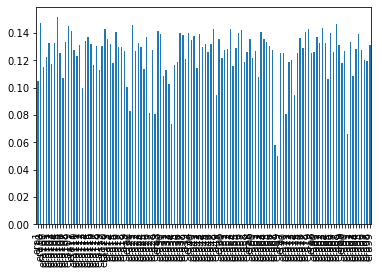

autocorrelation
0.11483681515124868
mean correlation
0.12414863593548708
sharpe
6.765844390639472
smart sharpe
6.0094185674981055
[01:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 38.8 s, sys: 46.5 ms, total: 38.9 s
Wall time: 20.1 s
###############
Iteration 11
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era68', 'era34', 'era91', 'era27', 'era29', 'era71', 'era20', 'era74', 'era49', 'era113', 'era33', 'era85', 'era93', 'era2', 'era31', 'era62', 'era32', 'era107', 'era42', 'era1', 'era25', 'era9', 'era100', 'era103', 'era98', 'era36', 'era117', 'era54', 'era72', 'era119', 'era15', 'era43', 'era57', 'era58', 'era101', 'era50', 'era56', 'era70', 'era79', 'era73', 'era46', 'era60', 'era80', 'era17', 'era35', 'era61', 'era75', 'era37', 'era67', 'era19', 'era30', 'era66', 'era111', 'era63', 'era7', 'era106', 'era45', 'era21', 'era22', 'era59', 'era90', 'era4', 'era12', 'era10', 'era120', 'era8', 'era38', 'era24', 'era110', 'era3', 'era95', 'era83', 'era97', 'era28', 'era87', 'era55', 'era11', 'era118', 'era39', 'era114', 'era78', 'era104', 'era14', 'era94', 'era86', 'era26', 'era48', 'era18', 'era112', 'era16', 'era89', 'era82', 'era76', 'era96', 'era102']
performance over time


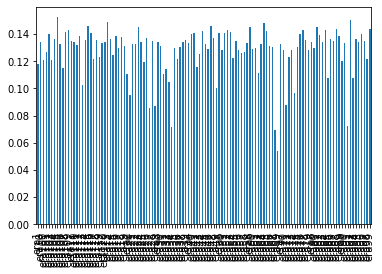

autocorrelation
0.11379467360719836
mean correlation
0.1280245395214884
sharpe
7.375898980542071
smart sharpe
6.558130709614453
[01:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 42.2 s, sys: 45.6 ms, total: 42.2 s
Wall time: 21.8 s
###############
Iteration 12
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era68', 'era34', 'era29', 'era91', 'era27', 'era71', 'era20', 'era49', 'era113', 'era33', 'era74', 'era1', 'era62', 'era31', 'era85', 'era93', 'era2', 'era103', 'era100', 'era32', 'era42', 'era5', 'era36', 'era9', 'era54', 'era15', 'era40', 'era115', 'era41', 'era116', 'era98', 'era65', 'era25', 'era50', 'era51', 'era72', 'era22', 'era107', 'era59', 'era81', 'era99', 'era84', 'era44', 'era88', 'era57', 'era6', 'era101', 'era12', 'era111', 'era117', 'era28', 'era19', 'era30', 'era70', 'era108', 'era26', 'era119', 'era58', 'era43', 'era75', 'era53', 'era89', 'era46', 'era35', 'era80', 'era77', 'era66', 'era18', 'era109', 'era79', 'era97', 'era13', 'era114', 'era73', 'era106', 'era11', 'era39', 'era52', 'era3', 'era55', 'era56', 'era45', 'era17', 'era64', 'era118', 'era61', 'era23', 'era102', 'era82', 'era60', 'era83', 'era14', 'era67', 'era104', 'era105']
performance over time


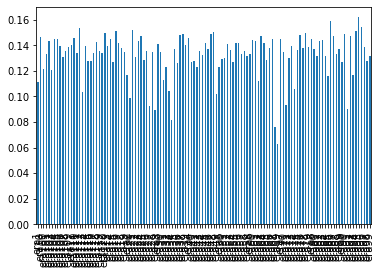

autocorrelation
0.06534289857255539
mean correlation
0.1326490167358359
sharpe
7.7703678334258095
smart sharpe
7.251761474580547
[01:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 46 s, sys: 50.4 ms, total: 46 s
Wall time: 23.7 s
###############
Iteration 13
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era68', 'era34', 'era29', 'era71', 'era91', 'era27', 'era74', 'era20', 'era49', 'era33', 'era113', 'era85', 'era31', 'era62', 'era93', 'era32', 'era36', 'era78', 'era87', 'era42', 'era8', 'era5', 'era110', 'era107', 'era103', 'era98', 'era2', 'era1', 'era24', 'era100', 'era72', 'era112', 'era101', 'era40', 'era63', 'era15', 'era25', 'era9', 'era10', 'era22', 'era117', 'era58', 'era48', 'era7', 'era50', 'era76', 'era111', 'era70', 'era116', 'era120', 'era54', 'era18', 'era28', 'era37', 'era46', 'era94', 'era47', 'era99', 'era41', 'era57', 'era80', 'era59', 'era26', 'era90', 'era81', 'era4', 'era75', 'era102', 'era64', 'era61', 'era35', 'era65', 'era119', 'era84', 'era106', 'era73', 'era12', 'era92', 'era114', 'era21', 'era44', 'era86', 'era97', 'era38', 'era118', 'era108', 'era11', 'era115', 'era82', 'era95', 'era43', 'era66', 'era45', 'era51', 'era14']
performance over time


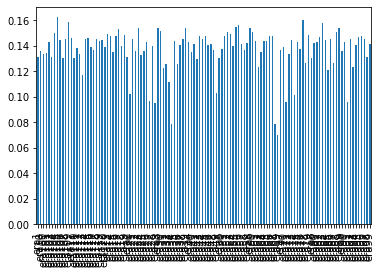

autocorrelation
0.15413298011960214
mean correlation
0.13710380418856244
sharpe
8.233667642003411
smart sharpe
7.02864266141307
[01:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 49.6 s, sys: 56.5 ms, total: 49.6 s
Wall time: 25.5 s
###############
Iteration 14
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era68', 'era34', 'era29', 'era27', 'era91', 'era49', 'era71', 'era74', 'era20', 'era33', 'era113', 'era31', 'era62', 'era19', 'era5', 'era89', 'era85', 'era32', 'era93', 'era79', 'era60', 'era17', 'era67', 'era54', 'era104', 'era101', 'era88', 'era15', 'era55', 'era103', 'era8', 'era59', 'era36', 'era100', 'era98', 'era3', 'era22', 'era30', 'era6', 'era1', 'era110', 'era46', 'era78', 'era2', 'era16', 'era112', 'era72', 'era109', 'era41', 'era25', 'era96', 'era50', 'era40', 'era53', 'era35', 'era42', 'era107', 'era58', 'era56', 'era28', 'era75', 'era12', 'era24', 'era57', 'era52', 'era83', 'era94', 'era45', 'era18', 'era80', 'era117', 'era7', 'era90', 'era9', 'era102', 'era99', 'era43', 'era39', 'era81', 'era37', 'era115', 'era87', 'era111', 'era106', 'era119', 'era120', 'era21', 'era116', 'era73', 'era77', 'era23', 'era82', 'era26', 'era51', 'era84']
performance over time


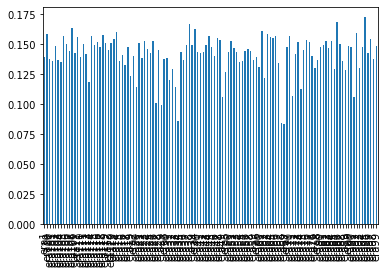

autocorrelation
0.12450093729814923
mean correlation
0.1415325132353719
sharpe
8.62833525410744
smart sharpe
7.58954887288511
[01:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 52.7 s, sys: 49.4 ms, total: 52.7 s
Wall time: 27.2 s
###############
Iteration 15
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era68', 'era29', 'era71', 'era27', 'era49', 'era20', 'era74', 'era33', 'era91', 'era5', 'era113', 'era93', 'era62', 'era31', 'era85', 'era32', 'era114', 'era97', 'era64', 'era42', 'era36', 'era48', 'era10', 'era118', 'era66', 'era19', 'era101', 'era25', 'era76', 'era78', 'era98', 'era63', 'era70', 'era108', 'era13', 'era8', 'era67', 'era28', 'era105', 'era103', 'era61', 'era65', 'era100', 'era11', 'era9', 'era87', 'era44', 'era1', 'era2', 'era22', 'era39', 'era110', 'era50', 'era104', 'era24', 'era107', 'era79', 'era17', 'era58', 'era14', 'era75', 'era89', 'era59', 'era18', 'era40', 'era112', 'era60', 'era72', 'era47', 'era41', 'era54', 'era92', 'era6', 'era117', 'era53', 'era16', 'era45', 'era95', 'era111', 'era30', 'era3', 'era57', 'era81', 'era26', 'era55', 'era4', 'era15', 'era102', 'era37', 'era12', 'era115', 'era38', 'era46', 'era35']
performance over time


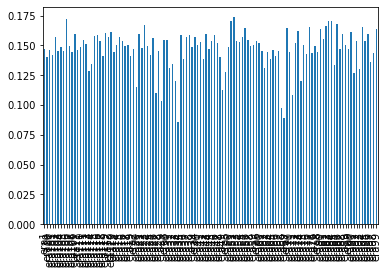

autocorrelation
0.13960317810855905
mean correlation
0.1473081344103676
sharpe
9.182444109273558
smart sharpe
7.9548064949015185
[01:51:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 56.3 s, sys: 47.5 ms, total: 56.3 s
Wall time: 29 s
###############
Iteration 16
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era68', 'era29', 'era71', 'era49', 'era27', 'era33', 'era74', 'era20', 'era113', 'era5', 'era91', 'era31', 'era62', 'era85', 'era93', 'era19', 'era119', 'era90', 'era80', 'era109', 'era32', 'era101', 'era28', 'era25', 'era36', 'era43', 'era116', 'era17', 'era42', 'era120', 'era88', 'era21', 'era64', 'era73', 'era103', 'era98', 'era60', 'era100', 'era89', 'era97', 'era7', 'era114', 'era78', 'era75', 'era110', 'era99', 'era14', 'era1', 'era9', 'era83', 'era96', 'era106', 'era94', 'era70', 'era22', 'era104', 'era82', 'era8', 'era6', 'era59', 'era66', 'era2', 'era23', 'era65', 'era56', 'era11', 'era61', 'era118', 'era54', 'era67', 'era76', 'era46', 'era45', 'era108', 'era51', 'era72', 'era77', 'era40', 'era13', 'era50', 'era117', 'era107', 'era58', 'era24', 'era15', 'era30', 'era10', 'era48', 'era3', 'era111', 'era39', 'era112', 'era18', 'era79']
performance over time


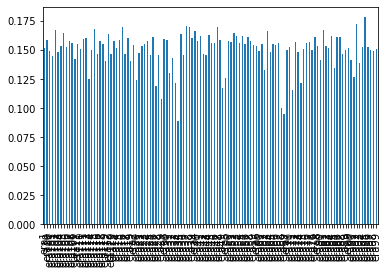

autocorrelation
0.11710955508479648
mean correlation
0.15047983182543803
sharpe
9.792862249142424
smart sharpe
8.678170555979944
[01:51:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min, sys: 59.5 ms, total: 1min
Wall time: 30.9 s
###############
Iteration 17
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era68', 'era29', 'era71', 'era27', 'era33', 'era49', 'era5', 'era20', 'era74', 'era31', 'era91', 'era113', 'era62', 'era32', 'era85', 'era35', 'era93', 'era41', 'era19', 'era87', 'era42', 'era116', 'era12', 'era80', 'era57', 'era28', 'era63', 'era81', 'era101', 'era26', 'era44', 'era114', 'era119', 'era9', 'era98', 'era25', 'era103', 'era36', 'era109', 'era43', 'era100', 'era17', 'era97', 'era1', 'era55', 'era2', 'era14', 'era16', 'era4', 'era7', 'era53', 'era115', 'era72', 'era64', 'era105', 'era45', 'era59', 'era21', 'era60', 'era78', 'era37', 'era89', 'era75', 'era90', 'era54', 'era102', 'era6', 'era47', 'era120', 'era66', 'era84', 'era86', 'era46', 'era23', 'era70', 'era76', 'era73', 'era10', 'era65', 'era83', 'era56', 'era22', 'era99', 'era88', 'era52', 'era8', 'era48', 'era82', 'era117', 'era118', 'era50', 'era108', 'era30', 'era58']
performance over time


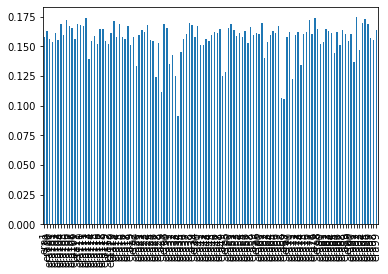

autocorrelation
0.2393325589094742
mean correlation
0.15631646534785767
sharpe
10.716267102836152
smart sharpe
8.378198071672243
[01:52:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 4s, sys: 72.5 ms, total: 1min 4s
Wall time: 33 s
###############
Iteration 18
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era69', 'era34', 'era68', 'era29', 'era71', 'era27', 'era33', 'era49', 'era62', 'era20', 'era5', 'era31', 'era74', 'era32', 'era18', 'era110', 'era91', 'era85', 'era113', 'era111', 'era93', 'era107', 'era15', 'era67', 'era106', 'era40', 'era12', 'era28', 'era42', 'era35', 'era26', 'era41', 'era101', 'era24', 'era96', 'era70', 'era39', 'era11', 'era9', 'era104', 'era36', 'era57', 'era2', 'era61', 'era98', 'era73', 'era114', 'era119', 'era87', 'era25', 'era3', 'era77', 'era19', 'era72', 'era8', 'era112', 'era1', 'era4', 'era37', 'era95', 'era13', 'era51', 'era17', 'era103', 'era94', 'era60', 'era100', 'era81', 'era64', 'era78', 'era44', 'era116', 'era6', 'era63', 'era38', 'era65', 'era50', 'era7', 'era80', 'era117', 'era109', 'era120', 'era43', 'era22', 'era58', 'era75', 'era118', 'era55', 'era10', 'era46', 'era89', 'era97', 'era102', 'era14', 'era59', 'era53']
performance over time


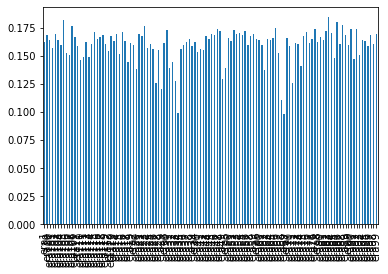

autocorrelation
0.27537689410148175
mean correlation
0.1597037822620385
sharpe
10.751418004464098
smart sharpe
8.09033505853435
[01:53:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 8s, sys: 75.8 ms, total: 1min 8s
Wall time: 35 s
###############
Iteration 19
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era68', 'era29', 'era33', 'era5', 'era71', 'era49', 'era27', 'era62', 'era31', 'era20', 'era113', 'era74', 'era32', 'era15', 'era91', 'era18', 'era54', 'era1', 'era111', 'era45', 'era30', 'era93', 'era79', 'era28', 'era21', 'era85', 'era99', 'era76', 'era35', 'era90', 'era41', 'era92', 'era42', 'era88', 'era82', 'era16', 'era40', 'era116', 'era114', 'era89', 'era110', 'era67', 'era66', 'era12', 'era115', 'era9', 'era23', 'era19', 'era56', 'era24', 'era100', 'era48', 'era98', 'era101', 'era8', 'era81', 'era39', 'era78', 'era25', 'era57', 'era3', 'era26', 'era105', 'era103', 'era2', 'era61', 'era11', 'era52', 'era107', 'era6', 'era84', 'era119', 'era37', 'era22', 'era87', 'era17', 'era72', 'era108', 'era36', 'era102', 'era106', 'era44', 'era77', 'era104', 'era75', 'era47', 'era63', 'era83', 'era80', 'era112', 'era64', 'era4', 'era59', 'era70']
performance over time


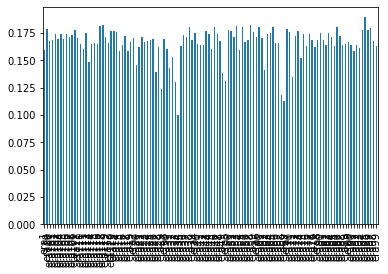

autocorrelation
0.28292938942295665
mean correlation
0.16591093538320162
sharpe
11.447029742620796
smart sharpe
8.544195372507717
[01:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 12s, sys: 61.3 ms, total: 1min 12s
Wall time: 37.1 s
###############
Iteration 20
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era68', 'era29', 'era33', 'era71', 'era49', 'era27', 'era5', 'era62', 'era31', 'era20', 'era14', 'era113', 'era74', 'era9', 'era50', 'era93', 'era18', 'era32', 'era15', 'era51', 'era28', 'era85', 'era91', 'era96', 'era40', 'era1', 'era45', 'era111', 'era21', 'era117', 'era10', 'era41', 'era58', 'era26', 'era110', 'era55', 'era65', 'era73', 'era120', 'era46', 'era67', 'era60', 'era43', 'era25', 'era54', 'era86', 'era101', 'era13', 'era4', 'era7', 'era107', 'era12', 'era17', 'era38', 'era57', 'era97', 'era24', 'era76', 'era94', 'era30', 'era114', 'era56', 'era100', 'era42', 'era53', 'era118', 'era99', 'era116', 'era39', 'era6', 'era23', 'era19', 'era103', 'era72', 'era70', 'era37', 'era82', 'era81', 'era66', 'era78', 'era75', 'era2', 'era90', 'era115', 'era16', 'era108', 'era109', 'era11', 'era98', 'era106', 'era104', 'era48', 'era36', 'era89']
performance over time


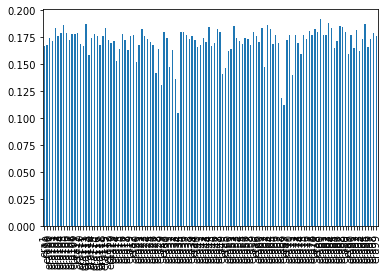

autocorrelation
0.2506611465855662
mean correlation
0.17064028234374065
sharpe
11.773311254718038
smart sharpe
9.095381855856317
[01:54:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 16s, sys: 83.3 ms, total: 1min 16s
Wall time: 39.3 s
###############
Iteration 21
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era68', 'era69', 'era33', 'era29', 'era49', 'era5', 'era27', 'era31', 'era20', 'era71', 'era62', 'era74', 'era113', 'era79', 'era14', 'era119', 'era102', 'era9', 'era85', 'era28', 'era32', 'era8', 'era77', 'era59', 'era35', 'era64', 'era91', 'era93', 'era18', 'era112', 'era22', 'era92', 'era25', 'era111', 'era80', 'era95', 'era61', 'era3', 'era44', 'era78', 'era87', 'era88', 'era7', 'era105', 'era117', 'era110', 'era63', 'era40', 'era67', 'era47', 'era90', 'era50', 'era43', 'era45', 'era41', 'era94', 'era100', 'era52', 'era24', 'era46', 'era83', 'era103', 'era15', 'era55', 'era23', 'era84', 'era98', 'era101', 'era12', 'era76', 'era1', 'era30', 'era96', 'era51', 'era58', 'era120', 'era73', 'era21', 'era54', 'era97', 'era42', 'era13', 'era2', 'era114', 'era107', 'era66', 'era108', 'era26', 'era72', 'era116', 'era10', 'era38', 'era60', 'era118', 'era19']
performance over time


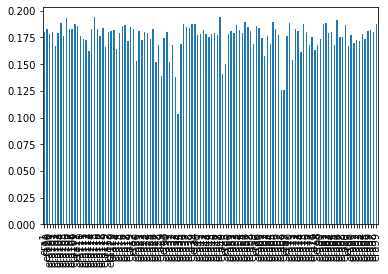

autocorrelation
0.29787371436794513
mean correlation
0.17524973042999809
sharpe
12.40015822161431
smart sharpe
9.10725976156824
[01:55:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 21s, sys: 80.4 ms, total: 1min 21s
Wall time: 42 s
###############
Iteration 22
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era68', 'era33', 'era29', 'era49', 'era31', 'era5', 'era27', 'era71', 'era62', 'era20', 'era113', 'era65', 'era57', 'era9', 'era81', 'era28', 'era32', 'era59', 'era14', 'era89', 'era18', 'era102', 'era91', 'era70', 'era6', 'era85', 'era74', 'era37', 'era1', 'era25', 'era4', 'era82', 'era56', 'era93', 'era17', 'era99', 'era39', 'era79', 'era3', 'era64', 'era53', 'era46', 'era2', 'era119', 'era44', 'era45', 'era111', 'era50', 'era36', 'era75', 'era104', 'era8', 'era41', 'era54', 'era40', 'era43', 'era101', 'era35', 'era106', 'era16', 'era76', 'era77', 'era100', 'era115', 'era12', 'era11', 'era15', 'era98', 'era72', 'era22', 'era30', 'era109', 'era55', 'era103', 'era110', 'era112', 'era80', 'era26', 'era67', 'era87', 'era58', 'era117', 'era88', 'era86', 'era92', 'era61', 'era94', 'era21', 'era73', 'era107', 'era19', 'era78', 'era42', 'era83']
performance over time


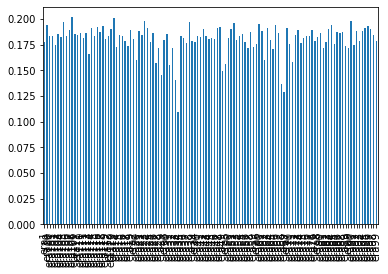

autocorrelation
0.24062692486910622
mean correlation
0.18038713978587173
sharpe
12.838247545309047
smart sharpe
10.023559046379303
[01:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 25s, sys: 73.4 ms, total: 1min 25s
Wall time: 43.8 s
###############
Iteration 23
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era33', 'era68', 'era29', 'era49', 'era5', 'era20', 'era27', 'era71', 'era31', 'era62', 'era9', 'era63', 'era47', 'era81', 'era28', 'era113', 'era32', 'era114', 'era18', 'era24', 'era25', 'era59', 'era97', 'era85', 'era116', 'era95', 'era70', 'era7', 'era120', 'era74', 'era14', 'era111', 'era4', 'era65', 'era66', 'era102', 'era118', 'era75', 'era119', 'era6', 'era105', 'era10', 'era51', 'era8', 'era50', 'era53', 'era57', 'era84', 'era48', 'era38', 'era39', 'era64', 'era100', 'era93', 'era108', 'era17', 'era1', 'era2', 'era37', 'era44', 'era43', 'era22', 'era23', 'era40', 'era11', 'era60', 'era76', 'era12', 'era96', 'era90', 'era45', 'era52', 'era13', 'era99', 'era89', 'era36', 'era79', 'era78', 'era103', 'era77', 'era41', 'era58', 'era26', 'era82', 'era3', 'era46', 'era98', 'era101', 'era91', 'era30', 'era35', 'era72', 'era56', 'era42']
performance over time


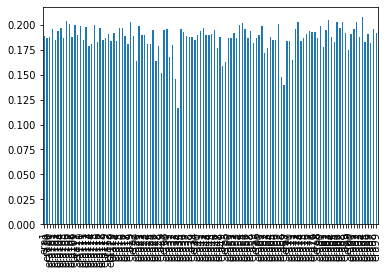

autocorrelation
0.23714555656239047
mean correlation
0.1869878407318743
sharpe
13.702203190686674
smart sharpe
10.737298141589434
[01:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 30s, sys: 84.4 ms, total: 1min 30s
Wall time: 46.3 s
###############
Iteration 24
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era69', 'era33', 'era68', 'era29', 'era49', 'era5', 'era27', 'era31', 'era71', 'era20', 'era62', 'era80', 'era15', 'era113', 'era59', 'era81', 'era60', 'era28', 'era117', 'era54', 'era104', 'era110', 'era32', 'era67', 'era112', 'era9', 'era74', 'era73', 'era106', 'era85', 'era25', 'era18', 'era19', 'era6', 'era46', 'era115', 'era16', 'era57', 'era61', 'era21', 'era114', 'era120', 'era17', 'era47', 'era109', 'era7', 'era97', 'era75', 'era87', 'era14', 'era63', 'era89', 'era65', 'era102', 'era107', 'era100', 'era83', 'era1', 'era93', 'era82', 'era119', 'era70', 'era111', 'era55', 'era64', 'era88', 'era118', 'era4', 'era98', 'era35', 'era24', 'era40', 'era48', 'era94', 'era3', 'era43', 'era99', 'era22', 'era41', 'era45', 'era2', 'era92', 'era11', 'era103', 'era37', 'era76', 'era8', 'era86', 'era91', 'era51', 'era78', 'era72', 'era50', 'era66', 'era95']
performance over time


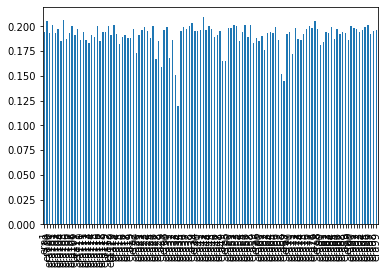

autocorrelation
0.30346370802915507
mean correlation
0.19070656449453052
sharpe
14.923268520641884
smart sharpe
10.893871963518443
[01:58:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 35s, sys: 89.4 ms, total: 1min 35s
Wall time: 48.7 s
###############
Iteration 25
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era69', 'era68', 'era29', 'era5', 'era49', 'era31', 'era27', 'era62', 'era20', 'era71', 'era28', 'era116', 'era38', 'era90', 'era58', 'era81', 'era13', 'era9', 'era117', 'era44', 'era30', 'era53', 'era108', 'era59', 'era25', 'era15', 'era26', 'era77', 'era12', 'era80', 'era23', 'era113', 'era84', 'era32', 'era39', 'era18', 'era85', 'era16', 'era36', 'era96', 'era42', 'era114', 'era14', 'era6', 'era21', 'era65', 'era110', 'era10', 'era73', 'era74', 'era93', 'era111', 'era54', 'era79', 'era101', 'era47', 'era67', 'era70', 'era17', 'era1', 'era2', 'era61', 'era104', 'era19', 'era4', 'era52', 'era106', 'era102', 'era24', 'era56', 'era105', 'era107', 'era60', 'era75', 'era97', 'era115', 'era46', 'era109', 'era98', 'era87', 'era64', 'era11', 'era120', 'era112', 'era100', 'era50', 'era99', 'era78', 'era45', 'era119', 'era40', 'era48', 'era3', 'era8']
performance over time


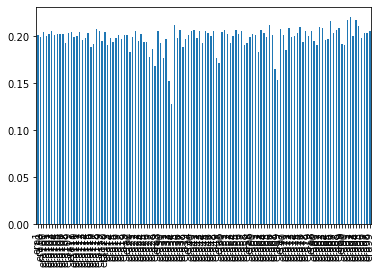

autocorrelation
0.25200423764088536
mean correlation
0.19812219910334108
sharpe
15.594571761693475
smart sharpe
12.030371864704357
[01:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 40s, sys: 95.4 ms, total: 1min 40s
Wall time: 51.5 s
###############
Iteration 26
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era69', 'era68', 'era29', 'era31', 'era5', 'era49', 'era89', 'era62', 'era27', 'era41', 'era43', 'era71', 'era59', 'era28', 'era20', 'era57', 'era30', 'era7', 'era88', 'era55', 'era90', 'era37', 'era35', 'era72', 'era83', 'era113', 'era103', 'era91', 'era76', 'era36', 'era15', 'era60', 'era54', 'era74', 'era12', 'era32', 'era9', 'era81', 'era63', 'era118', 'era80', 'era51', 'era82', 'era17', 'era116', 'era117', 'era25', 'era6', 'era58', 'era19', 'era22', 'era66', 'era65', 'era46', 'era93', 'era114', 'era18', 'era23', 'era53', 'era75', 'era98', 'era21', 'era85', 'era67', 'era13', 'era16', 'era79', 'era111', 'era2', 'era26', 'era39', 'era44', 'era104', 'era108', 'era61', 'era112', 'era38', 'era92', 'era94', 'era107', 'era96', 'era56', 'era95', 'era4', 'era110', 'era77', 'era14', 'era3', 'era115', 'era101', 'era40', 'era102', 'era100', 'era99']
performance over time


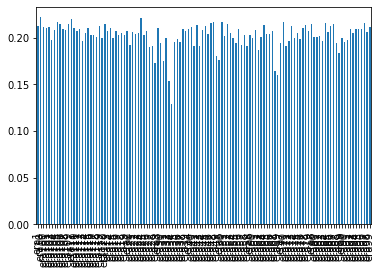

autocorrelation
0.35478181721424074
mean correlation
0.2024522482293224
sharpe
15.042501028315899
smart sharpe
10.37278567824659
[02:00:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 45s, sys: 89.3 ms, total: 1min 45s
Wall time: 54.2 s
###############
Iteration 27
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era69', 'era68', 'era29', 'era5', 'era49', 'era31', 'era78', 'era27', 'era70', 'era28', 'era62', 'era20', 'era87', 'era74', 'era103', 'era73', 'era71', 'era89', 'era41', 'era8', 'era42', 'era48', 'era117', 'era119', 'era59', 'era50', 'era64', 'era86', 'era24', 'era72', 'era32', 'era43', 'era76', 'era113', 'era58', 'era10', 'era97', 'era63', 'era36', 'era26', 'era12', 'era37', 'era106', 'era90', 'era66', 'era91', 'era1', 'era18', 'era111', 'era84', 'era105', 'era9', 'era15', 'era85', 'era30', 'era7', 'era35', 'era107', 'era57', 'era88', 'era109', 'era45', 'era93', 'era55', 'era108', 'era61', 'era22', 'era118', 'era81', 'era98', 'era11', 'era65', 'era46', 'era17', 'era53', 'era2', 'era14', 'era82', 'era114', 'era16', 'era47', 'era60', 'era75', 'era25', 'era52', 'era21', 'era23', 'era39', 'era6', 'era51', 'era13', 'era116', 'era120', 'era54']
performance over time


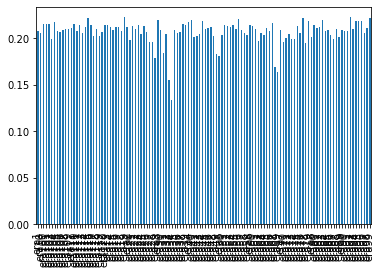

autocorrelation
0.35204932493464675
mean correlation
0.20692285501555613
sharpe
16.229632864797196
smart sharpe
11.226012245349196
[02:01:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 50s, sys: 101 ms, total: 1min 50s
Wall time: 56.4 s
###############
Iteration 28
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era69', 'era68', 'era5', 'era29', 'era49', 'era31', 'era27', 'era80', 'era110', 'era59', 'era89', 'era28', 'era62', 'era101', 'era67', 'era76', 'era78', 'era4', 'era102', 'era112', 'era19', 'era44', 'era38', 'era100', 'era42', 'era12', 'era104', 'era77', 'era117', 'era43', 'era87', 'era94', 'era64', 'era37', 'era115', 'era3', 'era95', 'era70', 'era96', 'era6', 'era15', 'era40', 'era72', 'era99', 'era73', 'era41', 'era56', 'era71', 'era32', 'era7', 'era20', 'era8', 'era65', 'era113', 'era106', 'era85', 'era36', 'era25', 'era83', 'era103', 'era50', 'era97', 'era46', 'era9', 'era74', 'era48', 'era57', 'era17', 'era58', 'era66', 'era30', 'era60', 'era35', 'era109', 'era111', 'era118', 'era45', 'era55', 'era79', 'era63', 'era98', 'era26', 'era1', 'era119', 'era24', 'era93', 'era92', 'era90', 'era91', 'era16', 'era88', 'era81', 'era54', 'era18']
performance over time


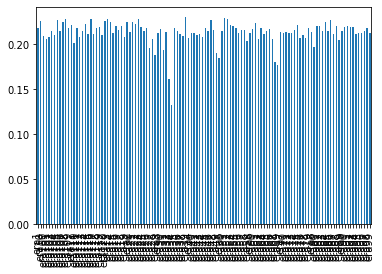

autocorrelation
0.3476198989386643
mean correlation
0.21330892041938115
sharpe
16.557392676266907
smart sharpe
11.510049394460284
[02:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 57s, sys: 116 ms, total: 1min 57s
Wall time: 1min
###############
Iteration 29
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era69', 'era5', 'era68', 'era29', 'era31', 'era49', 'era80', 'era62', 'era27', 'era114', 'era28', 'era14', 'era11', 'era4', 'era78', 'era53', 'era107', 'era10', 'era59', 'era76', 'era22', 'era101', 'era70', 'era61', 'era21', 'era82', 'era110', 'era42', 'era3', 'era75', 'era20', 'era2', 'era9', 'era116', 'era12', 'era38', 'era100', 'era51', 'era58', 'era65', 'era15', 'era102', 'era67', 'era89', 'era41', 'era23', 'era84', 'era71', 'era86', 'era26', 'era40', 'era105', 'era13', 'era120', 'era115', 'era44', 'era47', 'era117', 'era108', 'era39', 'era1', 'era95', 'era64', 'era72', 'era104', 'era50', 'era32', 'era56', 'era25', 'era103', 'era46', 'era43', 'era111', 'era73', 'era17', 'era19', 'era37', 'era96', 'era112', 'era77', 'era85', 'era8', 'era99', 'era48', 'era66', 'era36', 'era81', 'era87', 'era57', 'era6', 'era113', 'era83', 'era52', 'era74']
performance over time


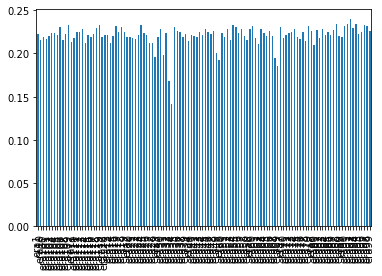

autocorrelation
0.29736949507712623
mean correlation
0.2207332609006348
sharpe
17.944624381199663
smart sharpe
13.186596782327703
[02:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 1s, sys: 115 ms, total: 2min 1s
Wall time: 1min 1s
###############
Iteration 30
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era69', 'era5', 'era29', 'era31', 'era68', 'era49', 'era62', 'era90', 'era30', 'era80', 'era59', 'era89', 'era35', 'era28', 'era76', 'era60', 'era79', 'era88', 'era63', 'era54', 'era27', 'era7', 'era97', 'era22', 'era114', 'era93', 'era98', 'era11', 'era119', 'era75', 'era45', 'era55', 'era94', 'era78', 'era17', 'era3', 'era109', 'era101', 'era91', 'era106', 'era100', 'era32', 'era43', 'era120', 'era67', 'era53', 'era118', 'era18', 'era107', 'era4', 'era24', 'era15', 'era58', 'era2', 'era110', 'era16', 'era41', 'era113', 'era102', 'era12', 'era9', 'era44', 'era61', 'era14', 'era66', 'era1', 'era19', 'era23', 'era20', 'era72', 'era82', 'era115', 'era65', 'era116', 'era40', 'era51', 'era64', 'era37', 'era71', 'era46', 'era104', 'era103', 'era26', 'era99', 'era92', 'era112', 'era81', 'era85', 'era111', 'era84', 'era77', 'era57', 'era74', 'era56']
performance over time


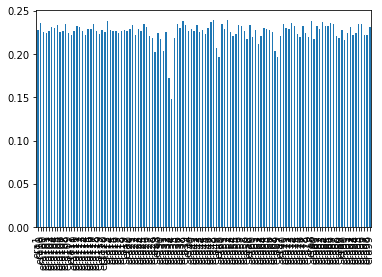

autocorrelation
0.4012266952922253
mean correlation
0.2253917690113351
sharpe
19.085740884884405
smart sharpe
12.474022686031526
[02:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 7s, sys: 104 ms, total: 2min 7s
Wall time: 1min 5s
###############
Iteration 31
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era29', 'era31', 'era68', 'era49', 'era42', 'era70', 'era117', 'era21', 'era10', 'era62', 'era50', 'era48', 'era95', 'era87', 'era105', 'era63', 'era28', 'era108', 'era36', 'era86', 'era76', 'era114', 'era13', 'era25', 'era78', 'era8', 'era73', 'era59', 'era93', 'era11', 'era39', 'era18', 'era9', 'era96', 'era98', 'era47', 'era58', 'era27', 'era61', 'era38', 'era83', 'era20', 'era119', 'era30', 'era35', 'era12', 'era90', 'era15', 'era32', 'era22', 'era107', 'era75', 'era97', 'era14', 'era17', 'era100', 'era79', 'era53', 'era54', 'era80', 'era26', 'era24', 'era110', 'era65', 'era6', 'era102', 'era52', 'era111', 'era72', 'era7', 'era16', 'era23', 'era45', 'era3', 'era101', 'era4', 'era71', 'era118', 'era116', 'era51', 'era81', 'era60', 'era67', 'era44', 'era1', 'era66', 'era2', 'era40', 'era55', 'era43', 'era103', 'era94']
performance over time


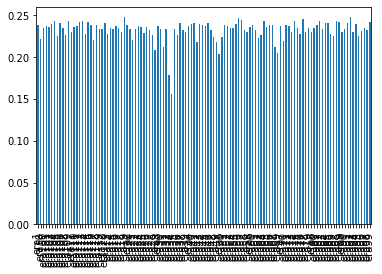

autocorrelation
0.2979086141760748
mean correlation
0.23266903077737808
sharpe
19.467789270245888
smart sharpe
14.297518513039787
[02:06:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 11s, sys: 100 ms, total: 2min 11s
Wall time: 1min 7s
###############
Iteration 32
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era31', 'era29', 'era68', 'era113', 'era89', 'era49', 'era91', 'era46', 'era62', 'era85', 'era41', 'era37', 'era117', 'era120', 'era106', 'era19', 'era28', 'era88', 'era6', 'era82', 'era74', 'era115', 'era109', 'era42', 'era99', 'era59', 'era76', 'era70', 'era104', 'era27', 'era56', 'era57', 'era112', 'era30', 'era25', 'era84', 'era21', 'era36', 'era17', 'era3', 'era54', 'era77', 'era64', 'era65', 'era12', 'era119', 'era72', 'era22', 'era60', 'era73', 'era93', 'era10', 'era15', 'era50', 'era108', 'era45', 'era78', 'era48', 'era80', 'era32', 'era98', 'era43', 'era75', 'era63', 'era79', 'era35', 'era92', 'era67', 'era2', 'era83', 'era96', 'era55', 'era87', 'era7', 'era18', 'era118', 'era90', 'era1', 'era114', 'era40', 'era110', 'era9', 'era58', 'era11', 'era26', 'era39', 'era8', 'era61', 'era20', 'era86', 'era44', 'era100']
performance over time


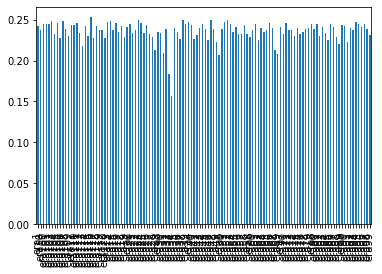

autocorrelation
0.24005541530965888
mean correlation
0.23578917125294382
sharpe
18.652070967917993
smart sharpe
14.571498353728746
[02:08:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 17s, sys: 115 ms, total: 2min 17s
Wall time: 1min 10s
###############
Iteration 33
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era29', 'era68', 'era31', 'era49', 'era81', 'era28', 'era62', 'era14', 'era89', 'era105', 'era97', 'era102', 'era113', 'era24', 'era103', 'era101', 'era91', 'era71', 'era66', 'era53', 'era95', 'era41', 'era85', 'era46', 'era42', 'era107', 'era37', 'era76', 'era21', 'era117', 'era116', 'era4', 'era115', 'era111', 'era50', 'era70', 'era16', 'era23', 'era88', 'era38', 'era36', 'era59', 'era3', 'era56', 'era48', 'era25', 'era74', 'era57', 'era6', 'era109', 'era65', 'era63', 'era27', 'era32', 'era47', 'era84', 'era52', 'era30', 'era94', 'era51', 'era78', 'era22', 'era120', 'era1', 'era106', 'era108', 'era17', 'era9', 'era104', 'era64', 'era114', 'era11', 'era45', 'era119', 'era19', 'era99', 'era98', 'era73', 'era13', 'era58', 'era82', 'era20', 'era77', 'era61', 'era12', 'era87', 'era2', 'era44', 'era112', 'era43', 'era100', 'era75']
performance over time


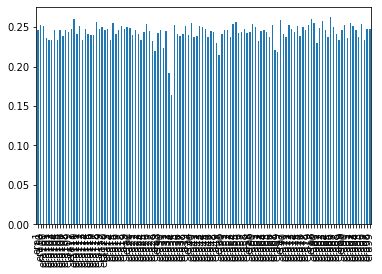

autocorrelation
0.2062798698741498
mean correlation
0.24315083242292543
sharpe
19.833457449241205
smart sharpe
16.049890630400807
[02:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 25s, sys: 128 ms, total: 2min 25s
Wall time: 1min 14s
###############
Iteration 34
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era68', 'era31', 'era29', 'era69', 'era49', 'era60', 'era15', 'era62', 'era67', 'era28', 'era89', 'era81', 'era113', 'era35', 'era18', 'era72', 'era117', 'era85', 'era93', 'era14', 'era90', 'era37', 'era3', 'era42', 'era53', 'era8', 'era6', 'era41', 'era97', 'era26', 'era111', 'era40', 'era107', 'era46', 'era95', 'era76', 'era59', 'era24', 'era101', 'era54', 'era118', 'era103', 'era91', 'era96', 'era102', 'era21', 'era10', 'era83', 'era66', 'era79', 'era27', 'era71', 'era7', 'era4', 'era39', 'era110', 'era22', 'era32', 'era74', 'era80', 'era36', 'era17', 'era64', 'era9', 'era38', 'era23', 'era78', 'era115', 'era65', 'era109', 'era92', 'era120', 'era106', 'era25', 'era50', 'era12', 'era104', 'era88', 'era75', 'era98', 'era48', 'era86', 'era99', 'era19', 'era47', 'era30', 'era52', 'era57', 'era70', 'era55', 'era58', 'era105', 'era77']
performance over time


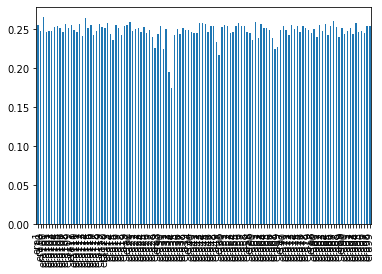

autocorrelation
0.3323955275314863
mean correlation
0.2479894671346265
sharpe
21.75343257787036
smart sharpe
15.381911930488256
[02:11:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 30s, sys: 126 ms, total: 2min 30s
Wall time: 1min 16s
###############
Iteration 35
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era68', 'era29', 'era31', 'era49', 'era62', 'era85', 'era28', 'era81', 'era112', 'era60', 'era93', 'era72', 'era45', 'era16', 'era82', 'era51', 'era116', 'era108', 'era63', 'era119', 'era56', 'era44', 'era61', 'era74', 'era84', 'era113', 'era87', 'era89', 'era20', 'era107', 'era67', 'era13', 'era42', 'era15', 'era2', 'era18', 'era11', 'era43', 'era101', 'era3', 'era71', 'era73', 'era37', 'era35', 'era117', 'era27', 'era76', 'era6', 'era114', 'era46', 'era94', 'era14', 'era53', 'era8', 'era59', 'era66', 'era111', 'era41', 'era36', 'era118', 'era17', 'era90', 'era25', 'era40', 'era98', 'era79', 'era91', 'era39', 'era100', 'era95', 'era1', 'era106', 'era9', 'era24', 'era4', 'era103', 'era21', 'era7', 'era70', 'era23', 'era22', 'era32', 'era64', 'era54', 'era102', 'era58', 'era26', 'era97', 'era75', 'era115', 'era78', 'era48']
performance over time


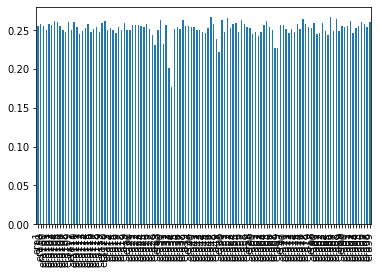

autocorrelation
0.28649589053429936
mean correlation
0.2518374718967901
sharpe
22.379828049245877
smart sharpe
16.640492202139338
[02:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 35s, sys: 134 ms, total: 2min 35s
Wall time: 1min 19s
###############
Iteration 36
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era68', 'era69', 'era29', 'era80', 'era49', 'era12', 'era110', 'era28', 'era83', 'era120', 'era62', 'era19', 'era96', 'era105', 'era65', 'era55', 'era30', 'era37', 'era45', 'era109', 'era59', 'era77', 'era16', 'era10', 'era43', 'era88', 'era63', 'era85', 'era2', 'era99', 'era92', 'era38', 'era15', 'era57', 'era9', 'era53', 'era76', 'era50', 'era3', 'era89', 'era44', 'era82', 'era4', 'era6', 'era40', 'era35', 'era81', 'era104', 'era72', 'era51', 'era60', 'era46', 'era52', 'era25', 'era17', 'era113', 'era93', 'era66', 'era27', 'era116', 'era11', 'era47', 'era1', 'era56', 'era8', 'era112', 'era36', 'era108', 'era7', 'era117', 'era114', 'era67', 'era101', 'era71', 'era13', 'era119', 'era42', 'era18', 'era86', 'era87', 'era20', 'era118', 'era41', 'era98', 'era84', 'era64', 'era21', 'era94', 'era74', 'era22', 'era97', 'era91']
performance over time


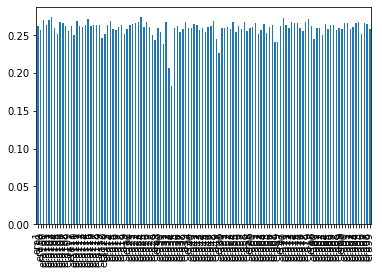

autocorrelation
0.3063417188200433
mean correlation
0.25931225792180107
sharpe
22.855997549301307
smart sharpe
16.63237989067091
[02:14:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 39s, sys: 141 ms, total: 2min 39s
Wall time: 1min 21s
###############
Iteration 37
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era68', 'era107', 'era49', 'era29', 'era31', 'era73', 'era103', 'era26', 'era78', 'era61', 'era62', 'era14', 'era90', 'era48', 'era58', 'era28', 'era111', 'era32', 'era23', 'era102', 'era70', 'era80', 'era10', 'era39', 'era110', 'era9', 'era95', 'era12', 'era100', 'era2', 'era15', 'era11', 'era59', 'era65', 'era93', 'era117', 'era18', 'era24', 'era42', 'era75', 'era106', 'era63', 'era19', 'era76', 'era88', 'era40', 'era112', 'era20', 'era85', 'era16', 'era30', 'era53', 'era3', 'era37', 'era87', 'era81', 'era96', 'era50', 'era13', 'era105', 'era8', 'era54', 'era74', 'era6', 'era45', 'era38', 'era120', 'era36', 'era77', 'era108', 'era44', 'era119', 'era104', 'era79', 'era43', 'era1', 'era109', 'era72', 'era22', 'era115', 'era46', 'era99', 'era116', 'era52', 'era114', 'era35', 'era101', 'era82', 'era71', 'era4', 'era84', 'era57']
performance over time


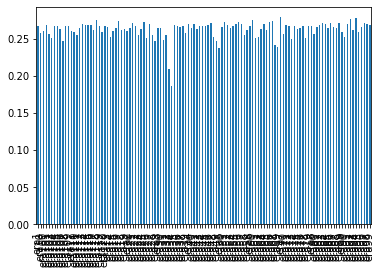

autocorrelation
0.28489255019893056
mean correlation
0.2624997577065843
sharpe
22.537681390422556
smart sharpe
16.78685678337448
[02:16:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 47s, sys: 143 ms, total: 2min 47s
Wall time: 1min 25s
###############
Iteration 38
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era68', 'era31', 'era49', 'era113', 'era89', 'era29', 'era41', 'era56', 'era60', 'era83', 'era27', 'era78', 'era23', 'era98', 'era62', 'era107', 'era55', 'era73', 'era67', 'era17', 'era66', 'era80', 'era59', 'era91', 'era64', 'era103', 'era92', 'era32', 'era26', 'era58', 'era6', 'era97', 'era9', 'era61', 'era65', 'era28', 'era54', 'era25', 'era118', 'era75', 'era102', 'era19', 'era51', 'era21', 'era85', 'era47', 'era112', 'era94', 'era111', 'era100', 'era90', 'era37', 'era86', 'era12', 'era15', 'era14', 'era30', 'era43', 'era3', 'era2', 'era48', 'era76', 'era74', 'era106', 'era88', 'era46', 'era77', 'era72', 'era101', 'era93', 'era109', 'era81', 'era39', 'era45', 'era63', 'era95', 'era120', 'era57', 'era40', 'era110', 'era11', 'era16', 'era53', 'era117', 'era71', 'era18', 'era7', 'era24', 'era79', 'era70', 'era104', 'era119']
performance over time


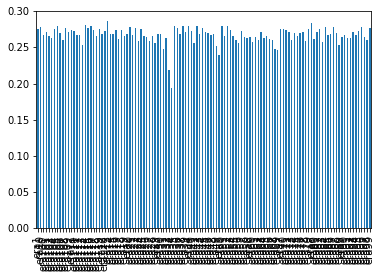

autocorrelation
0.24391438988160344
mean correlation
0.267202968835324
sharpe
23.040228891626608
smart sharpe
17.926706919904685
[02:18:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 55s, sys: 149 ms, total: 2min 56s
Wall time: 1min 29s
###############
Iteration 39
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era31', 'era68', 'era29', 'era49', 'era108', 'era41', 'era105', 'era28', 'era23', 'era78', 'era98', 'era44', 'era115', 'era27', 'era66', 'era10', 'era62', 'era26', 'era58', 'era20', 'era89', 'era65', 'era114', 'era22', 'era111', 'era107', 'era83', 'era42', 'era32', 'era113', 'era59', 'era9', 'era116', 'era50', 'era38', 'era55', 'era13', 'era1', 'era73', 'era36', 'era99', 'era12', 'era84', 'era17', 'era97', 'era87', 'era81', 'era100', 'era48', 'era14', 'era103', 'era82', 'era56', 'era118', 'era75', 'era96', 'era102', 'era61', 'era67', 'era8', 'era21', 'era91', 'era90', 'era35', 'era52', 'era2', 'era4', 'era64', 'era80', 'era37', 'era70', 'era25', 'era47', 'era3', 'era51', 'era40', 'era60', 'era63', 'era6', 'era15', 'era86', 'era16', 'era72', 'era30', 'era93', 'era53', 'era76', 'era18', 'era92', 'era94', 'era85', 'era39']
performance over time


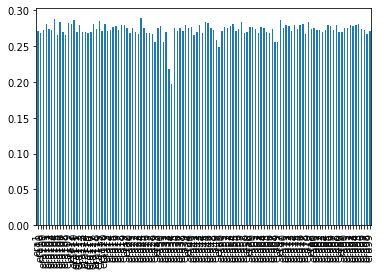

autocorrelation
0.32822622829181797
mean correlation
0.27290207215716894
sharpe
24.94260869531275
smart sharpe
17.718854467611838
[02:20:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min, sys: 153 ms, total: 3min
Wall time: 1min 31s
###############
Iteration 40
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era69', 'era68', 'era49', 'era29', 'era19', 'era43', 'era74', 'era77', 'era46', 'era117', 'era106', 'era59', 'era113', 'era11', 'era101', 'era28', 'era41', 'era73', 'era112', 'era110', 'era98', 'era120', 'era62', 'era32', 'era23', 'era45', 'era78', 'era71', 'era57', 'era119', 'era66', 'era27', 'era88', 'era109', 'era3', 'era89', 'era108', 'era20', 'era95', 'era54', 'era17', 'era79', 'era75', 'era24', 'era58', 'era22', 'era84', 'era65', 'era60', 'era107', 'era6', 'era9', 'era111', 'era37', 'era85', 'era44', 'era55', 'era83', 'era102', 'era67', 'era4', 'era99', 'era2', 'era42', 'era26', 'era104', 'era7', 'era115', 'era118', 'era50', 'era100', 'era25', 'era105', 'era56', 'era91', 'era70', 'era40', 'era72', 'era36', 'era15', 'era38', 'era14', 'era114', 'era21', 'era81', 'era12', 'era30', 'era10', 'era51', 'era96', 'era87', 'era64']
performance over time


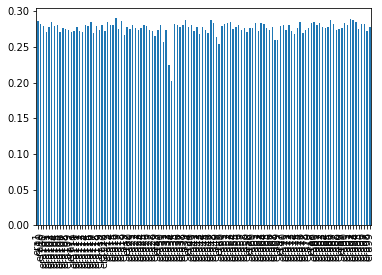

autocorrelation
0.34152394002063513
mean correlation
0.276070391848358
sharpe
26.265683195010332
smart sharpe
18.38425721492532
[02:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 6s, sys: 165 ms, total: 3min 6s
Wall time: 1min 35s
###############
Iteration 41
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era69', 'era31', 'era68', 'era29', 'era63', 'era97', 'era116', 'era13', 'era48', 'era61', 'era76', 'era49', 'era28', 'era23', 'era103', 'era90', 'era117', 'era8', 'era20', 'era94', 'era32', 'era80', 'era9', 'era43', 'era35', 'era52', 'era53', 'era82', 'era78', 'era77', 'era112', 'era59', 'era16', 'era98', 'era74', 'era18', 'era47', 'era58', 'era93', 'era95', 'era11', 'era101', 'era106', 'era39', 'era27', 'era22', 'era19', 'era111', 'era1', 'era26', 'era113', 'era108', 'era119', 'era62', 'era46', 'era86', 'era57', 'era41', 'era42', 'era120', 'era107', 'era65', 'era88', 'era66', 'era79', 'era3', 'era87', 'era99', 'era102', 'era71', 'era44', 'era92', 'era75', 'era81', 'era73', 'era54', 'era105', 'era37', 'era24', 'era83', 'era36', 'era70', 'era110', 'era89', 'era17', 'era109', 'era85', 'era7', 'era64', 'era50', 'era12', 'era38', 'era100']
performance over time


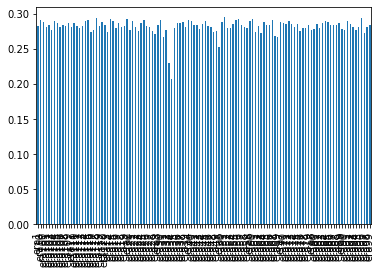

autocorrelation
0.3434547732966981
mean correlation
0.2823444566492917
sharpe
26.354095500419838
smart sharpe
18.40626220263015
[02:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 17s, sys: 175 ms, total: 3min 17s
Wall time: 1min 40s
###############
Iteration 42
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era69', 'era15', 'era68', 'era29', 'era45', 'era30', 'era72', 'era51', 'era6', 'era40', 'era56', 'era104', 'era4', 'era48', 'era21', 'era63', 'era55', 'era2', 'era43', 'era59', 'era14', 'era27', 'era97', 'era60', 'era115', 'era117', 'era28', 'era114', 'era10', 'era54', 'era74', 'era26', 'era67', 'era49', 'era46', 'era84', 'era91', 'era32', 'era65', 'era106', 'era76', 'era8', 'era11', 'era53', 'era3', 'era25', 'era13', 'era58', 'era18', 'era19', 'era111', 'era17', 'era94', 'era62', 'era41', 'era23', 'era96', 'era9', 'era77', 'era118', 'era82', 'era20', 'era116', 'era78', 'era39', 'era107', 'era90', 'era22', 'era61', 'era101', 'era103', 'era80', 'era52', 'era73', 'era57', 'era93', 'era37', 'era81', 'era113', 'era98', 'era85', 'era44', 'era89', 'era47', 'era16', 'era75', 'era1', 'era35', 'era71', 'era95', 'era99', 'era120']
performance over time


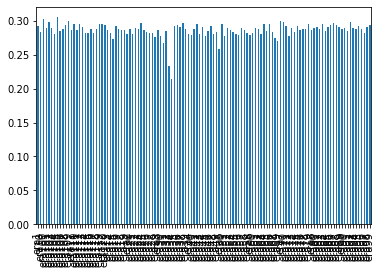

autocorrelation
0.28604443740041335
mean correlation
0.2864244267843838
sharpe
26.36270609511425
smart sharpe
19.611502494924462
[02:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 19s, sys: 130 ms, total: 3min 19s
Wall time: 1min 41s
###############
Iteration 43
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era69', 'era29', 'era66', 'era68', 'era79', 'era108', 'era42', 'era63', 'era112', 'era28', 'era12', 'era49', 'era78', 'era15', 'era36', 'era30', 'era119', 'era48', 'era45', 'era87', 'era64', 'era40', 'era6', 'era88', 'era50', 'era8', 'era102', 'era100', 'era70', 'era23', 'era110', 'era59', 'era105', 'era76', 'era20', 'era111', 'era74', 'era7', 'era104', 'era38', 'era83', 'era32', 'era43', 'era117', 'era92', 'era58', 'era103', 'era24', 'era86', 'era97', 'era115', 'era11', 'era51', 'era90', 'era84', 'era21', 'era2', 'era10', 'era114', 'era3', 'era25', 'era55', 'era116', 'era9', 'era27', 'era61', 'era109', 'era113', 'era81', 'era26', 'era52', 'era17', 'era107', 'era94', 'era72', 'era93', 'era95', 'era67', 'era56', 'era65', 'era73', 'era18', 'era14', 'era13', 'era80', 'era37', 'era41', 'era77', 'era39', 'era22', 'era91', 'era53']
performance over time


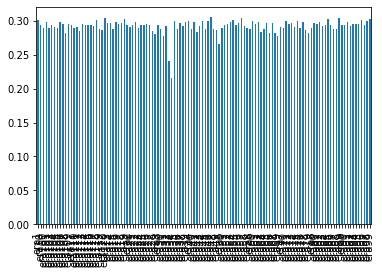

autocorrelation
0.30058550493729547
mean correlation
0.2919524222234109
sharpe
27.85161290786254
smart sharpe
20.395308578125963
[02:28:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 26s, sys: 176 ms, total: 3min 26s
Wall time: 1min 45s
###############
Iteration 44
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era19', 'era60', 'era69', 'era54', 'era15', 'era106', 'era62', 'era101', 'era29', 'era35', 'era4', 'era44', 'era85', 'era68', 'era89', 'era6', 'era98', 'era57', 'era88', 'era79', 'era59', 'era30', 'era71', 'era66', 'era40', 'era46', 'era82', 'era49', 'era120', 'era12', 'era3', 'era1', 'era72', 'era118', 'era74', 'era28', 'era36', 'era96', 'era75', 'era43', 'era16', 'era27', 'era112', 'era48', 'era45', 'era32', 'era87', 'era63', 'era42', 'era99', 'era78', 'era113', 'era119', 'era104', 'era76', 'era21', 'era81', 'era17', 'era110', 'era51', 'era108', 'era23', 'era47', 'era20', 'era37', 'era50', 'era22', 'era55', 'era93', 'era67', 'era100', 'era64', 'era111', 'era9', 'era109', 'era65', 'era115', 'era102', 'era18', 'era117', 'era91', 'era58', 'era2', 'era97', 'era7', 'era83', 'era25', 'era70', 'era14', 'era73', 'era26', 'era11']
performance over time


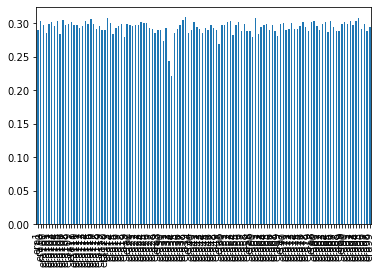

autocorrelation
0.3220875583065789
mean correlation
0.29408855695132957
sharpe
27.018066618011353
smart sharpe
19.324057803566472
[02:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 31s, sys: 209 ms, total: 3min 32s
Wall time: 1min 48s
###############
Iteration 45
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era114', 'era69', 'era24', 'era103', 'era29', 'era61', 'era38', 'era85', 'era10', 'era8', 'era62', 'era92', 'era56', 'era63', 'era68', 'era42', 'era12', 'era77', 'era41', 'era98', 'era105', 'era116', 'era90', 'era95', 'era28', 'era4', 'era86', 'era52', 'era107', 'era53', 'era16', 'era71', 'era44', 'era15', 'era88', 'era78', 'era87', 'era84', 'era101', 'era40', 'era106', 'era49', 'era13', 'era39', 'era3', 'era6', 'era36', 'era74', 'era35', 'era32', 'era20', 'era108', 'era30', 'era66', 'era75', 'era60', 'era118', 'era9', 'era117', 'era59', 'era48', 'era1', 'era111', 'era57', 'era19', 'era76', 'era79', 'era21', 'era80', 'era82', 'era72', 'era46', 'era102', 'era70', 'era119', 'era58', 'era112', 'era94', 'era65', 'era54', 'era96', 'era23', 'era120', 'era43', 'era104', 'era100', 'era93', 'era11', 'era45', 'era27', 'era64', 'era81']
performance over time


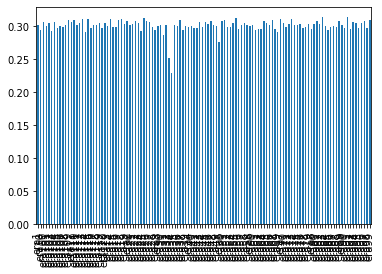

autocorrelation
0.2620226437860299
mean correlation
0.301438400553223
sharpe
30.599148005605276
smart sharpe
23.356121609266452
[02:33:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 42s, sys: 199 ms, total: 3min 42s
Wall time: 1min 53s
###############
Iteration 46
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era89', 'era113', 'era22', 'era29', 'era69', 'era2', 'era109', 'era62', 'era37', 'era110', 'era12', 'era99', 'era103', 'era115', 'era26', 'era85', 'era18', 'era17', 'era28', 'era91', 'era15', 'era30', 'era97', 'era24', 'era51', 'era53', 'era6', 'era41', 'era19', 'era3', 'era4', 'era88', 'era50', 'era1', 'era67', 'era77', 'era49', 'era54', 'era40', 'era38', 'era78', 'era106', 'era56', 'era55', 'era61', 'era116', 'era90', 'era9', 'era47', 'era59', 'era44', 'era8', 'era63', 'era114', 'era83', 'era16', 'era84', 'era74', 'era98', 'era7', 'era52', 'era68', 'era73', 'era25', 'era42', 'era87', 'era14', 'era66', 'era65', 'era75', 'era71', 'era80', 'era36', 'era60', 'era39', 'era95', 'era76', 'era20', 'era107', 'era94', 'era81', 'era21', 'era46', 'era32', 'era92', 'era111', 'era101', 'era118', 'era102', 'era108', 'era43', 'era96']
performance over time


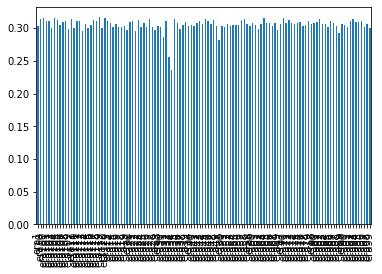

autocorrelation
0.24893615738665154
mean correlation
0.3053288510419622
sharpe
31.23264140771598
smart sharpe
24.172549551551473
[02:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 45s, sys: 165 ms, total: 3min 45s
Wall time: 1min 54s
###############
Iteration 47
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era117', 'era48', 'era13', 'era69', 'era29', 'era112', 'era72', 'era70', 'era35', 'era22', 'era113', 'era85', 'era57', 'era86', 'era120', 'era27', 'era10', 'era79', 'era23', 'era37', 'era15', 'era12', 'era89', 'era103', 'era62', 'era74', 'era58', 'era82', 'era49', 'era99', 'era45', 'era115', 'era26', 'era68', 'era6', 'era17', 'era11', 'era40', 'era93', 'era119', 'era105', 'era3', 'era78', 'era2', 'era67', 'era16', 'era18', 'era28', 'era106', 'era73', 'era77', 'era64', 'era8', 'era9', 'era98', 'era100', 'era110', 'era104', 'era30', 'era109', 'era20', 'era53', 'era61', 'era111', 'era59', 'era51', 'era32', 'era47', 'era91', 'era55', 'era41', 'era84', 'era71', 'era50', 'era7', 'era107', 'era63', 'era97', 'era42', 'era52', 'era114', 'era87', 'era118', 'era4', 'era90', 'era102', 'era95', 'era75', 'era76', 'era56', 'era36', 'era44']
performance over time


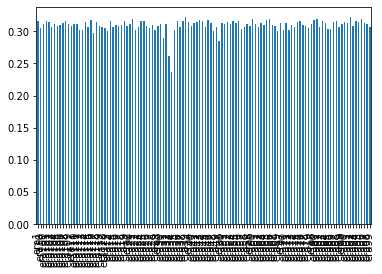

autocorrelation
0.33531867434244694
mean correlation
0.30920587355161283
sharpe
31.29250569626775
smart sharpe
22.05510315611056
[02:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 55s, sys: 220 ms, total: 3min 55s
Wall time: 2min
###############
Iteration 48
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era19', 'era54', 'era116', 'era25', 'era66', 'era24', 'era83', 'era29', 'era37', 'era3', 'era57', 'era101', 'era65', 'era9', 'era43', 'era1', 'era81', 'era46', 'era94', 'era6', 'era21', 'era62', 'era60', 'era80', 'era39', 'era11', 'era48', 'era69', 'era88', 'era38', 'era23', 'era117', 'era89', 'era14', 'era27', 'era35', 'era72', 'era113', 'era58', 'era22', 'era30', 'era2', 'era17', 'era108', 'era45', 'era49', 'era96', 'era70', 'era105', 'era92', 'era28', 'era40', 'era12', 'era99', 'era13', 'era85', 'era100', 'era79', 'era59', 'era120', 'era15', 'era50', 'era77', 'era82', 'era10', 'era53', 'era112', 'era16', 'era86', 'era115', 'era97', 'era67', 'era51', 'era4', 'era26', 'era55', 'era104', 'era64', 'era44', 'era41', 'era71', 'era106', 'era74', 'era78', 'era32', 'era56', 'era93', 'era76', 'era91', 'era52', 'era36', 'era103']
performance over time


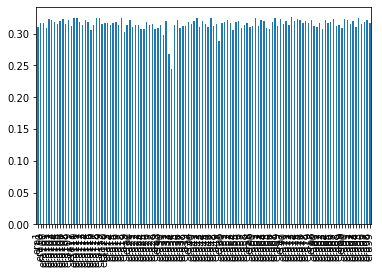

autocorrelation
0.26131601380175834
mean correlation
0.31506562283619355
sharpe
31.927994287188874
smart sharpe
24.388736954519086
[02:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 59s, sys: 212 ms, total: 3min 59s
Wall time: 2min 2s
###############
Iteration 49
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era107', 'era8', 'era42', 'era63', 'era18', 'era20', 'era119', 'era61', 'era95', 'era68', 'era87', 'era111', 'era102', 'era73', 'era114', 'era69', 'era98', 'era29', 'era90', 'era110', 'era84', 'era9', 'era3', 'era11', 'era117', 'era75', 'era24', 'era25', 'era47', 'era7', 'era6', 'era108', 'era72', 'era81', 'era14', 'era48', 'era101', 'era66', 'era116', 'era37', 'era23', 'era39', 'era21', 'era58', 'era109', 'era49', 'era65', 'era38', 'era13', 'era54', 'era35', 'era74', 'era70', 'era78', 'era112', 'era43', 'era57', 'era40', 'era118', 'era19', 'era62', 'era27', 'era93', 'era94', 'era28', 'era26', 'era22', 'era80', 'era83', 'era2', 'era12', 'era16', 'era100', 'era86', 'era1', 'era88', 'era15', 'era30', 'era85', 'era32', 'era46', 'era79', 'era45', 'era99', 'era4', 'era53', 'era89', 'era17', 'era96', 'era77', 'era59', 'era113']
performance over time


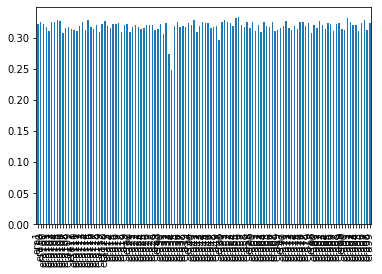

autocorrelation
0.23144441196611568
mean correlation
0.3183129636114471
sharpe
32.345799873677535
smart sharpe
25.498687760833487
[02:43:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 5s, sys: 195 ms, total: 4min 6s
Wall time: 2min 5s
###############
Iteration 50
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era60', 'era3', 'era67', 'era103', 'era107', 'era64', 'era41', 'era92', 'era68', 'era6', 'era56', 'era97', 'era69', 'era91', 'era61', 'era104', 'era63', 'era29', 'era10', 'era55', 'era8', 'era44', 'era76', 'era117', 'era87', 'era18', 'era71', 'era9', 'era50', 'era75', 'era36', 'era82', 'era72', 'era11', 'era111', 'era51', 'era106', 'era42', 'era73', 'era52', 'era101', 'era54', 'era20', 'era95', 'era115', 'era65', 'era37', 'era120', 'era81', 'era24', 'era105', 'era98', 'era43', 'era102', 'era62', 'era84', 'era110', 'era21', 'era119', 'era57', 'era114', 'era28', 'era1', 'era48', 'era47', 'era17', 'era109', 'era25', 'era15', 'era74', 'era7', 'era2', 'era40', 'era46', 'era30', 'era49', 'era14', 'era58', 'era19', 'era85', 'era12', 'era27', 'era80', 'era78', 'era89', 'era26', 'era16', 'era116', 'era22', 'era90', 'era23', 'era39']
performance over time


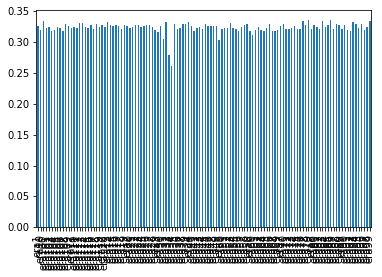

autocorrelation
0.22649224859171524
mean correlation
0.3235059442891586
sharpe
36.84567003961615
smart sharpe
29.196782675268427
[02:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 12s, sys: 180 ms, total: 4min 12s
Wall time: 2min 8s
###############
Iteration 51
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era35', 'era59', 'era113', 'era38', 'era66', 'era41', 'era94', 'era118', 'era3', 'era6', 'era83', 'era45', 'era53', 'era112', 'era88', 'era108', 'era37', 'era100', 'era20', 'era70', 'era67', 'era96', 'era25', 'era9', 'era79', 'era8', 'era13', 'era120', 'era103', 'era77', 'era117', 'era60', 'era65', 'era64', 'era29', 'era52', 'era36', 'era97', 'era15', 'era11', 'era63', 'era75', 'era54', 'era50', 'era115', 'era69', 'era43', 'era32', 'era22', 'era23', 'era104', 'era51', 'era107', 'era99', 'era68', 'era93', 'era44', 'era92', 'era78', 'era109', 'era28', 'era17', 'era106', 'era91', 'era76', 'era86', 'era111', 'era61', 'era40', 'era49', 'era12', 'era7', 'era119', 'era4', 'era72', 'era105', 'era73', 'era2', 'era57', 'era98', 'era82', 'era102', 'era18', 'era62', 'era19', 'era55', 'era46', 'era42', 'era27', 'era87', 'era48', 'era47']
performance over time


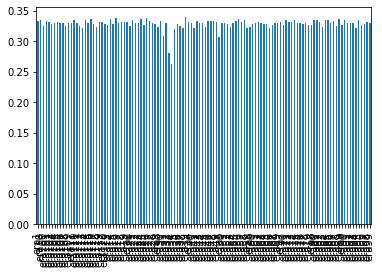

autocorrelation
0.366508215422345
mean correlation
0.32881378046724946
sharpe
36.95963887869312
smart sharpe
25.148532198290816
[02:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 24s, sys: 195 ms, total: 4min 25s
Wall time: 2min 15s
###############
Iteration 52
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era21', 'era56', 'era1', 'era114', 'era81', 'era101', 'era39', 'era58', 'era71', 'era30', 'era59', 'era14', 'era90', 'era116', 'era10', 'era24', 'era9', 'era66', 'era84', 'era74', 'era26', 'era3', 'era53', 'era45', 'era35', 'era85', 'era6', 'era95', 'era113', 'era41', 'era38', 'era117', 'era107', 'era29', 'era70', 'era80', 'era65', 'era89', 'era2', 'era110', 'era69', 'era97', 'era118', 'era16', 'era20', 'era11', 'era93', 'era83', 'era43', 'era88', 'era17', 'era108', 'era112', 'era100', 'era28', 'era75', 'era44', 'era103', 'era12', 'era42', 'era63', 'era8', 'era37', 'era94', 'era61', 'era111', 'era51', 'era36', 'era18', 'era64', 'era50', 'era67', 'era68', 'era32', 'era48', 'era76', 'era72', 'era49', 'era78', 'era87', 'era62', 'era99', 'era54', 'era60', 'era57', 'era13', 'era40', 'era91', 'era104', 'era96', 'era22', 'era23']
performance over time


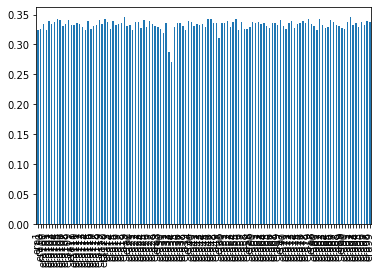

autocorrelation
0.28837643860238826
mean correlation
0.3327469281984
sharpe
36.65362497111927
smart sharpe
27.198496056796362
[02:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 30s, sys: 208 ms, total: 4min 30s
Wall time: 2min 18s
###############
Iteration 53
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era59', 'era77', 'era27', 'era3', 'era73', 'era106', 'era47', 'era115', 'era9', 'era102', 'era52', 'era30', 'era120', 'era6', 'era15', 'era79', 'era25', 'era98', 'era53', 'era80', 'era4', 'era113', 'era119', 'era81', 'era82', 'era58', 'era85', 'era46', 'era105', 'era7', 'era109', 'era35', 'era90', 'era41', 'era56', 'era55', 'era19', 'era21', 'era39', 'era69', 'era101', 'era66', 'era16', 'era65', 'era1', 'era74', 'era92', 'era45', 'era84', 'era2', 'era114', 'era86', 'era29', 'era26', 'era71', 'era37', 'era20', 'era83', 'era95', 'era10', 'era43', 'era38', 'era8', 'era118', 'era14', 'era32', 'era88', 'era76', 'era110', 'era11', 'era116', 'era93', 'era12', 'era75', 'era117', 'era17', 'era108', 'era94', 'era89', 'era100', 'era22', 'era24', 'era104', 'era112', 'era44', 'era103', 'era68', 'era78', 'era67', 'era49', 'era70', 'era28']
performance over time


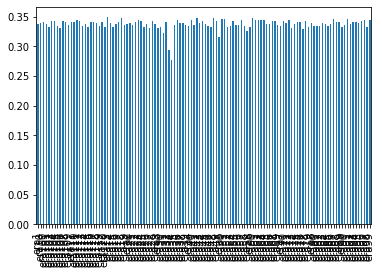

autocorrelation
0.2764107781635156
mean correlation
0.33761795713763865
sharpe
39.00273589096359
smart sharpe
29.316665422422535
[02:55:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 32s, sys: 228 ms, total: 4min 33s
Wall time: 2min 19s
###############
Iteration 54
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era54', 'era15', 'era111', 'era59', 'era3', 'era107', 'era18', 'era63', 'era87', 'era97', 'era81', 'era72', 'era27', 'era36', 'era40', 'era96', 'era48', 'era9', 'era62', 'era42', 'era4', 'era23', 'era58', 'era26', 'era50', 'era57', 'era85', 'era73', 'era29', 'era30', 'era61', 'era2', 'era69', 'era53', 'era102', 'era6', 'era51', 'era47', 'era120', 'era13', 'era98', 'era64', 'era106', 'era1', 'era21', 'era77', 'era91', 'era90', 'era52', 'era25', 'era101', 'era39', 'era60', 'era99', 'era74', 'era71', 'era32', 'era14', 'era65', 'era20', 'era10', 'era46', 'era35', 'era82', 'era22', 'era11', 'era28', 'era119', 'era37', 'era43', 'era7', 'era41', 'era93', 'era66', 'era8', 'era115', 'era113', 'era95', 'era114', 'era80', 'era79', 'era17', 'era49', 'era117', 'era84', 'era86', 'era103', 'era16', 'era38', 'era45', 'era12', 'era44']
performance over time


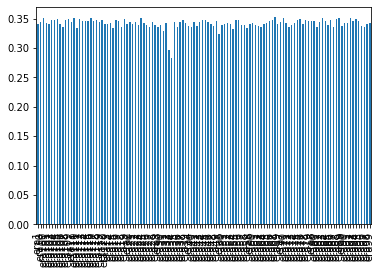

autocorrelation
0.3216422214925804
mean correlation
0.34189311623154883
sharpe
40.15075118139775
smart sharpe
28.731034728209437
[02:58:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 41s, sys: 233 ms, total: 4min 42s
Wall time: 2min 23s
###############
Iteration 55
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era19', 'era78', 'era3', 'era55', 'era59', 'era76', 'era56', 'era88', 'era83', 'era105', 'era89', 'era112', 'era109', 'era30', 'era68', 'era94', 'era104', 'era111', 'era108', 'era75', 'era24', 'era69', 'era54', 'era118', 'era92', 'era67', 'era36', 'era18', 'era23', 'era27', 'era6', 'era40', 'era29', 'era100', 'era63', 'era107', 'era9', 'era62', 'era87', 'era77', 'era15', 'era81', 'era110', 'era116', 'era58', 'era97', 'era73', 'era52', 'era96', 'era57', 'era98', 'era71', 'era2', 'era72', 'era70', 'era74', 'era113', 'era85', 'era102', 'era25', 'era106', 'era48', 'era99', 'era41', 'era91', 'era64', 'era1', 'era42', 'era37', 'era101', 'era90', 'era26', 'era4', 'era7', 'era120', 'era79', 'era61', 'era66', 'era22', 'era20', 'era8', 'era21', 'era53', 'era11', 'era80', 'era119', 'era32', 'era60', 'era49', 'era51', 'era17', 'era43']
performance over time


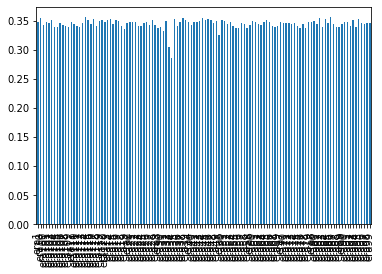

autocorrelation
0.26090649522882736
mean correlation
0.3448729087048528
sharpe
41.17206920198686
smart sharpe
31.463671520950594
[03:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4min 54s, sys: 238 ms, total: 4min 54s
Wall time: 2min 30s
###############
Iteration 56
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era10', 'era117', 'era65', 'era50', 'era47', 'era13', 'era115', 'era38', 'era56', 'era15', 'era114', 'era16', 'era39', 'era111', 'era103', 'era14', 'era59', 'era12', 'era58', 'era28', 'era30', 'era83', 'era3', 'era63', 'era84', 'era9', 'era108', 'era107', 'era44', 'era78', 'era45', 'era69', 'era95', 'era46', 'era68', 'era35', 'era40', 'era36', 'era76', 'era67', 'era93', 'era55', 'era23', 'era48', 'era86', 'era118', 'era29', 'era4', 'era82', 'era72', 'era62', 'era75', 'era42', 'era20', 'era105', 'era104', 'era21', 'era27', 'era94', 'era85', 'era57', 'era89', 'era6', 'era53', 'era26', 'era70', 'era87', 'era18', 'era74', 'era73', 'era100', 'era92', 'era88', 'era54', 'era71', 'era102', 'era106', 'era97', 'era2', 'era112', 'era110', 'era81', 'era98', 'era22', 'era32', 'era51', 'era91', 'era52', 'era96', 'era99', 'era24', 'era116']
performance over time


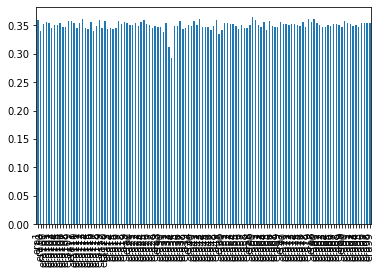

autocorrelation
0.2665575385506075
mean correlation
0.3503462329414082
sharpe
41.744422795309
smart sharpe
31.709753319164285
[03:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5min 1s, sys: 254 ms, total: 5min 1s
Wall time: 2min 33s
###############
Iteration 57
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era19', 'era37', 'era31', 'era109', 'era66', 'era64', 'era113', 'era25', 'era59', 'era7', 'era3', 'era49', 'era90', 'era30', 'era65', 'era77', 'era43', 'era120', 'era41', 'era11', 'era79', 'era83', 'era8', 'era108', 'era78', 'era39', 'era117', 'era50', 'era44', 'era80', 'era93', 'era17', 'era103', 'era101', 'era111', 'era12', 'era118', 'era9', 'era16', 'era67', 'era28', 'era115', 'era1', 'era10', 'era119', 'era38', 'era45', 'era60', 'era23', 'era62', 'era36', 'era84', 'era100', 'era75', 'era40', 'era69', 'era95', 'era55', 'era56', 'era85', 'era107', 'era6', 'era29', 'era47', 'era61', 'era58', 'era76', 'era35', 'era86', 'era88', 'era15', 'era63', 'era112', 'era72', 'era74', 'era104', 'era2', 'era57', 'era54', 'era24', 'era46', 'era98', 'era105', 'era13', 'era114', 'era68', 'era71', 'era89', 'era52', 'era32', 'era94', 'era27', 'era53']
performance over time


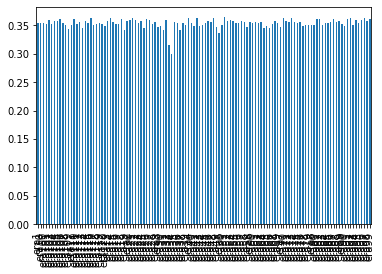

autocorrelation
0.2710142107757957
mean correlation
0.3538284891178168
sharpe
43.61975949499581
smart sharpe
32.97703657213051
[03:08:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5min 11s, sys: 255 ms, total: 5min 11s
Wall time: 2min 38s
###############
Iteration 58
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era31', 'era81', 'era70', 'era37', 'era18', 'era26', 'era48', 'era110', 'era3', 'era1', 'era20', 'era59', 'era21', 'era42', 'era65', 'era116', 'era87', 'era14', 'era73', 'era64', 'era82', 'era41', 'era96', 'era111', 'era102', 'era97', 'era30', 'era99', 'era8', 'era113', 'era91', 'era50', 'era22', 'era117', 'era28', 'era107', 'era66', 'era12', 'era49', 'era19', 'era25', 'era101', 'era51', 'era44', 'era108', 'era106', 'era4', 'era109', 'era39', 'era36', 'era17', 'era43', 'era15', 'era11', 'era10', 'era90', 'era69', 'era78', 'era62', 'era93', 'era9', 'era2', 'era58', 'era32', 'era54', 'era16', 'era27', 'era40', 'era23', 'era115', 'era53', 'era95', 'era77', 'era7', 'era29', 'era74', 'era85', 'era103', 'era38', 'era63', 'era6', 'era67', 'era83', 'era75', 'era61', 'era100', 'era57', 'era56', 'era13', 'era94', 'era79', 'era114', 'era47']
performance over time


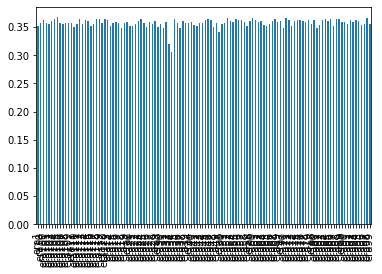

autocorrelation
0.2589909859873742
mean correlation
0.35730816172905727
sharpe
46.64517061250531
smart sharpe
35.7188133476022
[03:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5min 14s, sys: 256 ms, total: 5min 15s
Wall time: 2min 40s
###############
Iteration 59
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era68', 'era60', 'era80', 'era35', 'era3', 'era119', 'era92', 'era45', 'era76', 'era120', 'era72', 'era24', 'era88', 'era59', 'era31', 'era37', 'era89', 'era55', 'era81', 'era46', 'era112', 'era41', 'era104', 'era64', 'era113', 'era118', 'era84', 'era86', 'era20', 'era18', 'era17', 'era117', 'era96', 'era28', 'era98', 'era52', 'era48', 'era7', 'era30', 'era65', 'era49', 'era110', 'era8', 'era75', 'era82', 'era73', 'era102', 'era6', 'era78', 'era21', 'era22', 'era83', 'era108', 'era26', 'era74', 'era70', 'era23', 'era29', 'era106', 'era101', 'era42', 'era105', 'era109', 'era51', 'era99', 'era11', 'era77', 'era111', 'era19', 'era91', 'era71', 'era87', 'era14', 'era67', 'era43', 'era107', 'era66', 'era44', 'era15', 'era69', 'era85', 'era27', 'era90', 'era32', 'era95', 'era4', 'era93', 'era103', 'era40', 'era56', 'era62', 'era116', 'era36']
performance over time


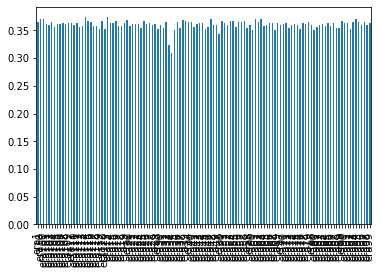

autocorrelation
0.2736318408743948
mean correlation
0.36073282148765823
sharpe
45.512449659003046
smart sharpe
34.31173017999543
[03:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5min 27s, sys: 251 ms, total: 5min 27s
Wall time: 2min 47s
###############
Iteration 60
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era16', 'era12', 'era80', 'era3', 'era25', 'era97', 'era50', 'era54', 'era31', 'era39', 'era57', 'era81', 'era10', 'era63', 'era59', 'era9', 'era47', 'era58', 'era120', 'era53', 'era115', 'era92', 'era2', 'era119', 'era45', 'era1', 'era72', 'era114', 'era42', 'era18', 'era37', 'era76', 'era20', 'era48', 'era118', 'era61', 'era35', 'era100', 'era79', 'era65', 'era38', 'era64', 'era28', 'era21', 'era104', 'era84', 'era117', 'era22', 'era46', 'era68', 'era4', 'era26', 'era105', 'era88', 'era55', 'era94', 'era52', 'era66', 'era98', 'era96', 'era106', 'era102', 'era8', 'era41', 'era49', 'era36', 'era13', 'era17', 'era15', 'era75', 'era116', 'era30', 'era29', 'era108', 'era71', 'era60', 'era11', 'era86', 'era32', 'era99', 'era67', 'era111', 'era70', 'era77', 'era51', 'era95', 'era78', 'era24', 'era83', 'era101', 'era93', 'era82', 'era6']
performance over time


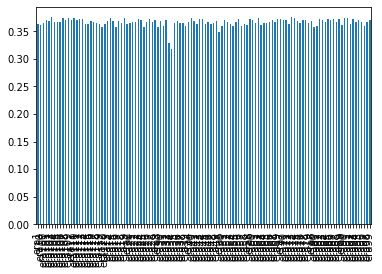

autocorrelation
0.3140468664334727
mean correlation
0.36635617628818945
sharpe
49.09896495622766
smart sharpe
35.42922057955765
[03:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5min 34s, sys: 272 ms, total: 5min 34s
Wall time: 2min 50s
###############
Iteration 61
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era113', 'era69', 'era89', 'era73', 'era74', 'era103', 'era56', 'era91', 'era27', 'era23', 'era110', 'era3', 'era85', 'era16', 'era112', 'era107', 'era81', 'era80', 'era62', 'era90', 'era9', 'era44', 'era31', 'era12', 'era54', 'era43', 'era20', 'era40', 'era19', 'era2', 'era14', 'era7', 'era109', 'era115', 'era58', 'era57', 'era119', 'era18', 'era68', 'era59', 'era97', 'era1', 'era87', 'era39', 'era29', 'era45', 'era88', 'era61', 'era72', 'era22', 'era35', 'era37', 'era50', 'era17', 'era42', 'era53', 'era75', 'era10', 'era25', 'era41', 'era93', 'era104', 'era79', 'era8', 'era28', 'era100', 'era48', 'era76', 'era21', 'era49', 'era11', 'era120', 'era117', 'era30', 'era55', 'era46', 'era63', 'era78', 'era114', 'era98', 'era84', 'era71', 'era64', 'era106', 'era102', 'era26', 'era92', 'era32', 'era47', 'era15', 'era52', 'era111', 'era60']
performance over time


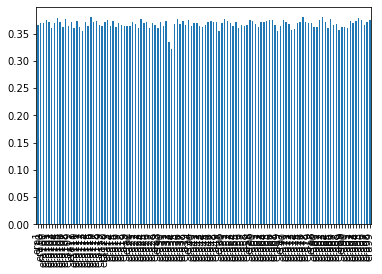

autocorrelation
0.23878354772635843
mean correlation
0.36790854250198446
sharpe
47.25758002640093
smart sharpe
36.968266281885164
[03:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5min 45s, sys: 268 ms, total: 5min 45s
Wall time: 2min 55s
###############
Iteration 62
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era65', 'era118', 'era9', 'era44', 'era113', 'era31', 'era27', 'era4', 'era16', 'era38', 'era96', 'era12', 'era81', 'era85', 'era23', 'era43', 'era94', 'era20', 'era3', 'era37', 'era89', 'era105', 'era82', 'era59', 'era67', 'era6', 'era36', 'era13', 'era51', 'era101', 'era95', 'era108', 'era62', 'era66', 'era99', 'era40', 'era110', 'era83', 'era86', 'era56', 'era54', 'era77', 'era90', 'era70', 'era24', 'era80', 'era57', 'era74', 'era58', 'era2', 'era116', 'era69', 'era10', 'era107', 'era45', 'era97', 'era22', 'era50', 'era109', 'era112', 'era87', 'era73', 'era19', 'era53', 'era25', 'era39', 'era7', 'era91', 'era115', 'era35', 'era29', 'era17', 'era63', 'era21', 'era14', 'era11', 'era72', 'era41', 'era1', 'era30', 'era61', 'era120', 'era111', 'era18', 'era75', 'era48', 'era8', 'era28', 'era78', 'era119', 'era42', 'era103', 'era26']
performance over time


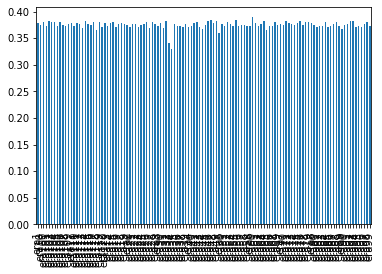

autocorrelation
0.18204860880831245
mean correlation
0.37512683805654506
sharpe
54.305764276453175
smart sharpe
45.056492350395665
[03:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5min 44s, sys: 266 ms, total: 5min 44s
Wall time: 2min 55s
###############
Iteration 63
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era68', 'era15', 'era98', 'era9', 'era31', 'era65', 'era3', 'era104', 'era76', 'era49', 'era88', 'era79', 'era27', 'era117', 'era52', 'era44', 'era106', 'era118', 'era113', 'era85', 'era32', 'era16', 'era12', 'era6', 'era100', 'era84', 'era92', 'era59', 'era80', 'era102', 'era64', 'era20', 'era46', 'era71', 'era69', 'era47', 'era93', 'era114', 'era22', 'era81', 'era23', 'era74', 'era37', 'era94', 'era40', 'era38', 'era96', 'era73', 'era55', 'era67', 'era13', 'era7', 'era89', 'era77', 'era57', 'era24', 'era107', 'era70', 'era95', 'era36', 'era105', 'era108', 'era62', 'era56', 'era2', 'era66', 'era82', 'era43', 'era53', 'era11', 'era60', 'era58', 'era90', 'era103', 'era101', 'era21', 'era54', 'era41', 'era4', 'era112', 'era99', 'era110', 'era51', 'era86', 'era97', 'era91', 'era83', 'era45', 'era87', 'era14', 'era30', 'era116', 'era35']
performance over time


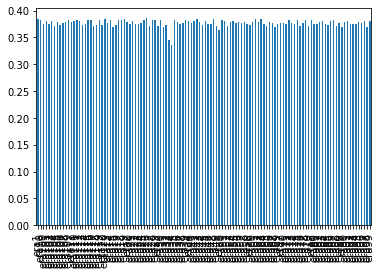

autocorrelation
0.199638797091533
mean correlation
0.3769605745034568
sharpe
58.978692030097854
smart sharpe
48.056216220114486
[03:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6min 2s, sys: 291 ms, total: 6min 2s
Wall time: 3min 4s
###############
Iteration 64
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era25', 'era78', 'era50', 'era31', 'era18', 'era29', 'era9', 'era119', 'era65', 'era98', 'era63', 'era39', 'era109', 'era26', 'era10', 'era48', 'era111', 'era72', 'era15', 'era85', 'era42', 'era68', 'era118', 'era8', 'era19', 'era16', 'era61', 'era3', 'era17', 'era28', 'era12', 'era1', 'era52', 'era93', 'era75', 'era104', 'era120', 'era49', 'era32', 'era40', 'era115', 'era106', 'era88', 'era79', 'era81', 'era59', 'era84', 'era23', 'era100', 'era38', 'era22', 'era44', 'era69', 'era117', 'era66', 'era96', 'era102', 'era4', 'era74', 'era37', 'era95', 'era64', 'era76', 'era108', 'era113', 'era47', 'era107', 'era80', 'era94', 'era27', 'era20', 'era71', 'era87', 'era92', 'era114', 'era77', 'era67', 'era2', 'era58', 'era55', 'era24', 'era11', 'era89', 'era36', 'era7', 'era62', 'era6', 'era90', 'era101', 'era53', 'era13', 'era103', 'era86']
performance over time


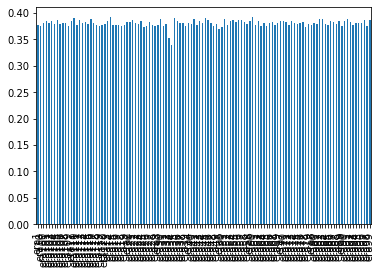

autocorrelation
0.17546478071444999
mean correlation
0.3808528330766098
sharpe
59.305476937609875
smart sharpe
49.53744991473419
[03:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6min 7s, sys: 294 ms, total: 6min 7s
Wall time: 3min 7s
###############
Iteration 65
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era46', 'era54', 'era56', 'era43', 'era31', 'era9', 'era57', 'era41', 'era73', 'era51', 'era30', 'era21', 'era99', 'era91', 'era15', 'era17', 'era25', 'era29', 'era70', 'era18', 'era97', 'era45', 'era82', 'era3', 'era60', 'era83', 'era1', 'era98', 'era65', 'era72', 'era75', 'era26', 'era19', 'era63', 'era68', 'era27', 'era116', 'era78', 'era74', 'era113', 'era61', 'era59', 'era50', 'era105', 'era44', 'era109', 'era85', 'era32', 'era118', 'era48', 'era112', 'era69', 'era39', 'era28', 'era81', 'era12', 'era93', 'era117', 'era89', 'era22', 'era49', 'era16', 'era37', 'era111', 'era20', 'era110', 'era6', 'era8', 'era88', 'era14', 'era2', 'era10', 'era67', 'era4', 'era80', 'era71', 'era107', 'era106', 'era119', 'era35', 'era23', 'era100', 'era84', 'era115', 'era52', 'era96', 'era40', 'era104', 'era79', 'era42', 'era36', 'era64', 'era38']
performance over time


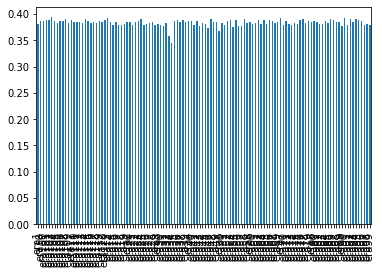

autocorrelation
0.199460870670517
mean correlation
0.38397549078529275
sharpe
63.350203828428256
smart sharpe
51.62763141440162
[03:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6min 25s, sys: 328 ms, total: 6min 25s
Wall time: 3min 16s
###############
Iteration 66
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era9', 'era108', 'era11', 'era102', 'era92', 'era95', 'era76', 'era62', 'era120', 'era66', 'era87', 'era101', 'era24', 'era43', 'era7', 'era31', 'era78', 'era30', 'era114', 'era58', 'era73', 'era53', 'era13', 'era103', 'era54', 'era98', 'era70', 'era56', 'era41', 'era77', 'era3', 'era55', 'era46', 'era94', 'era17', 'era63', 'era21', 'era47', 'era65', 'era25', 'era8', 'era99', 'era97', 'era90', 'era51', 'era22', 'era68', 'era18', 'era75', 'era6', 'era57', 'era32', 'era15', 'era12', 'era105', 'era86', 'era50', 'era116', 'era23', 'era91', 'era29', 'era27', 'era72', 'era111', 'era16', 'era74', 'era45', 'era82', 'era107', 'era44', 'era20', 'era112', 'era37', 'era48', 'era93', 'era28', 'era61', 'era52', 'era69', 'era39', 'era109', 'era83', 'era26', 'era59', 'era100', 'era49', 'era117', 'era96', 'era4', 'era118', 'era81', 'era42', 'era85']
performance over time


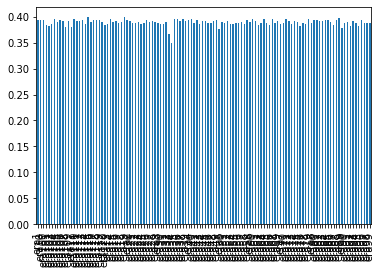

autocorrelation
0.14063923892889157
mean correlation
0.38925207115004573
sharpe
65.82315417566053
smart sharpe
56.96328623557129
[03:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6min 53s, sys: 308 ms, total: 6min 54s
Wall time: 3min 30s
###############
Iteration 67
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era40', 'era113', 'era60', 'era80', 'era110', 'era1', 'era35', 'era119', 'era11', 'era88', 'era79', 'era84', 'era106', 'era3', 'era67', 'era19', 'era14', 'era89', 'era62', 'era104', 'era64', 'era78', 'era2', 'era38', 'era102', 'era43', 'era36', 'era71', 'era76', 'era17', 'era54', 'era31', 'era41', 'era101', 'era15', 'era30', 'era108', 'era66', 'era115', 'era120', 'era74', 'era73', 'era98', 'era77', 'era68', 'era9', 'era92', 'era95', 'era45', 'era70', 'era65', 'era27', 'era29', 'era32', 'era87', 'era44', 'era6', 'era7', 'era10', 'era18', 'era24', 'era55', 'era109', 'era22', 'era103', 'era111', 'era53', 'era46', 'era90', 'era57', 'era56', 'era13', 'era75', 'era25', 'era21', 'era58', 'era91', 'era8', 'era69', 'era51', 'era37', 'era49', 'era12', 'era99', 'era94', 'era59', 'era72', 'era97', 'era112', 'era52', 'era107', 'era118', 'era48']
performance over time


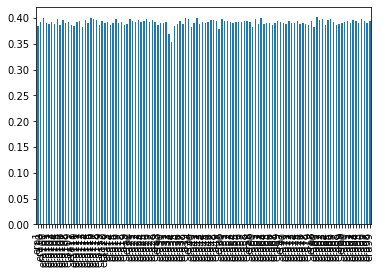

autocorrelation
0.17060950116759402
mean correlation
0.3916532625554226
sharpe
66.63669219935842
smart sharpe
55.937969154991144
[03:49:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7min 5s, sys: 289 ms, total: 7min 5s
Wall time: 3min 36s
###############
Iteration 68
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era114', 'era105', 'era16', 'era47', 'era116', 'era4', 'era63', 'era86', 'era81', 'era82', 'era23', 'era36', 'era93', 'era83', 'era42', 'era50', 'era71', 'era20', 'era117', 'era9', 'era40', 'era61', 'era28', 'era26', 'era96', 'era11', 'era3', 'era106', 'era80', 'era39', 'era85', 'era79', 'era119', 'era88', 'era65', 'era1', 'era66', 'era31', 'era2', 'era58', 'era95', 'era100', 'era35', 'era38', 'era67', 'era32', 'era108', 'era10', 'era102', 'era98', 'era87', 'era115', 'era84', 'era43', 'era22', 'era53', 'era21', 'era29', 'era113', 'era78', 'era48', 'era54', 'era62', 'era64', 'era104', 'era44', 'era90', 'era41', 'era19', 'era56', 'era30', 'era107', 'era89', 'era14', 'era92', 'era76', 'era12', 'era13', 'era101', 'era70', 'era120', 'era8', 'era60', 'era57', 'era103', 'era77', 'era111', 'era37', 'era15', 'era45', 'era68', 'era27', 'era59']
performance over time


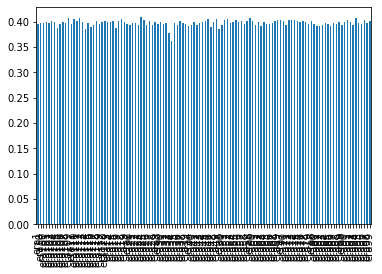

autocorrelation
0.211933067555926
mean correlation
0.3979442590103249
sharpe
65.99027387453506
smart sharpe
53.089617231516705
[03:54:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7min 20s, sys: 368 ms, total: 7min 20s
Wall time: 3min 44s
###############
Iteration 69
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era74', 'era73', 'era75', 'era49', 'era17', 'era109', 'era91', 'era6', 'era18', 'era99', 'era69', 'era25', 'era110', 'era46', 'era93', 'era113', 'era36', 'era16', 'era40', 'era114', 'era117', 'era24', 'era55', 'era72', 'era20', 'era31', 'era81', 'era52', 'era7', 'era118', 'era119', 'era83', 'era97', 'era85', 'era22', 'era82', 'era94', 'era1', 'era78', 'era86', 'era51', 'era2', 'era9', 'era63', 'era50', 'era47', 'era28', 'era71', 'era96', 'era23', 'era116', 'era88', 'era112', 'era66', 'era105', 'era67', 'era65', 'era4', 'era58', 'era39', 'era84', 'era62', 'era79', 'era54', 'era61', 'era108', 'era80', 'era60', 'era89', 'era11', 'era15', 'era26', 'era29', 'era43', 'era42', 'era106', 'era90', 'era27', 'era30', 'era102', 'era100', 'era32', 'era38', 'era104', 'era3', 'era8', 'era41', 'era53', 'era64', 'era37', 'era57', 'era103', 'era107']
performance over time


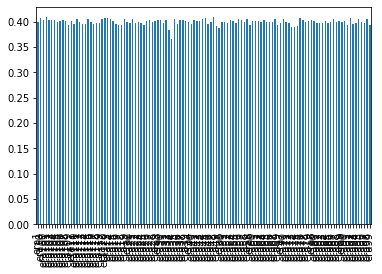

autocorrelation
0.15643023646895454
mean correlation
0.39965306152149677
sharpe
71.61450000242452
smart sharpe
60.990995631463086
[04:00:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7min 41s, sys: 365 ms, total: 7min 41s
Wall time: 3min 55s
###############
Iteration 70
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era5', 'era74', 'era87', 'era95', 'era21', 'era44', 'era68', 'era59', 'era56', 'era70', 'era35', 'era111', 'era101', 'era75', 'era72', 'era12', 'era49', 'era77', 'era76', 'era115', 'era98', 'era36', 'era48', 'era118', 'era14', 'era114', 'era17', 'era117', 'era31', 'era73', 'era16', 'era120', 'era20', 'era69', 'era97', 'era6', 'era99', 'era10', 'era45', 'era92', 'era40', 'era19', 'era58', 'era63', 'era46', 'era67', 'era13', 'era51', 'era83', 'era91', 'era93', 'era18', 'era109', 'era84', 'era110', 'era86', 'era25', 'era65', 'era11', 'era52', 'era85', 'era9', 'era23', 'era7', 'era105', 'era47', 'era22', 'era42', 'era50', 'era55', 'era96', 'era78', 'era112', 'era15', 'era81', 'era119', 'era2', 'era116', 'era106', 'era82', 'era54', 'era108', 'era26', 'era4', 'era104', 'era71', 'era28', 'era53', 'era24', 'era94', 'era8', 'era30', 'era27', 'era43']
performance over time


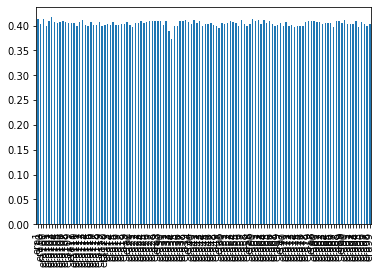

autocorrelation
0.28204135721256574
mean correlation
0.4046286212046662
sharpe
75.65069246831526
smart sharpe
56.52053437679642
[04:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7min 45s, sys: 364 ms, total: 7min 45s
Wall time: 3min 57s
###############
Iteration 71
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era88', 'era5', 'era62', 'era3', 'era41', 'era113', 'era29', 'era107', 'era79', 'era89', 'era66', 'era1', 'era37', 'era80', 'era61', 'era90', 'era39', 'era102', 'era20', 'era74', 'era49', 'era69', 'era32', 'era35', 'era103', 'era12', 'era111', 'era44', 'era68', 'era16', 'era91', 'era17', 'era11', 'era75', 'era57', 'era93', 'era31', 'era98', 'era59', 'era40', 'era38', 'era87', 'era73', 'era21', 'era100', 'era56', 'era64', 'era36', 'era9', 'era22', 'era60', 'era48', 'era70', 'era52', 'era14', 'era115', 'era76', 'era19', 'era23', 'era71', 'era2', 'era95', 'era101', 'era72', 'era45', 'era109', 'era67', 'era77', 'era120', 'era46', 'era65', 'era13', 'era81', 'era114', 'era18', 'era99', 'era78', 'era97', 'era117', 'era28', 'era7', 'era119', 'era30', 'era85', 'era105', 'era6', 'era92', 'era15', 'era63', 'era86', 'era118', 'era58', 'era116', 'era51']
performance over time


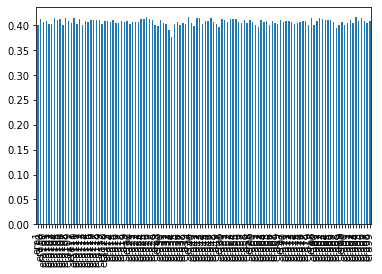

autocorrelation
0.19992284384682002
mean correlation
0.40725114029457854
sharpe
72.41391656761249
smart sharpe
58.986027489088
[04:11:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 8min 10s, sys: 392 ms, total: 8min 10s
Wall time: 4min 9s
###############
Iteration 72
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era27', 'era10', 'era3', 'era54', 'era37', 'era5', 'era83', 'era50', 'era74', 'era53', 'era29', 'era84', 'era106', 'era25', 'era55', 'era8', 'era22', 'era47', 'era42', 'era104', 'era62', 'era75', 'era41', 'era88', 'era11', 'era111', 'era32', 'era107', 'era17', 'era21', 'era24', 'era44', 'era4', 'era40', 'era80', 'era110', 'era26', 'era79', 'era49', 'era31', 'era66', 'era69', 'era1', 'era68', 'era96', 'era117', 'era39', 'era12', 'era82', 'era36', 'era43', 'era70', 'era113', 'era48', 'era35', 'era112', 'era98', 'era89', 'era57', 'era102', 'era56', 'era65', 'era20', 'era72', 'era90', 'era59', 'era108', 'era67', 'era45', 'era52', 'era6', 'era73', 'era93', 'era94', 'era16', 'era77', 'era61', 'era38', 'era91', 'era118', 'era15', 'era60', 'era9', 'era100', 'era19', 'era71', 'era114', 'era64', 'era30', 'era81', 'era51', 'era85', 'era78', 'era58']
performance over time


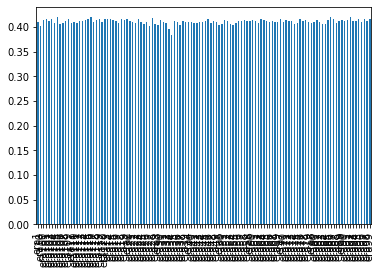

autocorrelation
0.2398979769031737
mean correlation
0.4114209479818811
sharpe
86.622780960108
smart sharpe
67.68324092508227
[04:17:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 8min 16s, sys: 375 ms, total: 8min 16s
Wall time: 4min 13s
###############
Iteration 73
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era63', 'era95', 'era76', 'era87', 'era23', 'era5', 'era3', 'era97', 'era105', 'era103', 'era120', 'era7', 'era109', 'era18', 'era54', 'era13', 'era29', 'era101', 'era115', 'era119', 'era74', 'era92', 'era37', 'era27', 'era14', 'era16', 'era28', 'era22', 'era11', 'era8', 'era32', 'era88', 'era2', 'era10', 'era53', 'era50', 'era80', 'era107', 'era99', 'era116', 'era25', 'era20', 'era42', 'era46', 'era102', 'era108', 'era72', 'era84', 'era4', 'era106', 'era66', 'era24', 'era111', 'era83', 'era75', 'era104', 'era41', 'era96', 'era47', 'era44', 'era31', 'era36', 'era112', 'era62', 'era40', 'era81', 'era117', 'era39', 'era61', 'era68', 'era78', 'era17', 'era82', 'era52', 'era26', 'era57', 'era9', 'era86', 'era55', 'era79', 'era69', 'era93', 'era89', 'era38', 'era90', 'era98', 'era49', 'era94', 'era48', 'era77', 'era21', 'era65', 'era35', 'era110']
performance over time


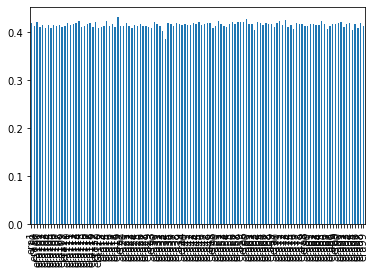

autocorrelation
0.03768633322772531
mean correlation
0.41576708862708067
sharpe
77.02261450430649
smart sharpe
73.88614721362603
[04:23:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 8min 43s, sys: 401 ms, total: 8min 43s
Wall time: 4min 26s
###############
Iteration 74
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era33', 'era113', 'era43', 'era118', 'era15', 'era59', 'era5', 'era3', 'era30', 'era6', 'era12', 'era67', 'era54', 'era45', 'era64', 'era91', 'era85', 'era56', 'era74', 'era2', 'era70', 'era51', 'era27', 'era71', 'era22', 'era31', 'era8', 'era73', 'era120', 'era23', 'era95', 'era18', 'era114', 'era37', 'era29', 'era100', 'era87', 'era1', 'era17', 'era63', 'era115', 'era109', 'era46', 'era101', 'era58', 'era53', 'era76', 'era60', 'era19', 'era97', 'era99', 'era106', 'era117', 'era72', 'era41', 'era11', 'era83', 'era69', 'era105', 'era107', 'era28', 'era21', 'era32', 'era111', 'era7', 'era13', 'era57', 'era44', 'era103', 'era119', 'era26', 'era65', 'era10', 'era88', 'era50', 'era96', 'era40', 'era20', 'era14', 'era108', 'era92', 'era84', 'era16', 'era36', 'era98', 'era39', 'era42', 'era75', 'era25', 'era93', 'era24', 'era89', 'era104', 'era62', 'era49']
performance over time


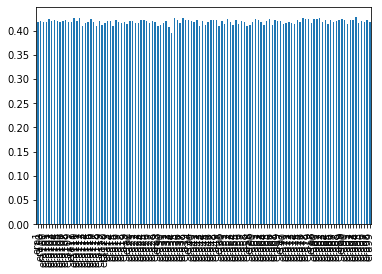

autocorrelation
0.01823095326552171
mean correlation
0.41835837005145315
sharpe
86.12370936074234
smart sharpe
84.2273460529806
[04:29:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 9min 9s, sys: 399 ms, total: 9min 10s
Wall time: 4min 40s
###############
Iteration 75
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era5', 'era33', 'era9', 'era78', 'era47', 'era116', 'era59', 'era86', 'era52', 'era90', 'era43', 'era80', 'era68', 'era81', 'era61', 'era95', 'era48', 'era15', 'era102', 'era12', 'era79', 'era64', 'era112', 'era66', 'era74', 'era23', 'era22', 'era30', 'era118', 'era2', 'era55', 'era67', 'era3', 'era4', 'era8', 'era70', 'era29', 'era35', 'era38', 'era113', 'era85', 'era82', 'era87', 'era37', 'era45', 'era11', 'era63', 'era6', 'era1', 'era18', 'era77', 'era71', 'era27', 'era20', 'era58', 'era91', 'era76', 'era56', 'era107', 'era110', 'era100', 'era31', 'era105', 'era28', 'era53', 'era16', 'era108', 'era54', 'era13', 'era120', 'era44', 'era17', 'era88', 'era41', 'era94', 'era51', 'era83', 'era7', 'era73', 'era111', 'era117', 'era119', 'era65', 'era103', 'era114', 'era72', 'era115', 'era101', 'era106', 'era99', 'era69', 'era14', 'era75', 'era36', 'era32']
performance over time


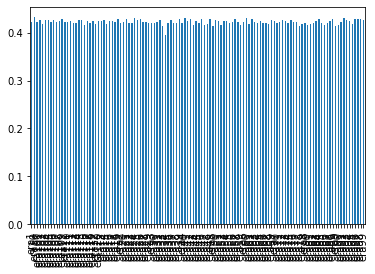

autocorrelation
0.03475886446081933
mean correlation
0.42250858412130715
sharpe
86.74388800041918
smart sharpe
83.45378912274074
[04:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 9min 14s, sys: 468 ms, total: 9min 14s
Wall time: 4min 42s
###############
Iteration 76
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era9', 'era5', 'era78', 'era62', 'era19', 'era50', 'era39', 'era33', 'era81', 'era52', 'era21', 'era97', 'era104', 'era60', 'era49', 'era3', 'era26', 'era109', 'era96', 'era89', 'era2', 'era93', 'era43', 'era15', 'era84', 'era57', 'era42', 'era116', 'era98', 'era59', 'era46', 'era30', 'era25', 'era6', 'era12', 'era40', 'era67', 'era86', 'era68', 'era48', 'era29', 'era58', 'era90', 'era10', 'era11', 'era66', 'era118', 'era37', 'era8', 'era74', 'era102', 'era4', 'era24', 'era87', 'era77', 'era47', 'era61', 'era71', 'era95', 'era31', 'era55', 'era110', 'era18', 'era64', 'era85', 'era92', 'era82', 'era80', 'era22', 'era1', 'era79', 'era70', 'era113', 'era23', 'era91', 'era100', 'era54', 'era76', 'era112', 'era107', 'era36', 'era106', 'era45', 'era27', 'era35', 'era53', 'era17', 'era44', 'era111', 'era73', 'era56', 'era63', 'era65', 'era38', 'era108']
performance over time


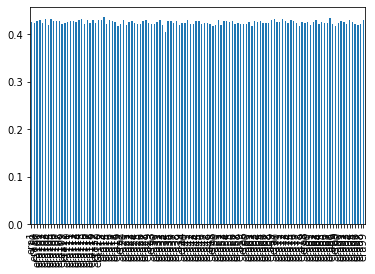

autocorrelation
0.013638666590050388
mean correlation
0.4253150019849317
sharpe
98.03429046130829
smart sharpe
96.3133918099598
[04:42:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 9min 23s, sys: 473 ms, total: 9min 24s
Wall time: 4min 47s
###############
Iteration 77
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era20', 'era117', 'era16', 'era78', 'era72', 'era51', 'era33', 'era103', 'era9', 'era5', 'era83', 'era105', 'era13', 'era62', 'era3', 'era120', 'era15', 'era69', 'era114', 'era28', 'era119', 'era59', 'era32', 'era74', 'era81', 'era88', 'era21', 'era52', 'era49', 'era40', 'era115', 'era94', 'era41', 'era7', 'era26', 'era97', 'era93', 'era29', 'era50', 'era46', 'era42', 'era104', 'era57', 'era118', 'era14', 'era58', 'era68', 'era99', 'era30', 'era75', 'era89', 'era8', 'era98', 'era22', 'era48', 'era96', 'era39', 'era109', 'era90', 'era31', 'era43', 'era102', 'era12', 'era2', 'era85', 'era101', 'era61', 'era6', 'era23', 'era4', 'era79', 'era37', 'era84', 'era87', 'era18', 'era25', 'era67', 'era91', 'era47', 'era86', 'era77', 'era66', 'era55', 'era60', 'era106', 'era19', 'era17', 'era113', 'era92', 'era44', 'era64', 'era107', 'era116', 'era10', 'era35']
performance over time


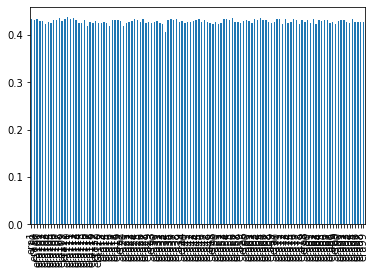

autocorrelation
0.15728880386622182
mean correlation
0.42863553729309467
sharpe
99.63600164350238
smart sharpe
84.78170151117813
[04:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 9min 28s, sys: 444 ms, total: 9min 29s
Wall time: 4min 49s
###############
Iteration 78
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era117', 'era20', 'era9', 'era63', 'era70', 'era95', 'era73', 'era76', 'era5', 'era11', 'era27', 'era72', 'era82', 'era80', 'era24', 'era111', 'era100', 'era54', 'era45', 'era38', 'era33', 'era65', 'era71', 'era51', 'era53', 'era36', 'era56', 'era16', 'era1', 'era78', 'era15', 'era13', 'era114', 'era81', 'era110', 'era46', 'era62', 'era108', 'era42', 'era83', 'era50', 'era112', 'era30', 'era6', 'era21', 'era32', 'era118', 'era40', 'era3', 'era52', 'era69', 'era28', 'era104', 'era99', 'era74', 'era59', 'era2', 'era41', 'era57', 'era75', 'era12', 'era29', 'era39', 'era8', 'era18', 'era26', 'era102', 'era119', 'era58', 'era97', 'era85', 'era105', 'era31', 'era94', 'era93', 'era120', 'era48', 'era89', 'era101', 'era68', 'era115', 'era22', 'era77', 'era96', 'era14', 'era84', 'era49', 'era87', 'era98', 'era4', 'era7', 'era43', 'era37', 'era107', 'era61']
performance over time


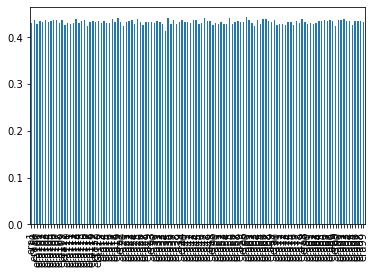

autocorrelation
-0.10379939962628132
mean correlation
0.43284884247557165
sharpe
96.54440760716331
smart sharpe
106.60388172613962
[04:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 9min 18s, sys: 447 ms, total: 9min 18s
Wall time: 4min 44s
###############
Iteration 79
###############
predicting on train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
['era34', 'era88', 'era20', 'era103', 'era23', 'era5', 'era109', 'era44', 'era80', 'era113', 'era91', 'era25', 'era90', 'era11', 'era66', 'era33', 'era3', 'era9', 'era117', 'era72', 'era79', 'era92', 'era24', 'era67', 'era64', 'era86', 'era78', 'era17', 'era60', 'era54', 'era116', 'era73', 'era112', 'era111', 'era62', 'era106', 'era19', 'era76', 'era47', 'era45', 'era63', 'era16', 'era65', 'era100', 'era81', 'era38', 'era35', 'era53', 'era27', 'era41', 'era71', 'era70', 'era52', 'era55', 'era95', 'era40', 'era29', 'era28', 'era36', 'era75', 'era2', 'era15', 'era108', 'era74', 'era69', 'era32', 'era1', 'era8', 'era59', 'era30', 'era10', 'era82', 'era12', 'era83', 'era119', 'era37', 'era31', 'era50', 'era105', 'era49', 'era39', 'era68', 'era13', 'era89', 'era18', 'era22', 'era51', 'era115', 'era7', 'era85', 'era104', 'era118', 'era120', 'era21', 'era98', 'era6']
performance over time


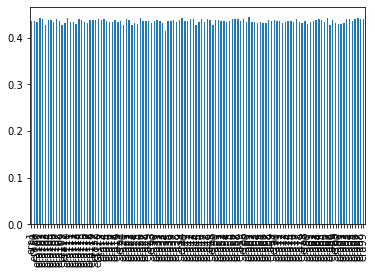

autocorrelation
0.02992727003756563
mean correlation
0.4354877863876665
sharpe
102.50474727659062
smart sharpe
99.09098394522417
[05:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Add validation eras to training_data and train on eras and iterate on bad eras

#val_subset = validation_data[validation_data.era.isin(validation_data.era.unique()[0:14])]
#val_subset = val_subset.drop(['id','data_type'],axis=1)
#era_training_data = pd.concat([training_data,val_subset])
era_training_data = training_data
era_training_data = era_training_data.reset_index(drop=True)
num_models = 5
model_num=1
#for model_num in np.arange(1,num_models+1):
print(f'%%%%%%%%%%%%%%%')
print(f'Training Model {model_num}')
print(f'%%%%%%%%%%%%%%%')
[X_train, y_train] = reduce_training_data(era_training_data,100000)
[boost_model, corr, s_sharpe] = era_boost_train(X_train, y_train, era_col=era_training_data["era"], val_data=validation_data, proportion=0.8, trees_per_step=10, num_iters=100)
import pickle
fn = f'./drive/MyDrive/numerai/numerai_dataset_{CURRENT_DATASET}/era_boosted_model{model_num}.pkl'
pickle.dump(boost_model, open(fn, 'wb'))

In [ ]:
print(np.shape(training_data.era.unique()))

(120,)


## Load models

In [ ]:
import pickle
CURRENT_DATASET = 265
fn=f'./drive/MyDrive/numerai/era_boosted_model1.pkl'
model_1 = pickle.load(open(fn, 'rb'))

fn=f'./drive/MyDrive/numerai/era_boosted_model2.pkl'
model_2 = pickle.load(open(fn, 'rb'))

fn=f'./drive/MyDrive/numerai/era_boosted_model3.pkl'
model_3 = pickle.load(open(fn, 'rb'))

fn=f'./drive/MyDrive/numerai/era_boosted_model4.pkl'
model_4 = pickle.load(open(fn, 'rb'))

fn=f'./drive/MyDrive/numerai/era_boosted_model5.pkl'
model_5 = pickle.load(open(fn, 'rb'))

fn=f'./drive/MyDrive/numerai/era_boosted_model_iterative.pkl'
model_full = pickle.load(open(fn, 'rb'))

FileNotFoundError: ignored

# Run validation

predicting on val data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


getting per era scores
['era211', 'era199', 'era210', 'era201', 'era127', 'era206', 'era121', 'era205', 'era198', 'era125', 'era200', 'era212', 'era131', 'era130']
performance over time


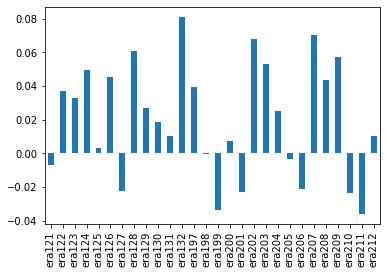

autocorrelation
0.037879863536577074
mean correlation
0.02039510455388004
sharpe
0.6096819988309895
smart sharpe
0.5772135626341163
predicting on val data
getting per era scores
['era199', 'era211', 'era127', 'era206', 'era204', 'era205', 'era198', 'era131', 'era212', 'era121', 'era201', 'era208', 'era129', 'era200']
performance over time


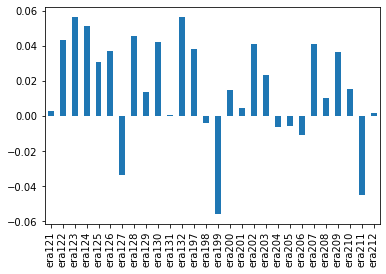

autocorrelation
0.08810115434631242
mean correlation
0.015924760553705977
sharpe
0.5439838290665563
smart sharpe
0.4905791915349819
predicting on val data
getting per era scores
['era211', 'era208', 'era200', 'era204', 'era203', 'era210', 'era130', 'era207', 'era122', 'era197', 'era129', 'era201', 'era126', 'era124']
performance over time


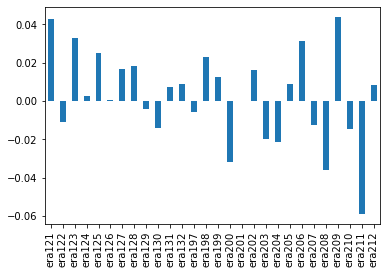

autocorrelation
-0.16307843700348745
mean correlation
0.0023950805900697374
sharpe
0.10170623878275319
smart sharpe
0.11703869501996235
predicting on val data
getting per era scores
['era199', 'era210', 'era201', 'era206', 'era127', 'era198', 'era205', 'era121', 'era203', 'era129', 'era212', 'era123', 'era211', 'era200']
performance over time


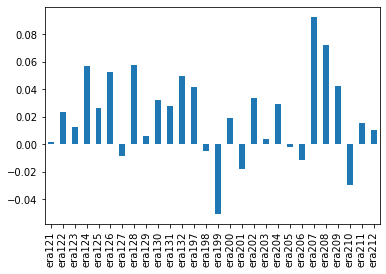

autocorrelation
0.03940851085236578
mean correlation
0.020809331703810156
sharpe
0.6708078156683973
smart sharpe
0.6341474859985791
predicting on val data
getting per era scores
['era210', 'era211', 'era206', 'era199', 'era198', 'era200', 'era129', 'era125', 'era205', 'era127', 'era131', 'era124', 'era212', 'era201']
performance over time


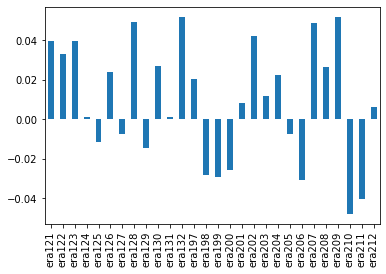

autocorrelation
0.08722288658443425
mean correlation
0.00945485306865359
sharpe
0.3191928816523473
smart sharpe
0.2881022716882401


In [ ]:
# Fit on validation dataset and compare correlation on eras

models = [model_1, model_2, model_3, model_4, model_5] #Last model generated, need to load others separately
for model in models:
  proportion = 0.5
  # score each era
  feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]
  X = validation_data[feature_names]
  new_df = X.copy()
  new_df["target"] = validation_data.target
  new_df["era"] = validation_data.era
  print("predicting on val data")
  preds = model.predict(X)
  new_df["pred"] = preds
  era_scores = pd.Series(index=new_df["era"].unique())
  print("getting per era scores")
  for era in new_df["era"].unique():
      era_df = new_df[new_df["era"] == era]
      era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
  era_scores.sort_values(inplace=True)
  worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
  print(list(worst_eras))
  worst_df = new_df[new_df["era"].isin(worst_eras)]
  era_scores.sort_index(inplace=True)
  era_scores.plot(kind="bar")
  print("performance over time")
  plt.show()
  print("autocorrelation")
  print(ar1(era_scores))
  print("mean correlation")
  print(np.mean(era_scores))
  print("sharpe")
  print(np.mean(era_scores)/np.std(era_scores))
  print("smart sharpe")
  print(smart_sharpe(era_scores))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


getting per era scores
['era211', 'era199', 'era201', 'era206', 'era212', 'era210', 'era205', 'era203', 'era208', 'era204', 'era200', 'era202', 'era198', 'era131']
performance over time


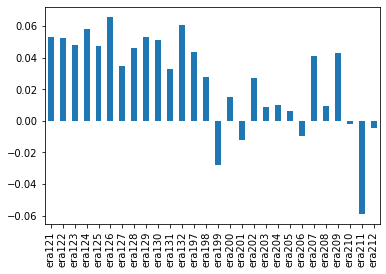

autocorrelation
0.4996393429988796
mean correlation
0.025771894555404906
sharpe
0.8650993055455752
smart sharpe
0.5028038558225364


[0.025771894555404906, 0.5028038558225364]

In [ ]:
def score_on_eras(df,preds):
    proportion = 0.5
    new_df = df.copy()
    new_df["target"] = df.target
    new_df["era"] = df.era
    new_df["pred"] = preds
    era_scores = pd.Series(index=new_df["era"].unique())
    print("getting per era scores")
    for era in new_df["era"].unique():
        era_df = new_df[new_df["era"] == era]
        era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
    era_scores.sort_values(inplace=True)
    worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
    print(list(worst_eras))
    worst_df = new_df[new_df["era"].isin(worst_eras)]
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.show()
    print("autocorrelation")
    print(ar1(era_scores))
    print("mean correlation")
    corr = np.mean(era_scores)
    print(corr)
    print("sharpe")
    sharpe = np.mean(era_scores)/np.std(era_scores)
    print(sharpe)
    print("smart sharpe")
    s_sharpe = smart_sharpe(era_scores)
    print(s_sharpe)
    return [corr, s_sharpe]
#X = validation_data[feature_names]
#preds = model_1.predict(X)
score_on_eras(validation_data,preds)

In [ ]:
validation_data = live_data[live_data['data_type']=='validation']
feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]

X_test = validation_data[feature_names]
y_test = validation_data['target']
y_pred = model_1.predict(X_test)
target = y_test
print(np.corrcoef(target,y_pred)[0][1])
new_df = {'y_test':y_test,'y_pred':y_pred,'era':validation_data.era}
new_df = pd.DataFrame(new_df)
era_scores = pd.Series(index=new_df["era"].unique())
for era in new_df["era"].unique():
    era_df = new_df[new_df['era'] == era]
    era_scores[era] = spearmanr(era_df['y_pred'], era_df['y_test'])
era_scores.sort_values(inplace=True)
era_scores.sort_index(inplace=True)
era_scores.plot(kind="bar")
print("performance over time")
plt.show()

0.05064658384368778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


performance over time


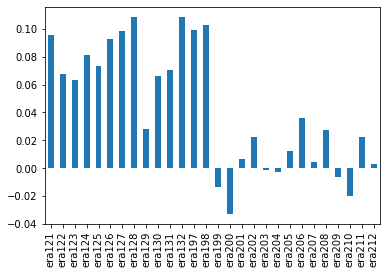

In [ ]:
print(np.corrcoef(target,y_pred)[0][1])
new_df = {'y_test':y_test,'y_pred':y_pred,'era':validation_data.era}
new_df = pd.DataFrame(new_df)
era_scores = pd.Series(index=new_df["era"].unique())
for era in new_df["era"].unique():
    era_df = new_df[new_df['era'] == era]
    era_scores[era] = spearmanr(era_df['y_pred'], era_df['y_test'])
era_scores.sort_values(inplace=True)
era_scores.sort_index(inplace=True)
era_scores.plot(kind="bar")
print("performance over time")
plt.show()

In [ ]:
training_data

,era,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,...,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target,feature_intelligence_mean,feature_intelligence_std,feature_intelligence_skew,feature_wisdom_mean,feature_wisdom_std,feature_wisdom_skew,feature_charisma_mean,feature_charisma_std,feature_charisma_skew,feature_dexterity_mean,feature_dexterity_std,feature_dexterity_skew,feature_strength_mean,feature_strength_std,feature_strength_skew,feature_constitution_mean,feature_constitution_std,feature_constitution_skew,feature_intelligence_mean_feature_wisdom_mean,feature_intelligence_mean_feature_charisma_mean,feature_intelligence_mean_feature_dexterity_mean,feature_intelligence_mean_feature_strength_mean,feature_intelligence_mean_feature_constitution_mean,feature_wisdom_mean_feature_charisma_mean,feature_wisdom_mean_feature_dexterity_mean,feature_wisdom_mean_feature_strength_mean,feature_wisdom_mean_feature_constitution_mean,feature_charisma_mean_feature_dexterity_mean,feature_charisma_mean_feature_strength_mean,feature_charisma_mean_feature_constitution_mean,feature_dexterity_mean_feature_strength_mean,feature_dexterity_mean_feature_constitution_mean,feature_strength_mean_feature_constitution_mean
0,era1,0.00,0.50,0.25,0.00,0.50,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.50,1.00,0.50,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.50,0.50,0.75,0.50,0.25,0.75,...,0.50,0.75,0.50,1.00,0.50,0.75,0.50,0.333252,0.246094,0.558594,0.668457,0.235962,-0.115051,0.438965,0.260010,-0.004784,0.696289,0.200439,-0.607910,0.480225,0.292236,-0.372070,0.427734,0.275635,0.276123,-0.335205,-0.105713,-0.363037,-0.146973,-0.094482,0.229492,-0.027832,0.188232,0.240723,-0.257324,-0.041260,0.011230,0.216064,0.268555,0.052490
1,era1,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.50,0.50,0.50,0.50,0.25,0.25,0.50,0.00,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.50,0.25,0.75,0.50,0.50,0.50,...,0.00,0.75,0.25,0.00,0.25,1.00,0.25,0.208374,0.234253,0.382568,0.559570,0.358398,-0.062347,0.485352,0.252441,-0.021729,0.267822,0.249268,0.382324,0.407959,0.309570,0.220703,0.644531,0.333008,-0.794922,-0.351074,-0.276855,-0.059448,-0.199585,-0.436035,0.074219,0.291748,0.151611,-0.084961,0.217529,0.077393,-0.159180,-0.140137,-0.376709,-0.236572
2,era1,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.50,0.50,1.00,0.50,0.50,0.50,0.25,0.00,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.50,0.50,0.75,0.50,0.50,0.25,...,0.00,0.50,1.00,0.00,0.25,0.75,0.25,0.479248,0.327881,0.470947,0.635742,0.367676,-0.548340,0.529297,0.249268,-0.600586,0.446533,0.356201,0.624512,0.203979,0.289795,1.258789,0.418945,0.331543,0.179810,-0.156494,-0.050049,0.032715,0.275391,0.060303,0.106445,0.189209,0.431641,0.216797,0.082764,0.325195,0.110352,0.242554,0.027588,-0.214966
3,era1,1.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.00,0.50,0.50,0.00,1.00,0.00,0.75,0.00,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.50,0.50,0.50,0.50,0.50,0.50,...,0.75,1.00,1.00,0.75,1.00,1.00,0.25,0.416748,0.288574,0.362305,0.831543,0.230103,-2.142578,0.529297,0.242920,-0.238037,0.232178,0.118713,-0.308350,0.394775,

# Ensemble

In [ ]:
# Load existing ensemble model

fn=f'./drive/MyDrive/numerai/ensemble_model.pkl'
ens_model = pickle.load(open(fn, 'rb'))

[17:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Ensemble the 5 models to create final model

params={'max_depth':3,
        'learning_rate':0.005,
        'n_estimators':1000,
        'n_jobs':-1,
        'colsample_bytree':0.1,
        'verbosity':0,
        'subsample':0.7,
        'min_child_weight':5}

ens_model = XGBRegressor(**params)
[X_train, y_train] = reduce_training_data(validation_data,100000)
#[X_train, y_train] = reduce_training_data(era_training_data,500000)
%time y_pred1 = pd.DataFrame(model_1.predict(X_train))
%time y_pred2 = pd.DataFrame(model_2.predict(X_train))
%time y_pred3 = pd.DataFrame(model_3.predict(X_train))
%time y_pred4 = pd.DataFrame(model_4.predict(X_train))
%time y_pred5 = pd.DataFrame(model_5.predict(X_train))

ens_features = pd.concat([y_pred1,
                          y_pred2,
                          y_pred3,
                          y_pred4,
                          y_pred5], axis=1)
ens_features.columns = ['0','1','2','3','4']

%time ens_model.fit(ens_features,y_train.values)
fn = f'./drive/MyDrive/numerai/ensemble_model.pkl'
pickle.dump(ens_model, open(fn, 'wb'))

CPU times: user 7.4 s, sys: 512 ms, total: 7.91 s
Wall time: 4.47 s
CPU times: user 7.29 s, sys: 17.9 ms, total: 7.31 s
Wall time: 3.91 s
CPU times: user 7.29 s, sys: 11 ms, total: 7.3 s
Wall time: 3.9 s
CPU times: user 7.26 s, sys: 15 ms, total: 7.27 s
Wall time: 3.88 s
CPU times: user 7.34 s, sys: 12 ms, total: 7.35 s
Wall time: 3.93 s
CPU times: user 44.1 s, sys: 93.8 ms, total: 44.2 s
Wall time: 22.3 s


In [ ]:
# Validate ensemble model on validation dataset

#[X_train, y_train] = reduce_training_data(validation_data,100000)
dataset = validation_data[feature_names]
bad_eras = np.array([])
good_eras = np.array([])
for era in validation_data.era.unique():
  X_train = dataset[validation_data.era==era]
  y_train = validation_data.target[validation_data.era==era]
  y_pred1 = pd.DataFrame(model_1.predict(X_train))
  y_pred2 = pd.DataFrame(model_2.predict(X_train))
  y_pred3 = pd.DataFrame(model_3.predict(X_train))
  y_pred4 = pd.DataFrame(model_4.predict(X_train))
  y_pred5 = pd.DataFrame(model_5.predict(X_train))
  ens_features = pd.concat([y_pred1,
                            y_pred2,
                            y_pred3,
                            y_pred4,
                            y_pred5], axis=1)
  ens_features.columns = ['0','1','2','3','4']
  y_pred = ens_model.predict(ens_features)
  corr = np.corrcoef(y_pred,y_train)[1][0]
  print(f'{era}: corr = {corr}')
  if corr<0:
    bad_eras = np.append(bad_eras,era)
  if corr>0.07:
    good_eras = np.append(good_eras,era)

era121: corr = 0.06233576332618588
era122: corr = 0.08157514046732353
era123: corr = 0.08456750314012987
era124: corr = 0.09588251381144948
era125: corr = 0.06539875795111913
era126: corr = 0.10001230798250157
era127: corr = 0.06757004744944561
era128: corr = 0.1188552667103282
era129: corr = 0.06422839702626763
era130: corr = 0.11811538204738592
era131: corr = 0.07079176741688939
era132: corr = 0.10876118565479309
era197: corr = 0.10217917979710851
era198: corr = 0.03956590779610389
era199: corr = -0.004231439114948028
era200: corr = 0.0641758567501821
era201: corr = 0.03760234977528153
era202: corr = 0.10174776678588088
era203: corr = 0.08501858878232167
era204: corr = 0.0865500846748944
era205: corr = 0.044371801949520236
era206: corr = 0.0038351966951238295
era207: corr = 0.1004569701498041
era208: corr = 0.09840743056928705
era209: corr = 0.08203870358500277
era210: corr = 0.016277932755830286
era211: corr = 0.038843222403470365
era212: corr = 0.042772199457559494


CPU times: user 13min 21s, sys: 1.32 s, total: 13min 22s
Wall time: 6min 49s


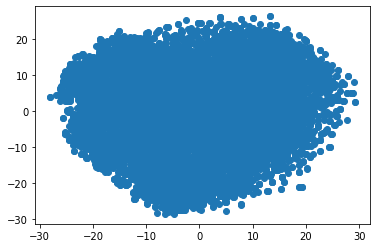

In [ ]:
# Analyze good and bad eras to see how they differ
# Try tSNE on subset of features

dataset = validation_data[feature_names]
bad_subset = dataset[validation_data.era.isin([bad_eras[0]])]
good_subset = dataset[validation_data.era.isin([good_eras[0]])]

results = pd.concat([bad_subset,good_subset])
tsne = TSNE(n_jobs=-1)
%time Y = tsne.fit_transform(results)

x,y=zip(*Y)
plt.scatter(x,y)


In [ ]:
validation_data.era.isin([bad_eras[0]])

0          False
1          False
2          False
3          False
4          False
           ...  
1545360    False
1545361    False
1545362    False
1545363    False
1545364    False
Name: era, Length: 137779, dtype: bool

# Build Logistic Regression model

In [ ]:
# Build logstic regression model from training data

from sklearn.linear_model import LogisticRegression

# Find the samples with 0 and 1 for target values

df = training_data.loc[training_data['target'] == 1]
zeros = training_data.loc[training_data['target'] == 0]
df = df.append(zeros, ignore_index=True)

lr = LogisticRegression()

lr.fit(df[feature_names],df['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Add logreg prediction to df of other models

pred_log = pd.DataFrame(lr.predict_proba(X_train))

ens_features = pd.concat([y_pred1,
                          y_pred2,
                          y_pred3,
                          y_pred4,
                          y_pred5,
                          pred_log], axis=1)
ens_features.columns = ['0','1','2','3','4','5','6']

ens_model.fit(ens_features,y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0,
             importance_type='gain', learning_rate=0.005, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=0)

# Generate predictions for submission



## 5 models + LR model

In [ ]:
# predict the target on the live features
feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]

# Break up predictions in parts so colab doesnt crash

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions1_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_1.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions1_df = np.append(predictions1_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions2_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_2.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions2_df = np.append(predictions2_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions3_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_3.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions3_df = np.append(predictions3_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions4_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_4.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions4_df = np.append(predictions4_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions5_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_5.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions5_df = np.append(predictions5_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
pred_log = pd.DataFrame()
for i in np.arange(0,len(chunk_start)):
  predictions = lr.predict_proba(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  pred_log = pred_log.append(pd.DataFrame(predictions))

pred_log.reset_index(drop=True)
ens_features = pd.concat([pd.DataFrame(predictions1_df),
                          pd.DataFrame(predictions2_df),
                          pd.DataFrame(predictions3_df),
                          pd.DataFrame(predictions4_df),
                          pd.DataFrame(predictions5_df),
                          pd.DataFrame(pred_log[:][0].values),
                          pd.DataFrame(pred_log[:][1].values)], axis=1)
ens_features.columns = ['0','1','2','3','4','5','6']

NameError: ignored

In [ ]:
# Predict using the ensemble model
predictions = ens_model.predict(ens_features)# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = pd.DataFrame(predictions)
predictions_df = live_data["id"].to_frame()
predictions_df["prediction_kazutsugi"] = predictions
print('Complete')

Complete


In [ ]:
predictions_df

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.497067
1,n000920ed083903f,0.492735
2,n0038e640522c4a6,0.510441
3,n004ac94a87dc54b,0.502254
4,n0052fe97ea0c05f,0.500587
...,...,...
1693041,nffe7b93a3b669a5,0.498835
1693042,nffeaf15f7ecd10b,0.495929
1693043,nfff26fc05c7d497,0.500355
1693044,nfff4cabd97debf2,0.507205


## 5 models without LR

In [ ]:
# predict the target on the live features
feature_names = validation_data.columns[validation_data.columns.str.startswith('feature')]

# Break up predictions in parts so colab doesnt crash

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions1_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_1.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions1_df = np.append(predictions1_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions2_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_2.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions2_df = np.append(predictions2_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions3_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_3.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions3_df = np.append(predictions3_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions4_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_4.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions4_df = np.append(predictions4_df,predictions)

chunk_start = np.arange(0,len(live_data),int(len(live_data)/100))
chunk_end = np.append(chunk_start,len(live_data))
predictions5_df = np.empty([0,1])
for i in np.arange(0,len(chunk_start)):
  predictions = model_5.predict(live_data[chunk_start[i]:chunk_end[i+1]][feature_names])
  predictions5_df = np.append(predictions5_df,predictions)

ens_features = pd.concat([pd.DataFrame(predictions1_df),
                          pd.DataFrame(predictions2_df),
                          pd.DataFrame(predictions3_df),
                          pd.DataFrame(predictions4_df),
                          pd.DataFrame(predictions5_df)],axis=1)
ens_features.columns = ['0','1','2','3','4']

In [ ]:
# Predict using the ensemble model
predictions = ens_model.predict(ens_features)# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = pd.DataFrame(predictions)
predictions_df = live_data["id"].to_frame()
predictions_df["prediction_kazutsugi"] = predictions
print('Complete')

Complete


In [ ]:
np.shape(predictions)

(100000,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


getting per era scores


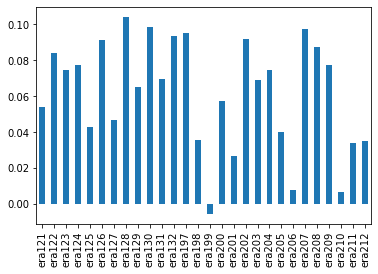

In [ ]:
# Check correlation with validation data
val_data = live_data[live_data['data_type']=='validation']
predicted_target = predictions_df[live_data['data_type']=='validation']['prediction_kazutsugi']
target = val_data['target']

new_df = pd.DataFrame({'pred':predicted_target,'target':target})
era_scores = pd.Series(index=val_data["era"].unique())
print("getting per era scores")
for era in val_data["era"].unique():
    era_df = new_df[val_data["era"] == era]
    era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
era_scores.sort_values(inplace=True)
era_scores.sort_index(inplace=True)
era_scores.plot(kind="bar")


In [ ]:
np.std(era_scores)

0.0296977427723627